Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import zscore



In [2]:
# Loading dataset

data_set=pd.read_excel("Healthcare_dataset.xlsx")

In [3]:
#check for missing values

missing_values=data_set.isnull().sum()

missing_columns=missing_values[missing_values > 0]
print(missing_columns)


Series([], dtype: int64)


From the result, it's clear that there is no missing values in the given dataset

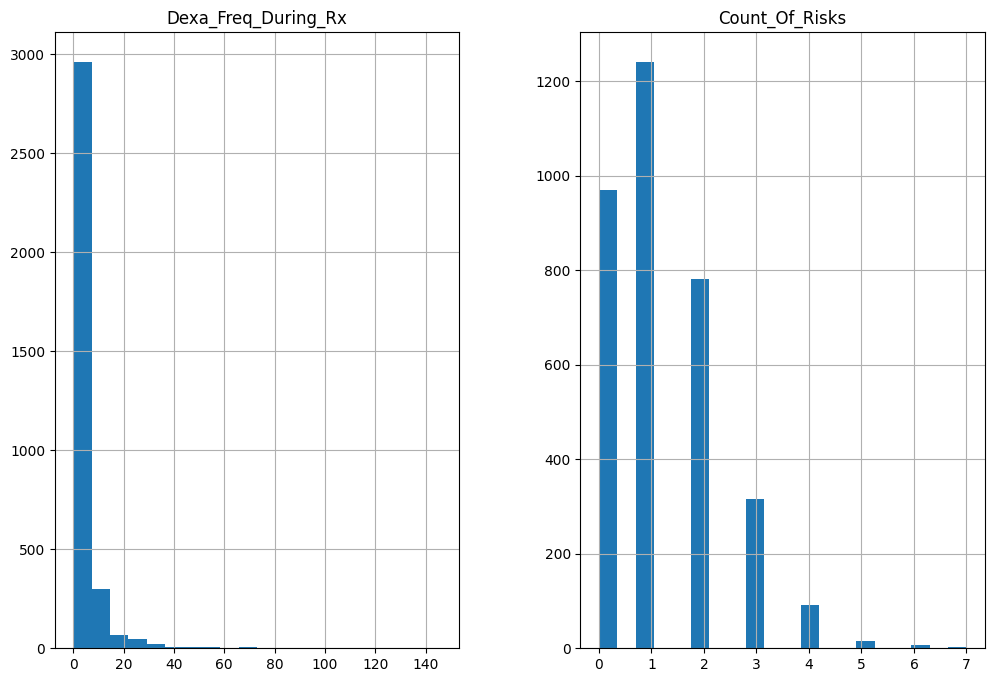

In [4]:
#Plot histograms to check the distribution of numerical features

data_set.hist(figsize=(12,8),bins=20)
plt.show()

The above distributions suggest that most patients have a low frequency of Dexa during Rx and tend to have 0-2 risks, with fewer patients having higher frequencies or more risks.

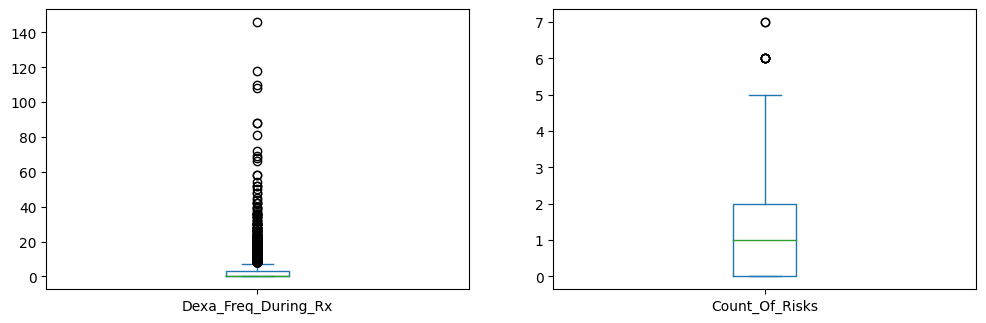

In [5]:
# plotting box plots to identify outliers

data_set.plot(kind='box', subplots=True,layout=(2,2),figsize=(12,8),sharex=False,sharey=False)
plt.show()

In Dexa_Freq_During_Rx, the box representing the interquartile range is very samll and close to 0. The median is very close to Zero. There is a long upper whisker extending to about 20. Many outliers are present, range from 20 to 140, with most extreme outlier at about 145. In COunt_Of_Risk, the box extends from 0 to 2, with the median at 1. The upper whisker extends to about 5, and a several outliers, with maximum at 7.

Both variables have outliers, but Dexa_Freq_During_Rx has more extreme outliers relative to its central tendency.

In [6]:
# handling outliers

# calculating Z-score for the numerical columns

data_set['Dexa_Freq_During_Rx_Z_Score']=zscore(data_set['Dexa_Freq_During_Rx'])
data_set['Count_Of_Risks_Z_Score']=zscore(data_set['Count_Of_Risks'])

# Setting threshold for finding outliers

threshold=3

# Filtering the outliers
data_cleaned=data_set[(abs(data_set['Dexa_Freq_During_Rx_Z_Score'])<threshold)&(abs(data_set['Count_Of_Risks_Z_Score'])<threshold)]


# dropping the Z-score column
data_cleaned=data_cleaned.drop(['Dexa_Freq_During_Rx_Z_Score','Count_Of_Risks_Z_Score'],axis=1)


# checking the shape of the cleaned dataset
data_cleaned.shape

(3344, 69)

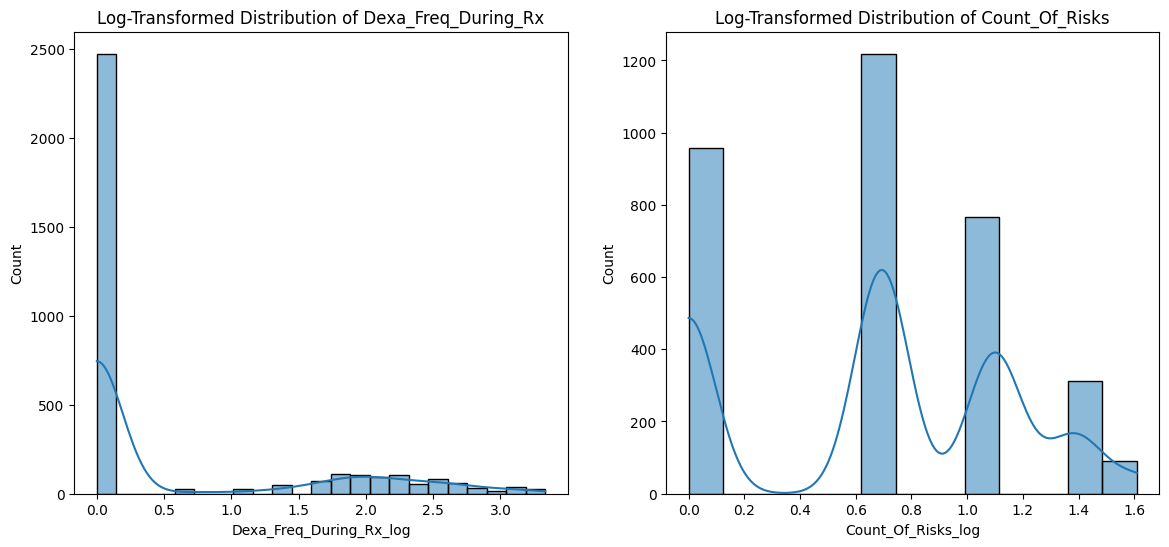

In [7]:
# Transforming skewed data

# From the above graph, it is clearly shows that Dexa_ is heavily right skewed
# and although Count_of_Risks is distributed evenly, it is lightly skewed.

# Applying log transformation to the numerical columns

data_cleaned['Dexa_Freq_During_Rx_log']=np.log1p(data_cleaned['Dexa_Freq_During_Rx'])
data_cleaned['Count_Of_Risks_log']=np.log1p(data_cleaned['Count_Of_Risks'])

# plotting the transformed data in histogram

plt.figure(figsize=(14,6))

# Histogram for Dexa_Freq_During_Rx_log
plt.subplot(1,2,1)
sns.histplot(data_cleaned['Dexa_Freq_During_Rx_log'],kde=True)
plt.title('Log-Transformed Distribution of Dexa_Freq_During_Rx')

# Histogram for COunt of Risks_log

plt.subplot(1,2,2)
sns.histplot(data_cleaned['Count_Of_Risks_log'],kde=True)
plt.title('Log-Transformed Distribution of Count_Of_Risks')

plt.show()

In [8]:
# Converting datatype of categorical columns to category datatype

categorical_columns=data_cleaned.select_dtypes(include=['object']).columns
data_cleaned[categorical_columns]=data_cleaned[categorical_columns].astype('category')

# verifying the datatype
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3344 entries, 0 to 3423
Data columns (total 71 columns):
 #   Column                                                              Non-Null Count  Dtype   
---  ------                                                              --------------  -----   
 0   Ptid                                                                3344 non-null   category
 1   Persistency_Flag                                                    3344 non-null   category
 2   Gender                                                              3344 non-null   category
 3   Race                                                                3344 non-null   category
 4   Ethnicity                                                           3344 non-null   category
 5   Region                                                              3344 non-null   category
 6   Age_Bucket                                                          3344 non-null   category
 7   Ntm_Special

In [9]:
target_variable=data_cleaned['Persistency_Flag']
Feature_variable=data_cleaned.drop(['Persistency_Flag'],axis=1)

In [10]:
Feature_variable_cleaned=Feature_variable.drop(['Ptid'],axis=1)

In [11]:
# Function to apply one-hot encoding to categorical variables
def encoding(df):
    encoder = OneHotEncoder(sparse_output=False)
    data_encoded = encoder.fit_transform(df)
    encoded_df = pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out(df.columns))
    return encoded_df

In [12]:
# Apply one-hot encoding to feature variables
data_encoded = encoding(Feature_variable_cleaned)

In [13]:
data_encoded.shape

(3344, 245)

In [14]:
# Convert the target variable in category datatype to numerical datatype
target_variable_encoded = pd.Series(target_variable.cat.codes, name='Persistency_Flag')

In [15]:
# Combine the encoded feature variables and target variable into a single DataFrame
data_encoded_df = pd.DataFrame(data_encoded, columns=encoding(Feature_variable_cleaned).columns)
data_combined = pd.concat([data_encoded_df, target_variable_encoded], axis=1)

In [16]:
# Calculate the correlation matrix for the combined DataFrame
correlation_matrix = data_combined.corr()

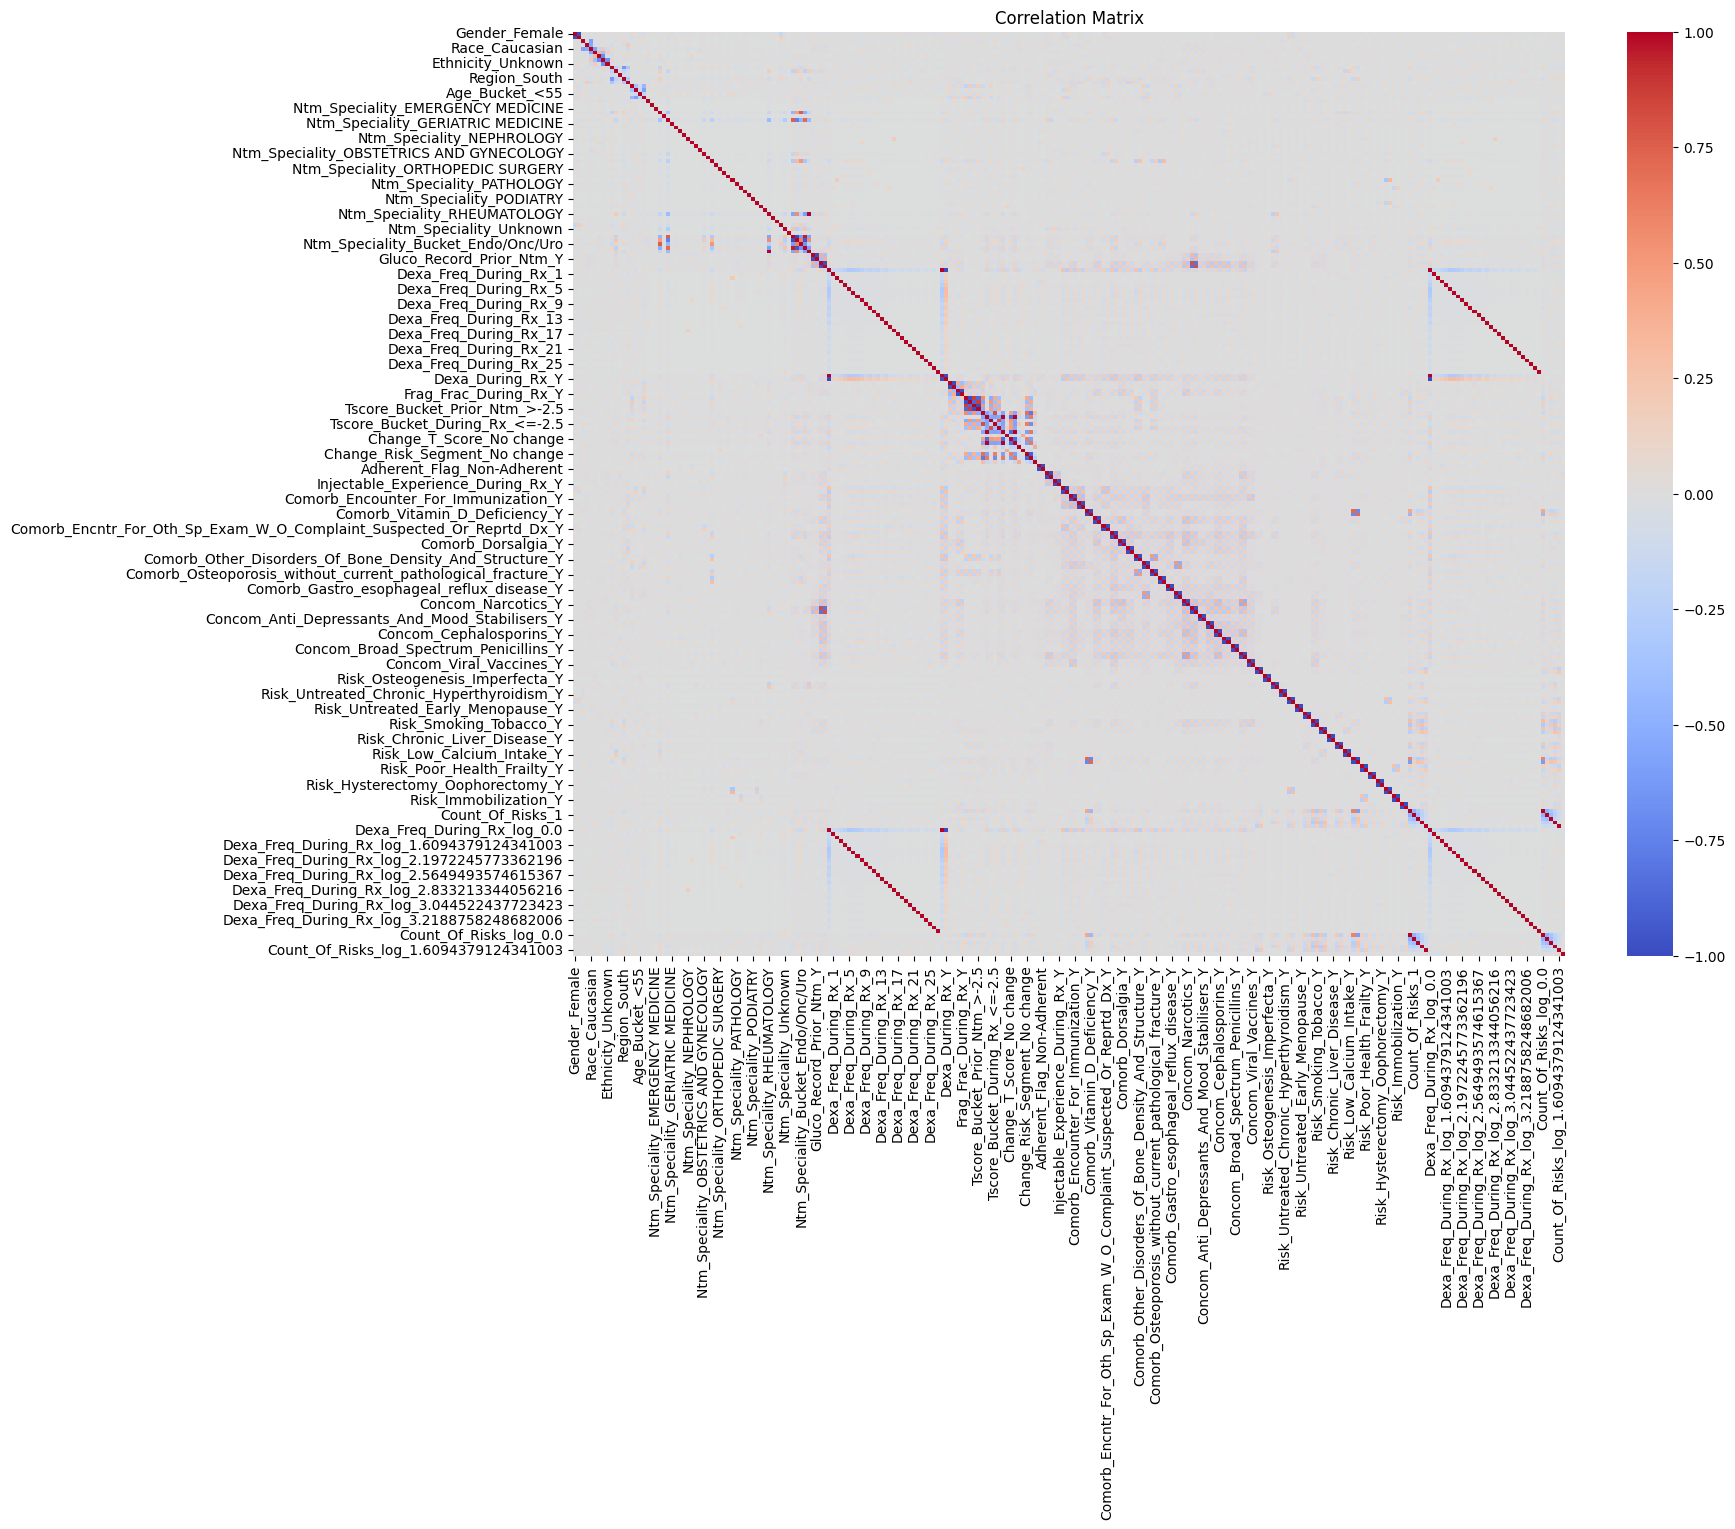

In [17]:
# Display the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [18]:
# Display the top 10 features most positively correlated with the target variable
target_correlation = correlation_matrix['Persistency_Flag'].sort_values(ascending=False)
top_positive_correlations = target_correlation.head(10)
print("Top 10 Positively Correlated Features:\n", top_positive_correlations)

Top 10 Positively Correlated Features:
 Persistency_Flag                                                     1.000000
Idn_Indicator_Y                                                      0.086721
Region_South                                                         0.078964
Ntm_Speciality_PULMONARY MEDICINE                                    0.052043
Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias_Y    0.050814
Injectable_Experience_During_Rx_Y                                    0.047119
Ntm_Speciality_OTOLARYNGOLOGY                                        0.043248
Risk_Family_History_Of_Osteoporosis_N                                0.041984
Dexa_Freq_During_Rx_19                                               0.039704
Dexa_Freq_During_Rx_log_2.995732273553991                            0.039704
Name: Persistency_Flag, dtype: float64


In [19]:
# Display the top 10 features most negatively correlated with the target variable
top_negative_correlations = target_correlation.tail(10)
print("Top 10 Negatively Correlated Features:\n", top_negative_correlations)

Top 10 Negatively Correlated Features:
 Tscore_Bucket_During_Rx_Unknown                                     -0.040374
Change_T_Score_Unknown                                              -0.040374
Risk_Family_History_Of_Osteoporosis_Y                               -0.041984
Ethnicity_Unknown                                                   -0.042371
Injectable_Experience_During_Rx_N                                   -0.047119
Dexa_Freq_During_Rx_log_1.0986122886681096                          -0.049152
Dexa_Freq_During_Rx_2                                               -0.049152
Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias_N   -0.050814
Region_Midwest                                                      -0.066896
Idn_Indicator_N                                                     -0.086721
Name: Persistency_Flag, dtype: float64


Exploratory Data analysis

In [20]:
# summary statistics of numerical features
data_set.describe()

Dexa_Freq_During_Rx  Count_Of_Risks  Dexa_Freq_During_Rx_Z_Score  \
count          3424.000000     3424.000000                 3.424000e+03   
mean              3.016063        1.239486                 1.660147e-17   
std               8.136545        1.094914                 1.000146e+00   
min               0.000000        0.000000                -3.707352e-01   
25%               0.000000        0.000000                -3.707352e-01   
50%               0.000000        1.000000                -3.707352e-01   
75%               3.000000        2.000000                -1.974478e-03   
max             146.000000        7.000000                 1.757562e+01   

       Count_Of_Risks_Z_Score  
count            3.424000e+03  
mean             1.203606e-16  
std              1.000146e+00  
min             -1.132204e+00  
25%             -1.132204e+00  
50%             -2.187577e-01  
75%              6.946891e-01  
max              5.261923e+00

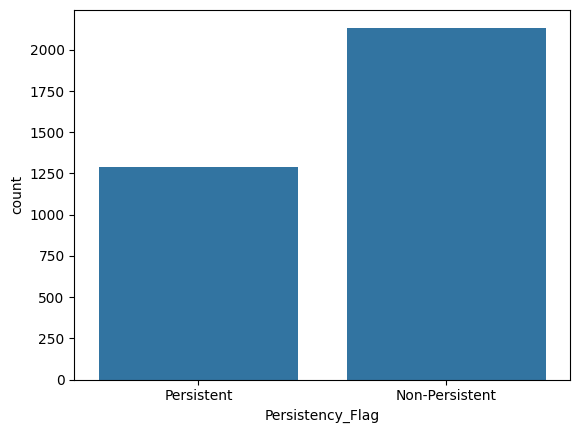

In [21]:
# Analysing the target variable

# plotting the distribution of the target variable

sns.countplot(x='Persistency_Flag', data=data_set)
plt.show()

In [22]:
# getting unique values and counts for each categorical features

for col in data_set.select_dtypes(include=object).columns:
  print(f"{col}: \n{data_set[col].value_counts()}\n")

Ptid: 
Ptid
P1       1
P2275    1
P2277    1
P2278    1
P2279    1
        ..
P1145    1
P1146    1
P1147    1
P1148    1
P3424    1
Name: count, Length: 3424, dtype: int64

Persistency_Flag: 
Persistency_Flag
Non-Persistent    2135
Persistent        1289
Name: count, dtype: int64

Gender: 
Gender
Female    3230
Male       194
Name: count, dtype: int64

Race: 
Race
Caucasian           3148
Other/Unknown         97
African American      95
Asian                 84
Name: count, dtype: int64

Ethnicity: 
Ethnicity
Not Hispanic    3235
Hispanic          98
Unknown           91
Name: count, dtype: int64

Region: 
Region
Midwest          1383
South            1247
West              502
Northeast         232
Other/Unknown      60
Name: count, dtype: int64

Age_Bucket: 
Age_Bucket
>75      1439
65-75    1086
55-65     733
<55       166
Name: count, dtype: int64

Ntm_Speciality: 
Ntm_Speciality
GENERAL PRACTITIONER                                              1535
RHEUMATOLOGY                  

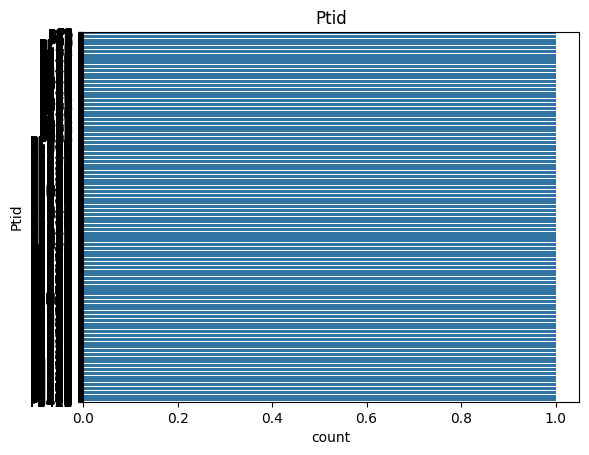

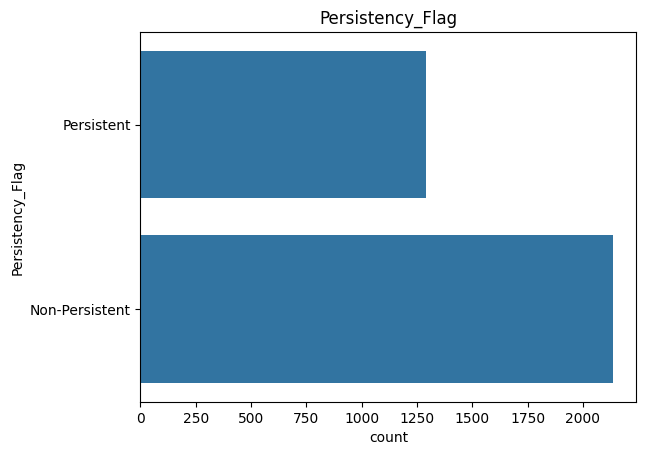

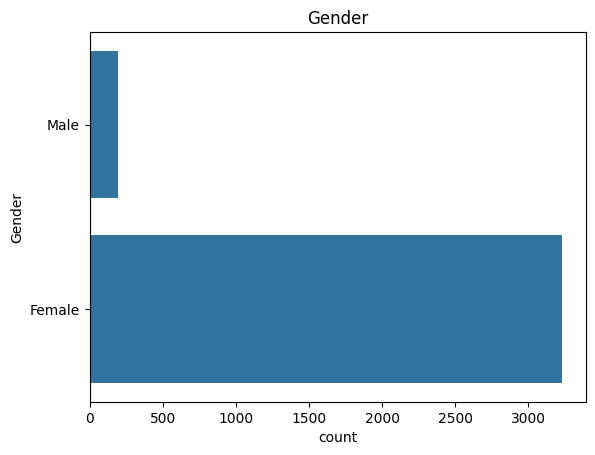

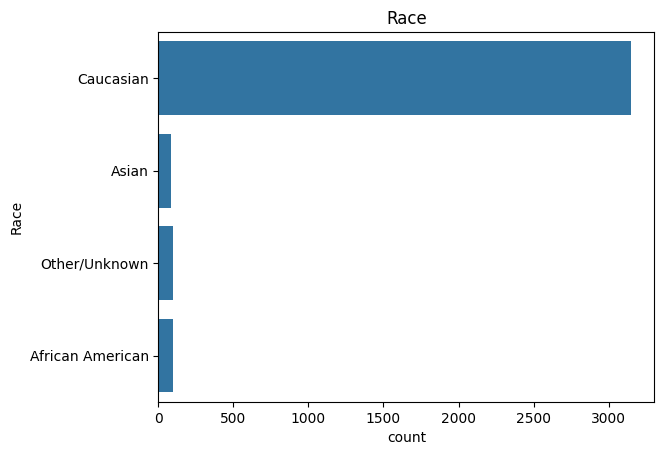

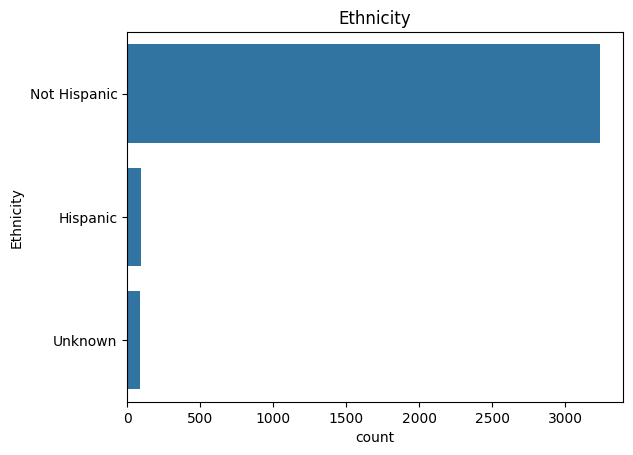

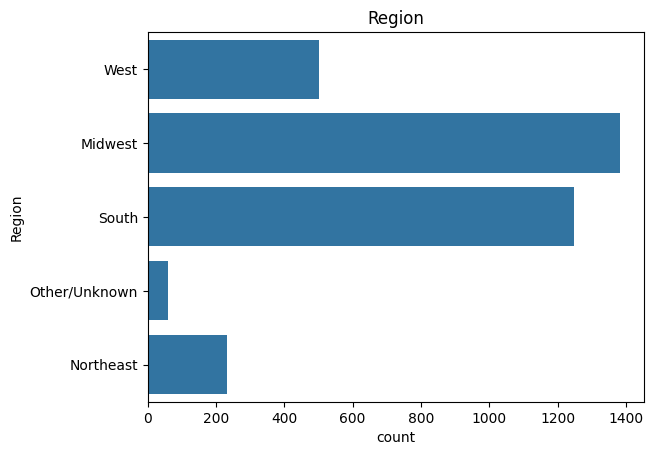

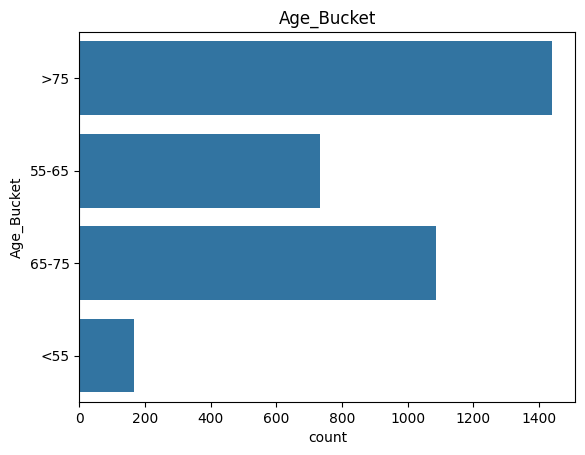

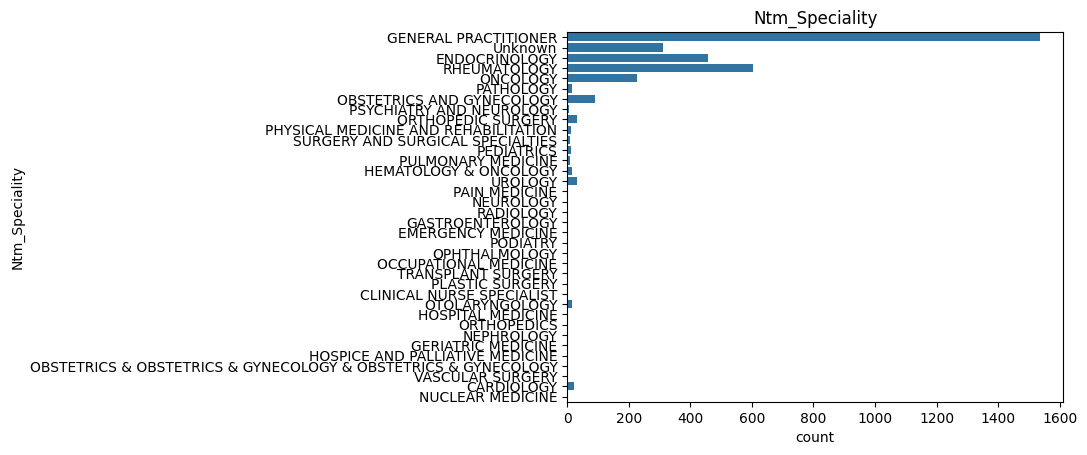

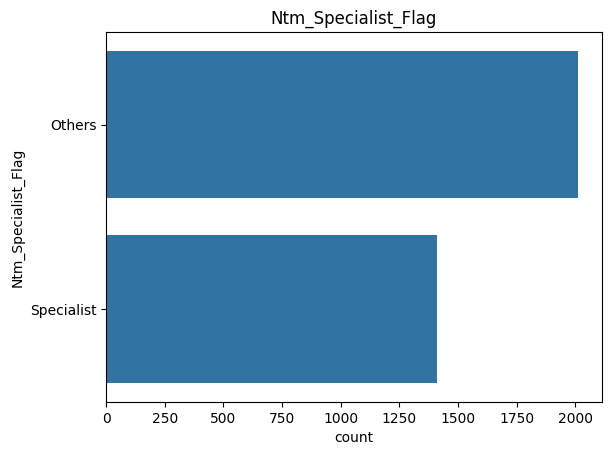

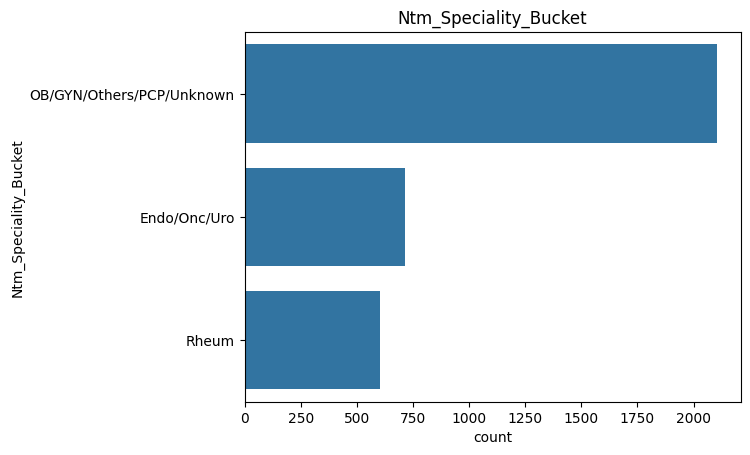

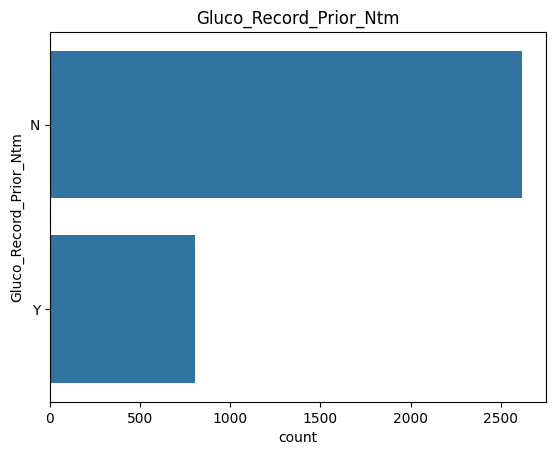

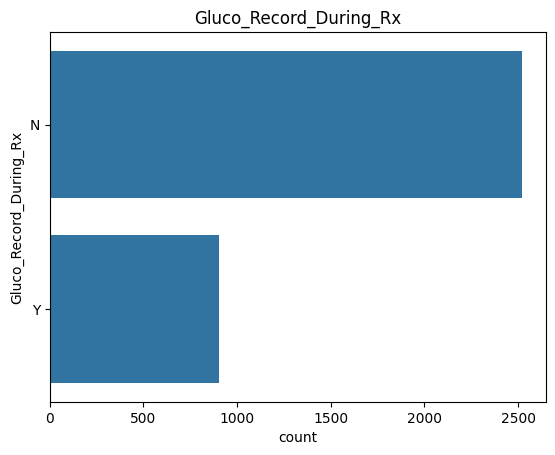

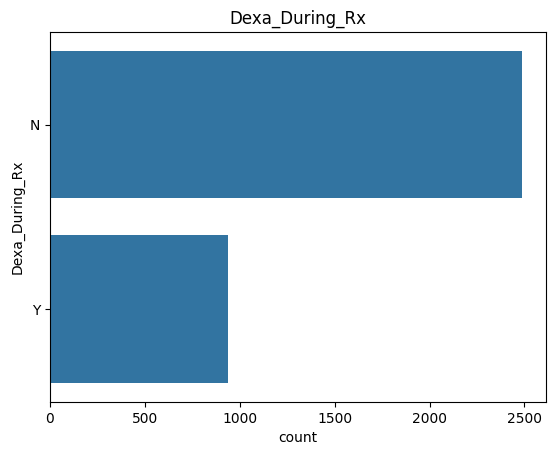

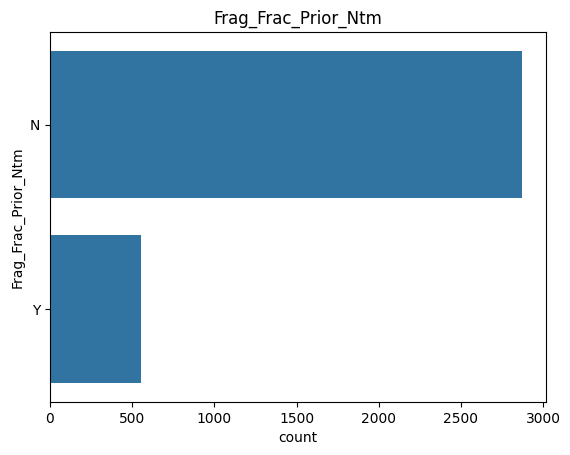

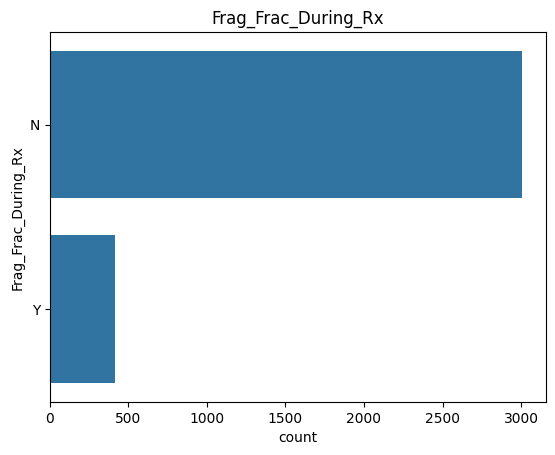

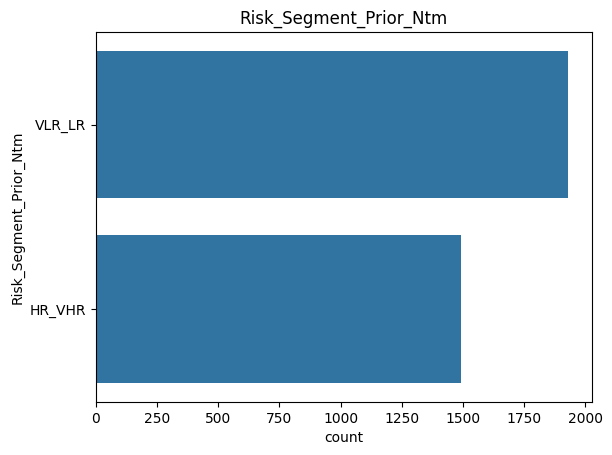

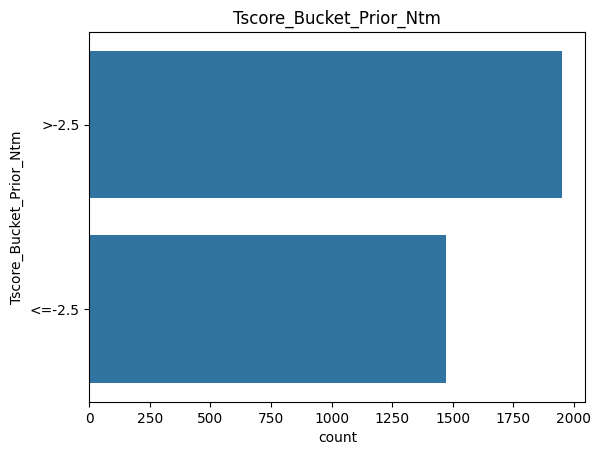

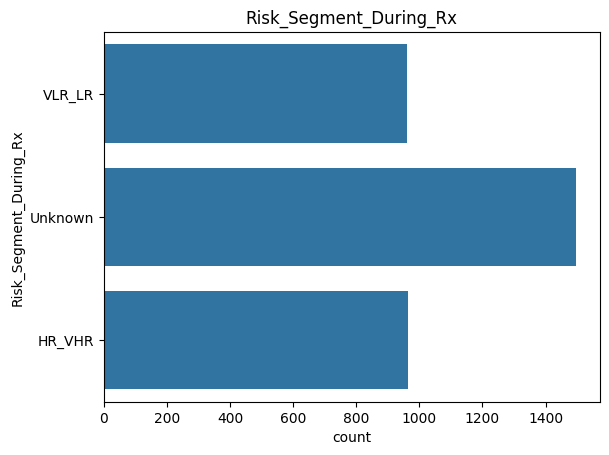

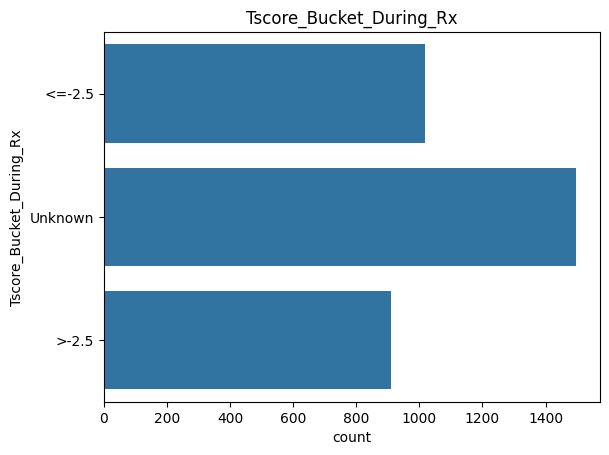

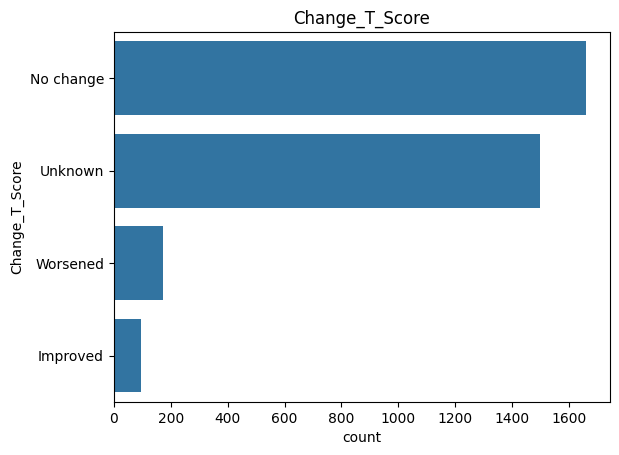

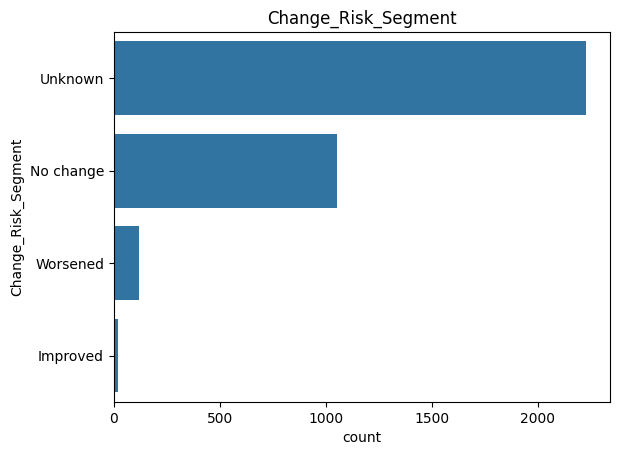

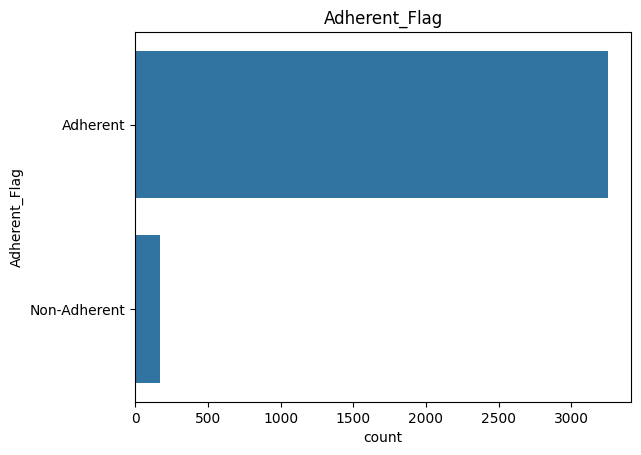

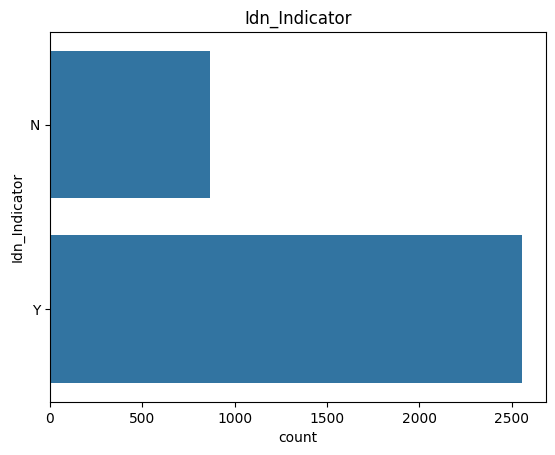

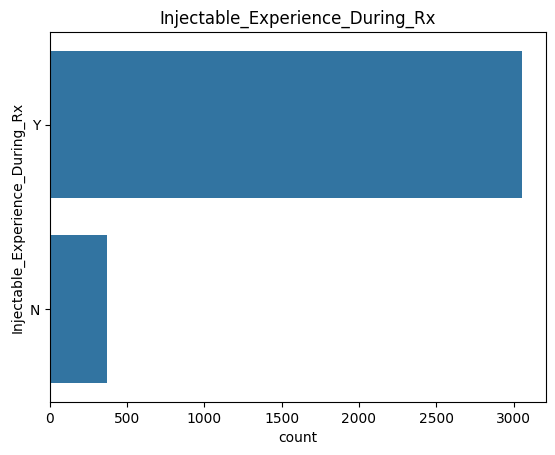

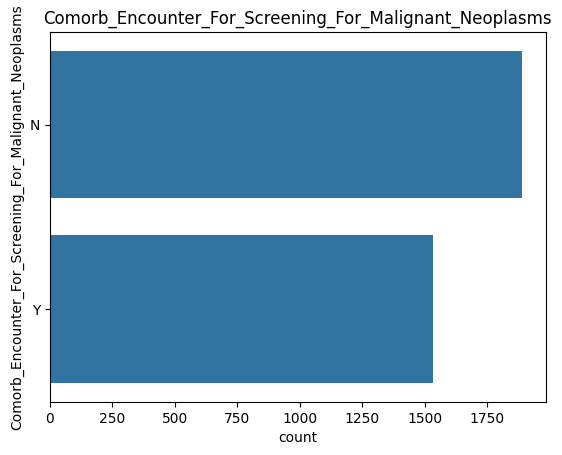

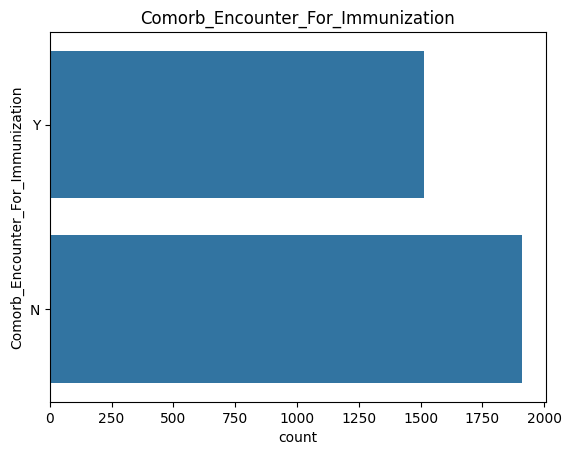

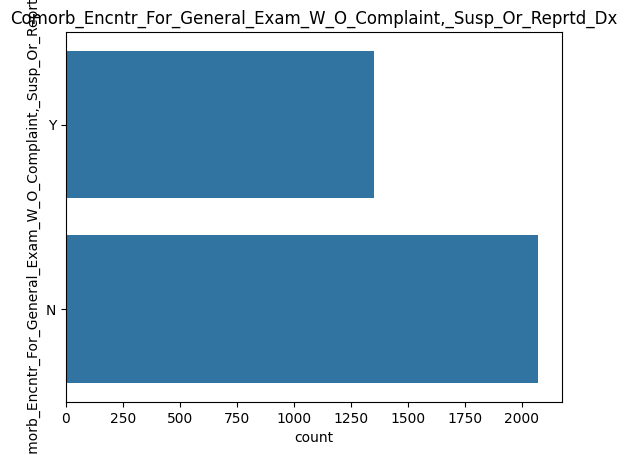

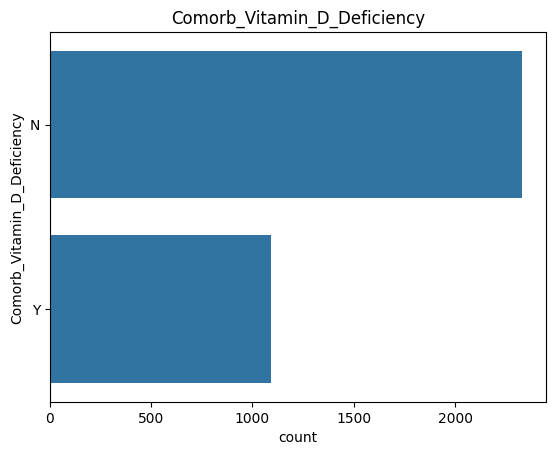

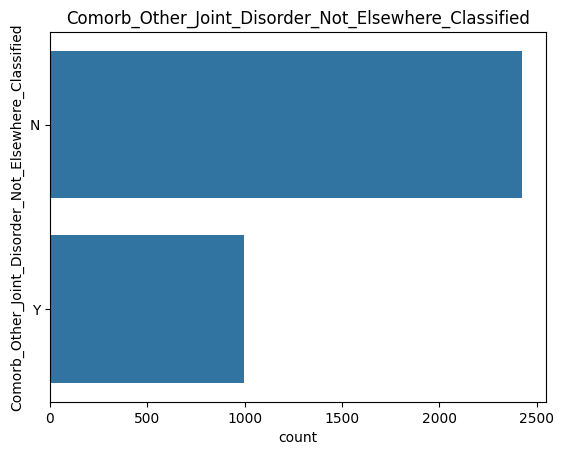

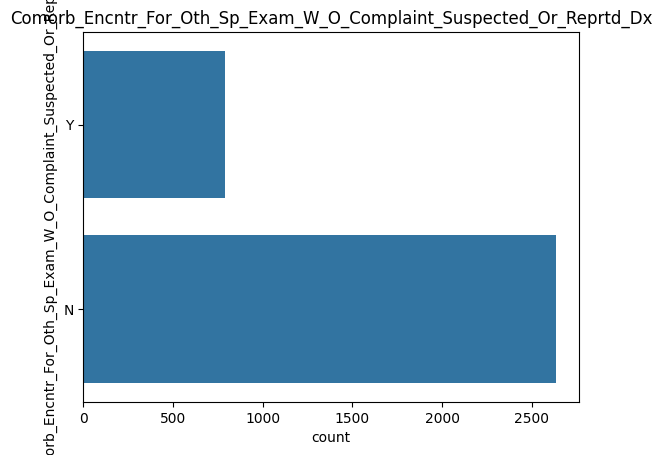

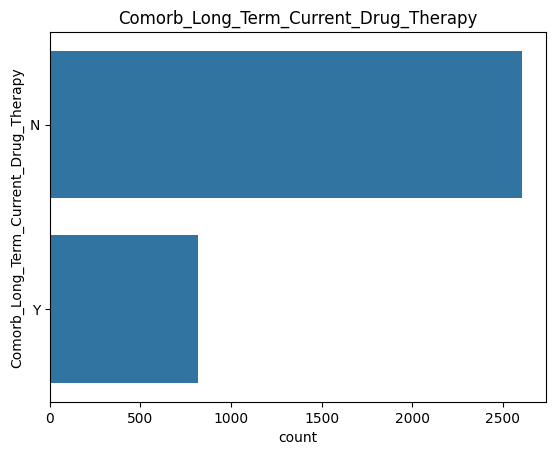

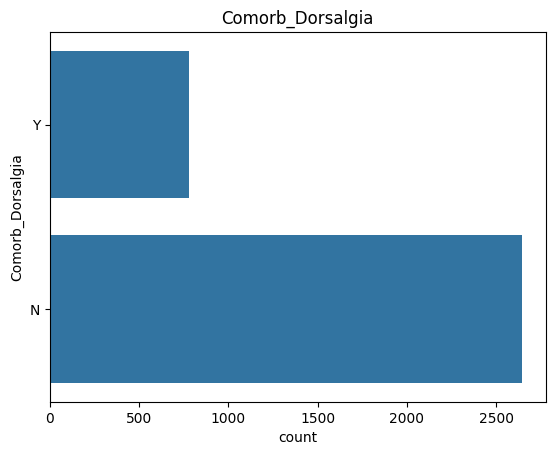

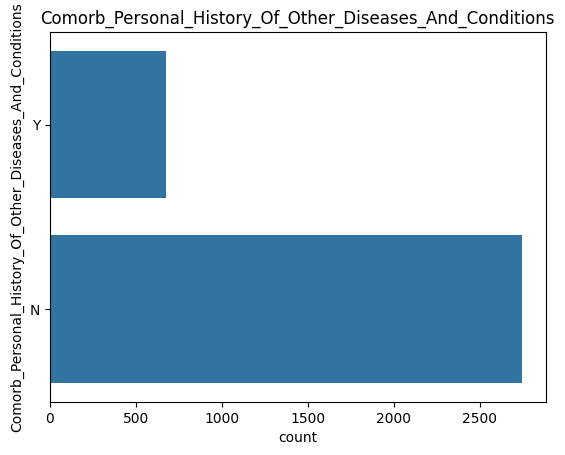

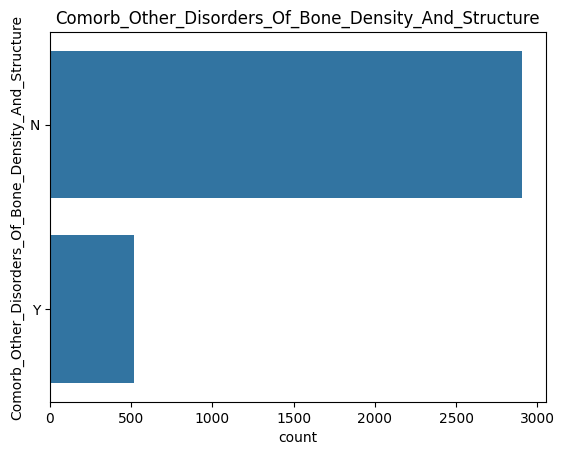

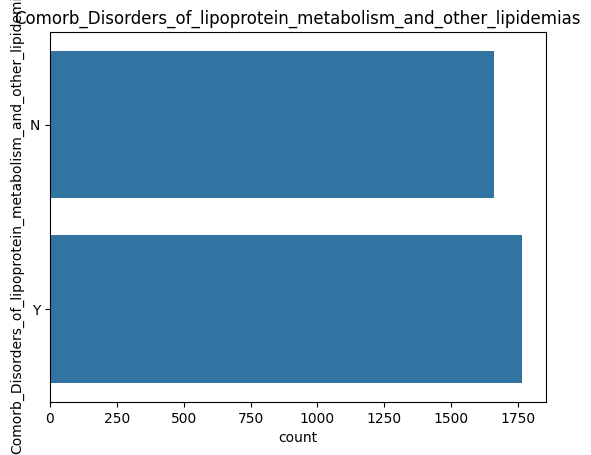

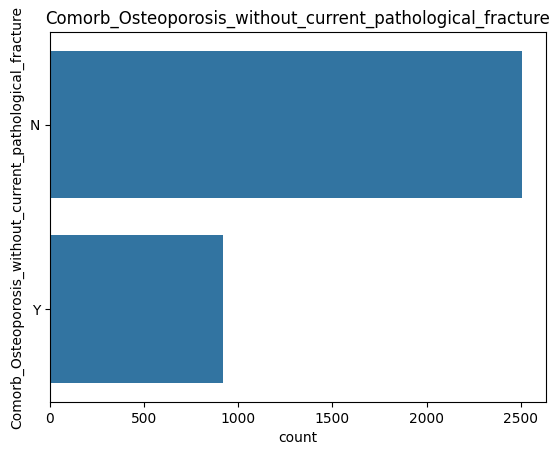

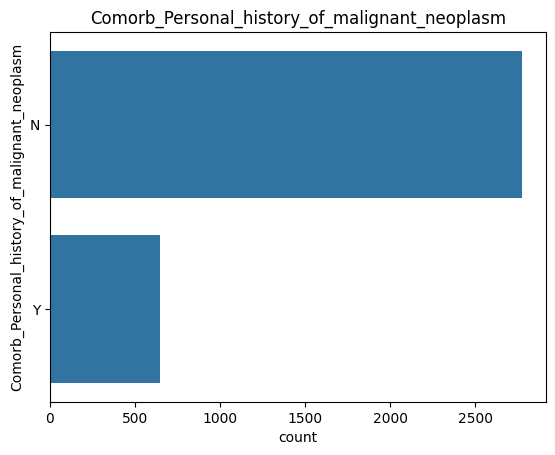

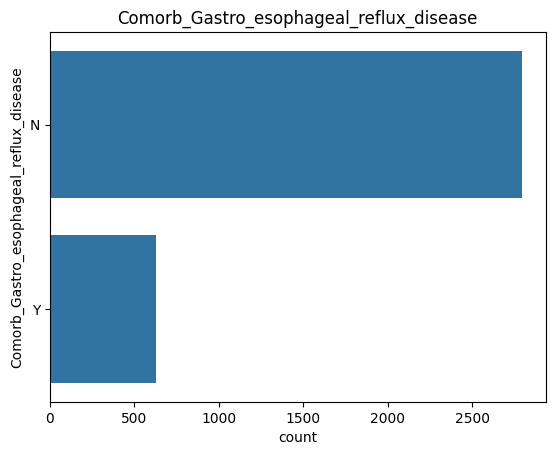

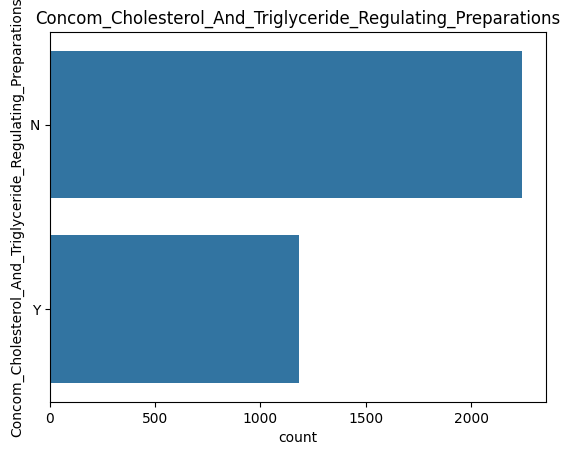

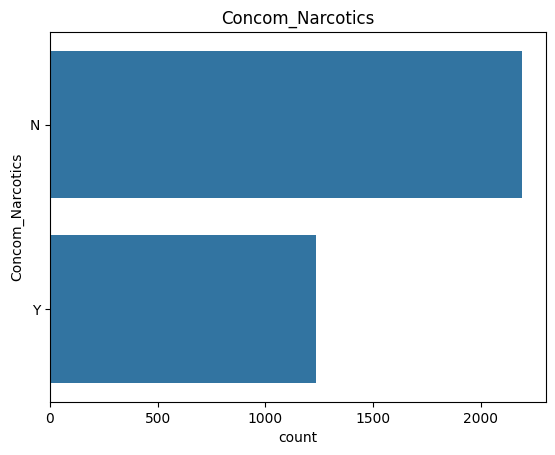

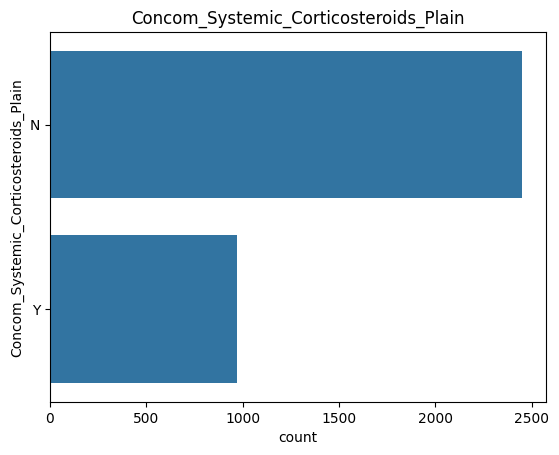

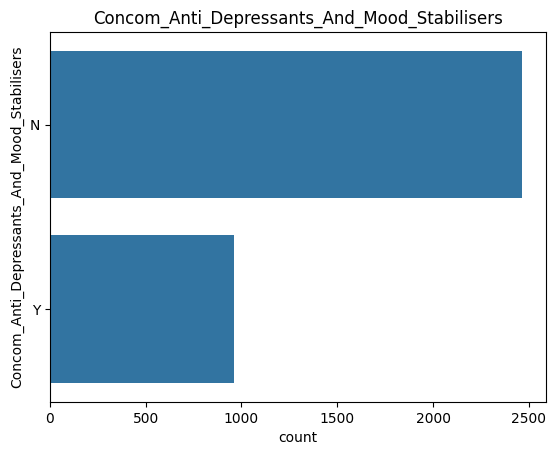

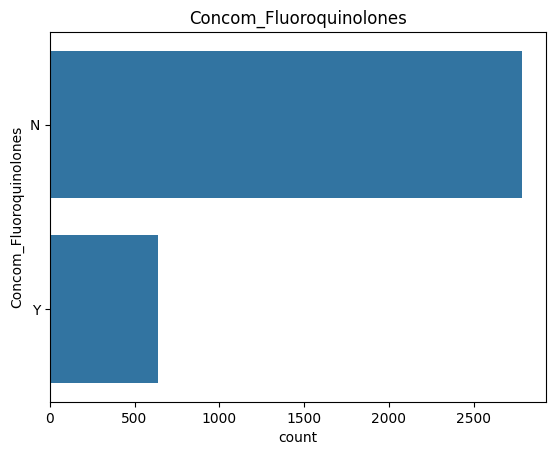

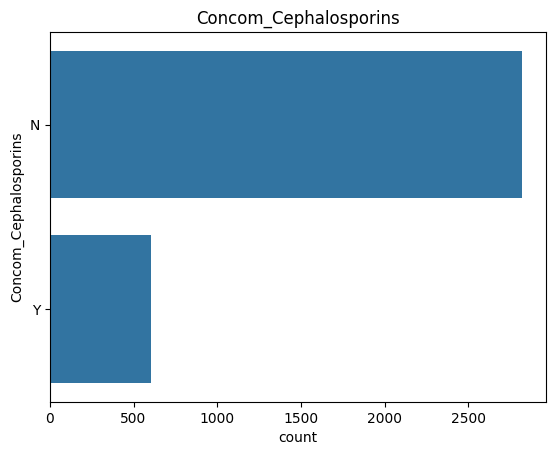

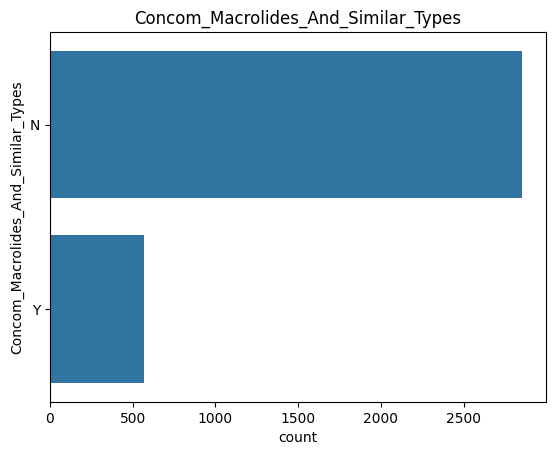

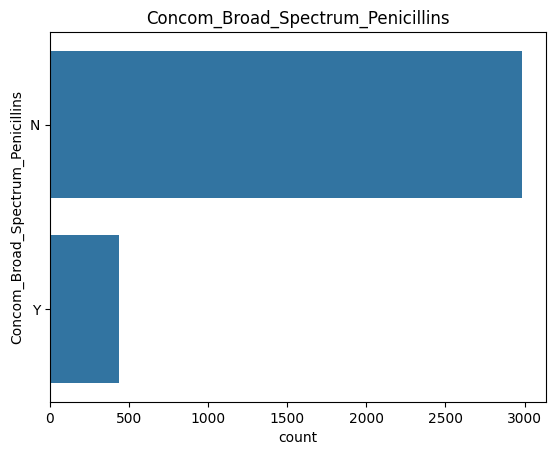

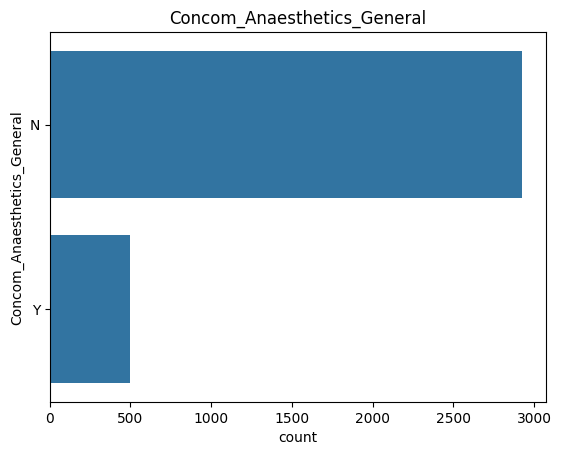

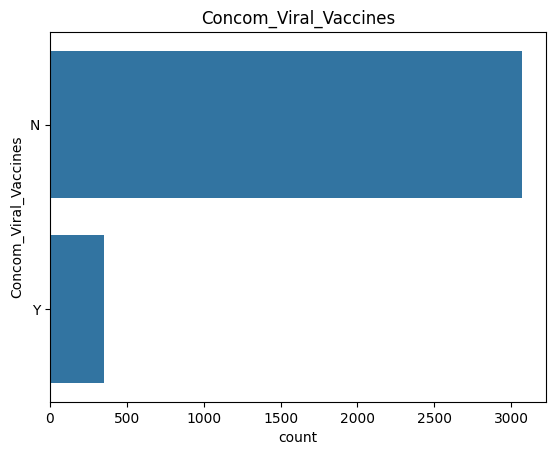

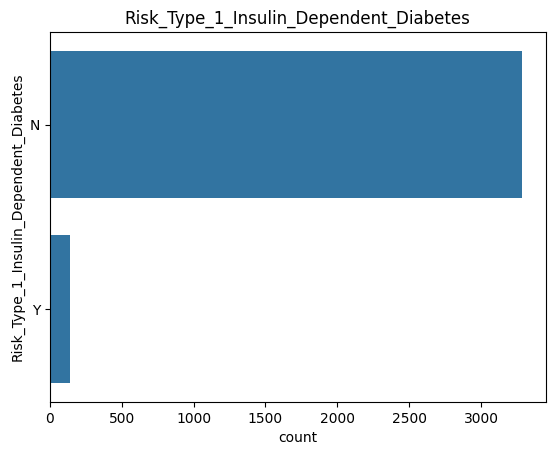

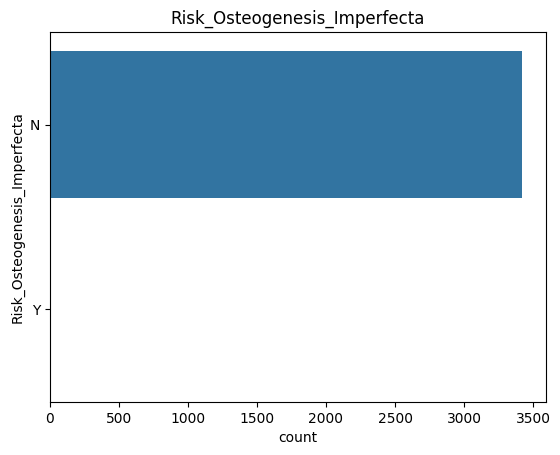

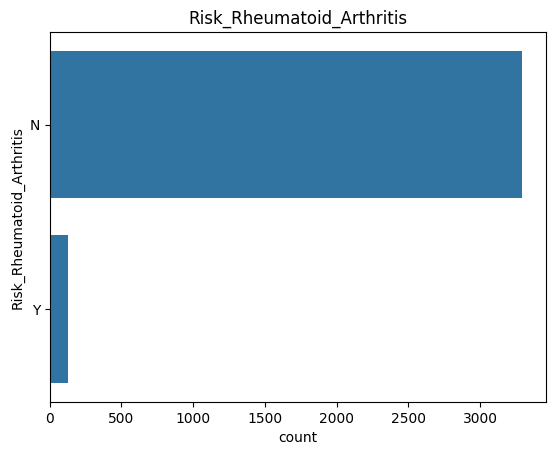

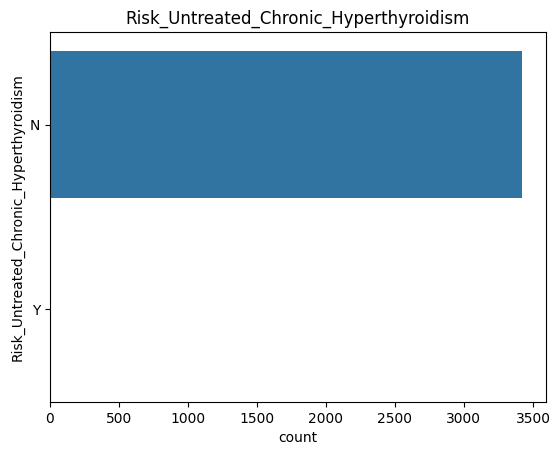

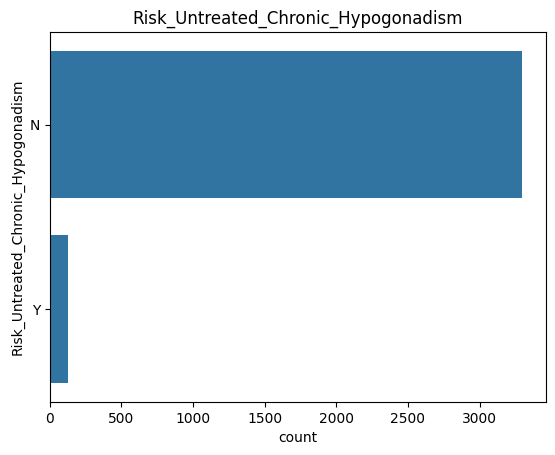

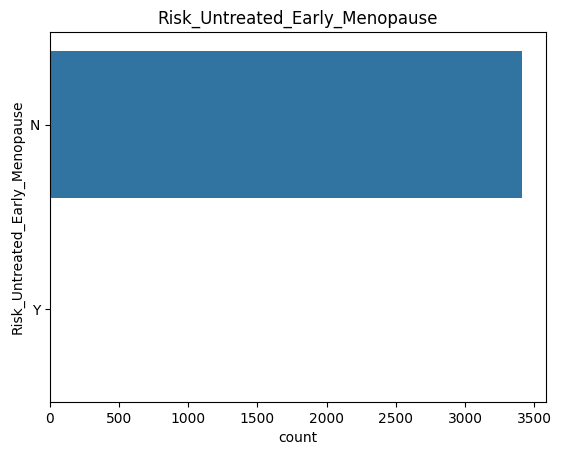

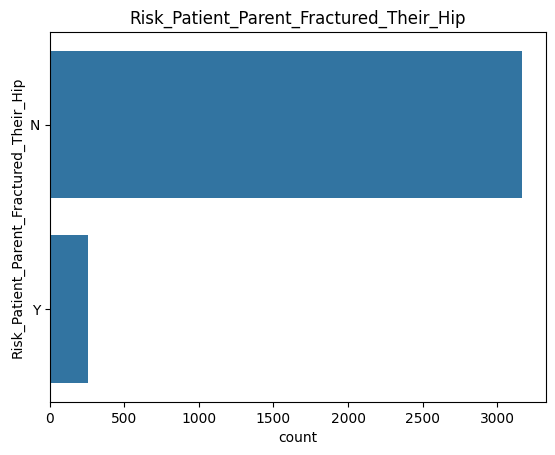

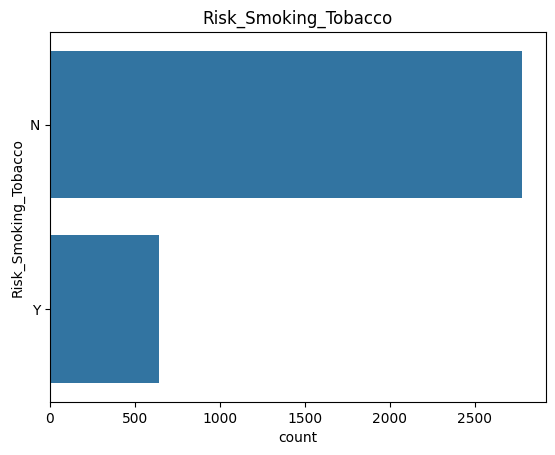

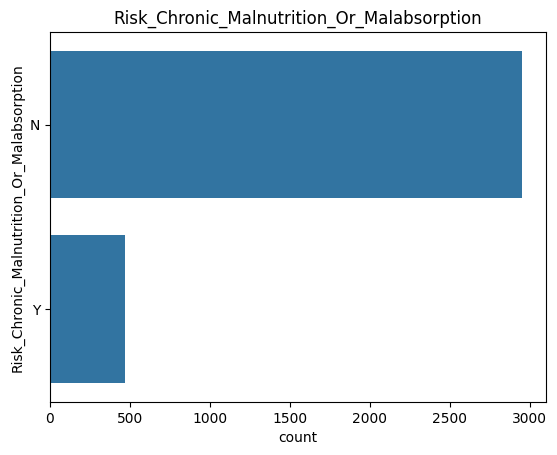

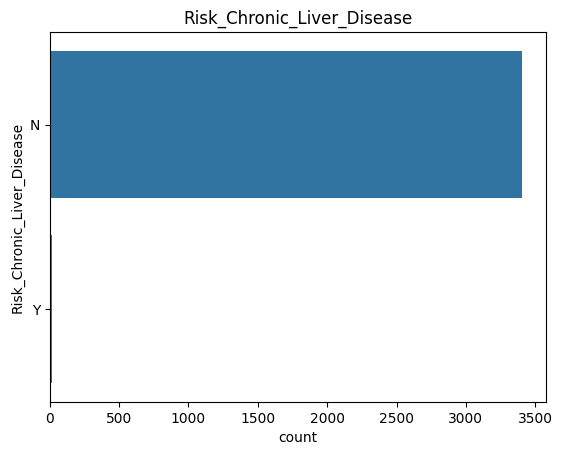

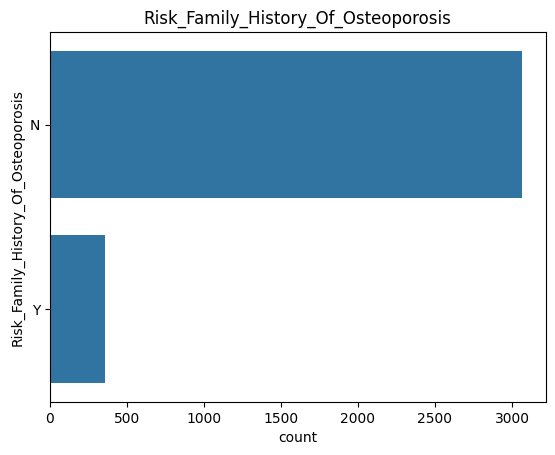

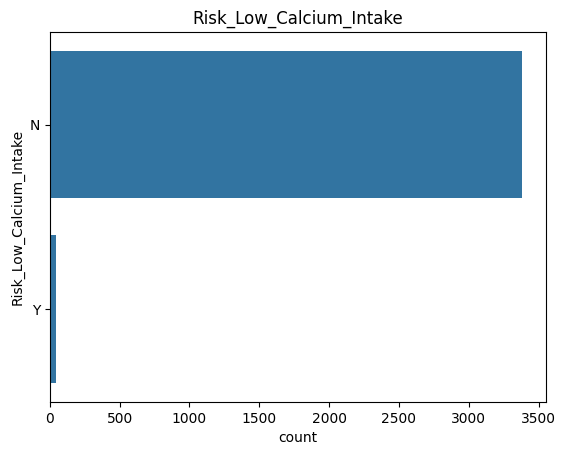

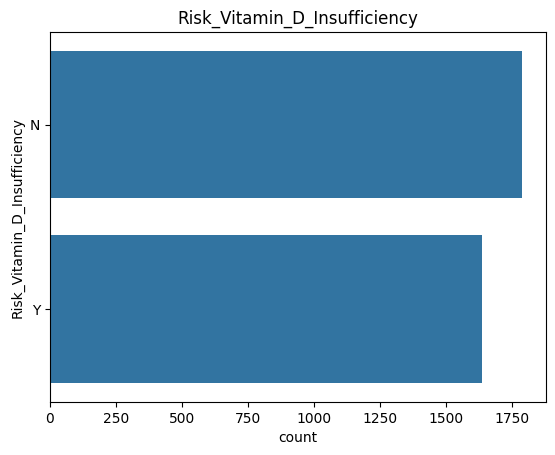

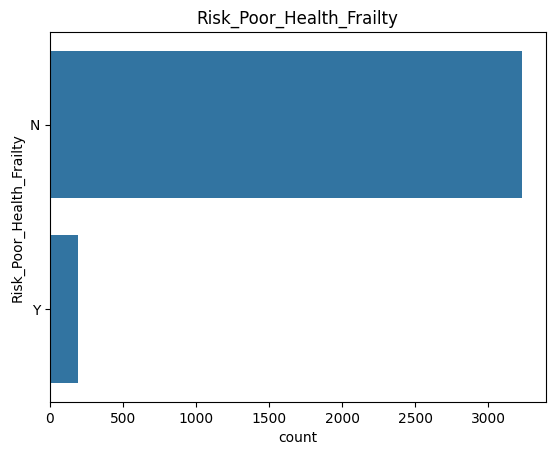

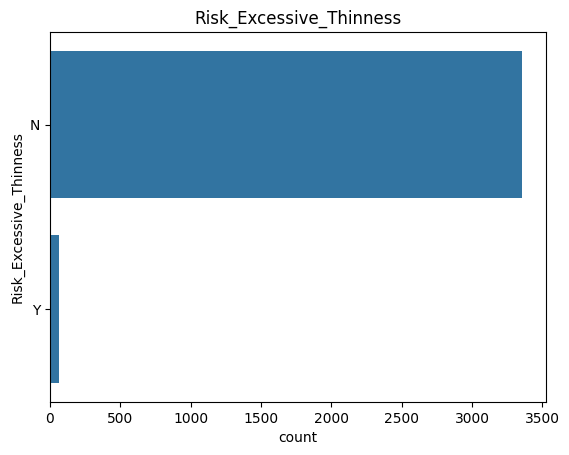

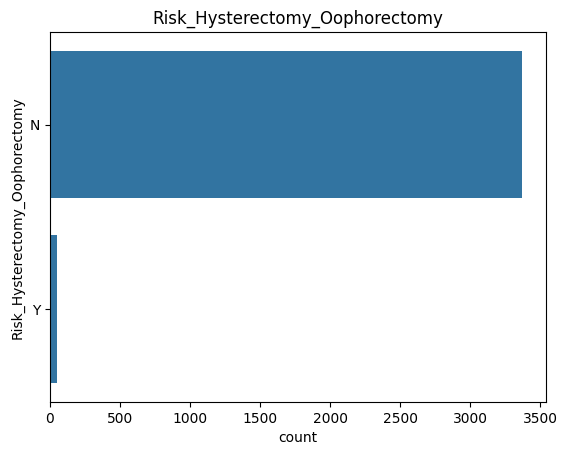

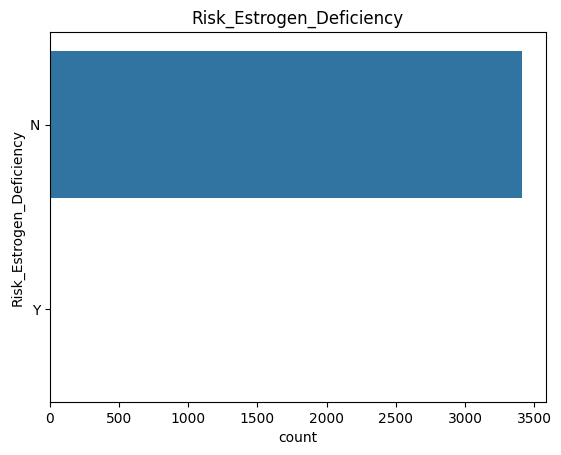

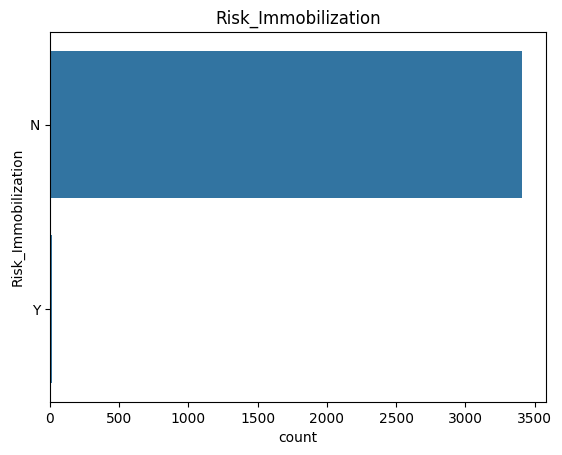

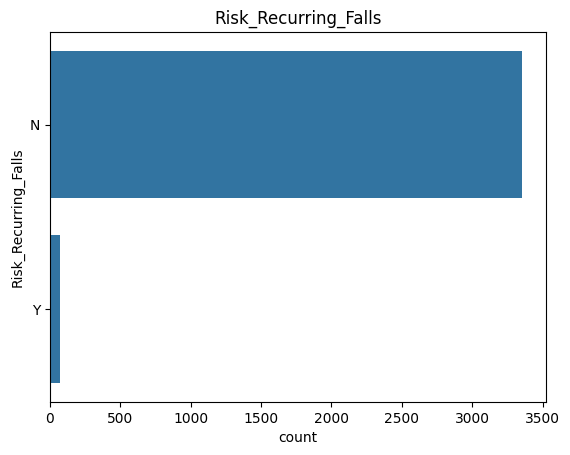

In [ ]:
#plot bar chart for categorical features

for col in data_set.select_dtypes(include=object).columns:
  plt.figure()
  sns.countplot(y=col,data=data_set)
  plt.title(col)
  plt.show()


Based on the above result,

1. The gender chart shows a clear imbalance. There are far more females than
males in the dataset. This suggests a gender bias in the data.
2. There's a strong bias towards Caucasians, who make up the vast majority of the dataset. Other races (Asian, African American, Other/Unknown) are significantly underrepresented. This indicates racial bias in the data.
3. The ethnicity chart shows a heavy bias towards "Not Hispanic" individuals. Hispanic and Unknown categories are very small in comparison. This suggests an ethnic bias in the data.
4. There's a strong imbalance favoring "Adherent" over "Non-Adherent". This suggests bias in the adherence data.
5. The consistent pattern might indicate a selection bias in the study population or data collection process.
6. Risk Type 1 Insulin Dependent Diabetes, Risk untreated chronic hypogonadism, Risk Patient Parent Fractured their hip are being heavily skewed towards 'N'.
And the distribution seems reasonable and doesn't indicate obvious bias.
7. Risk_Chronic_Liver_disease chart could potentially indicate bias or error, as it's unusual to have zero cases in the large dataset.
8. Risk_Low_calcium_Intake could indicate potential bias or measurements issues, as low calcium intake is generally more common.

From the result, some of the charts shows the extreme skewness and these indicates data collection bias, sampling bias, measurement errors

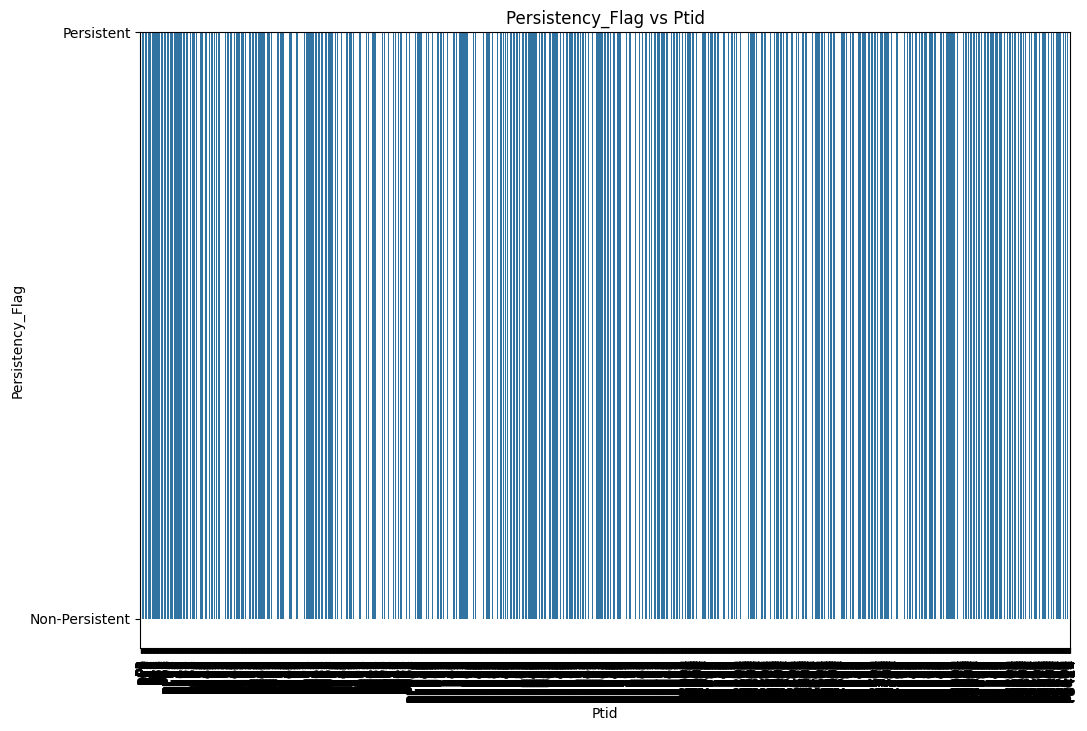

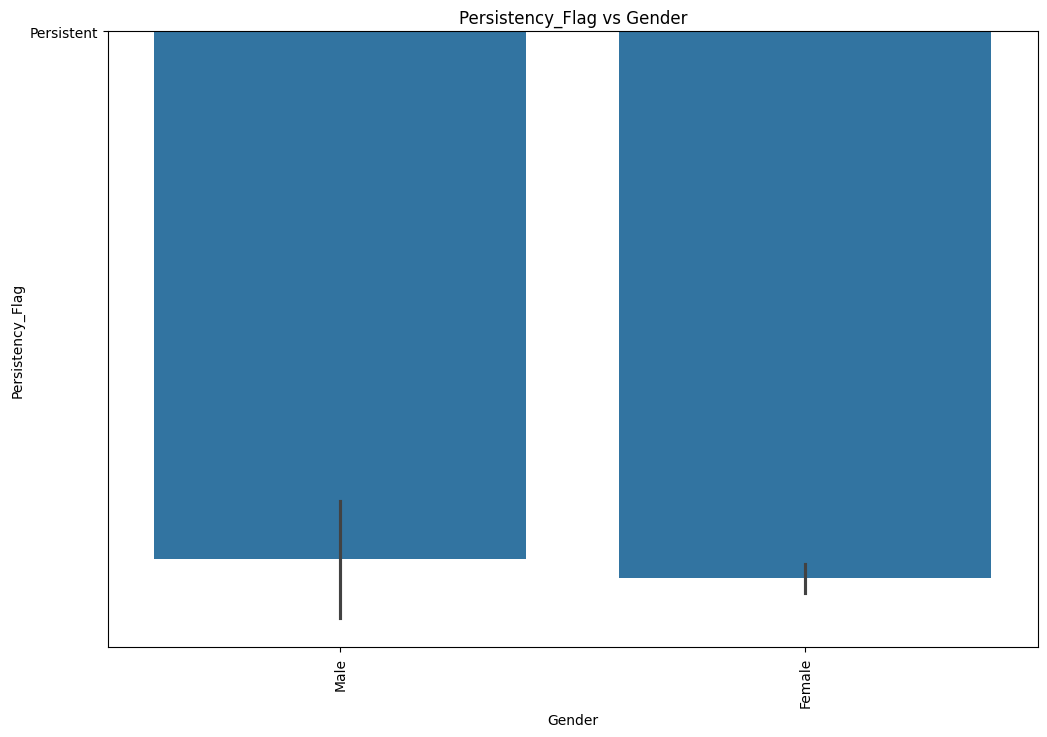

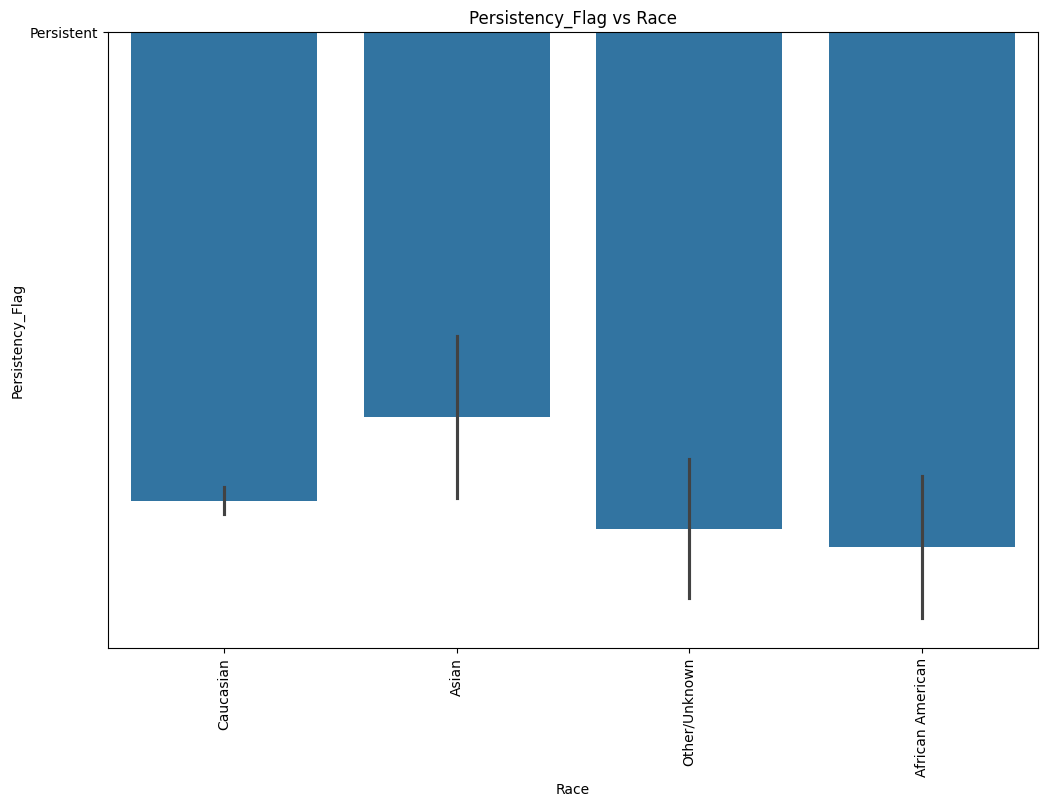

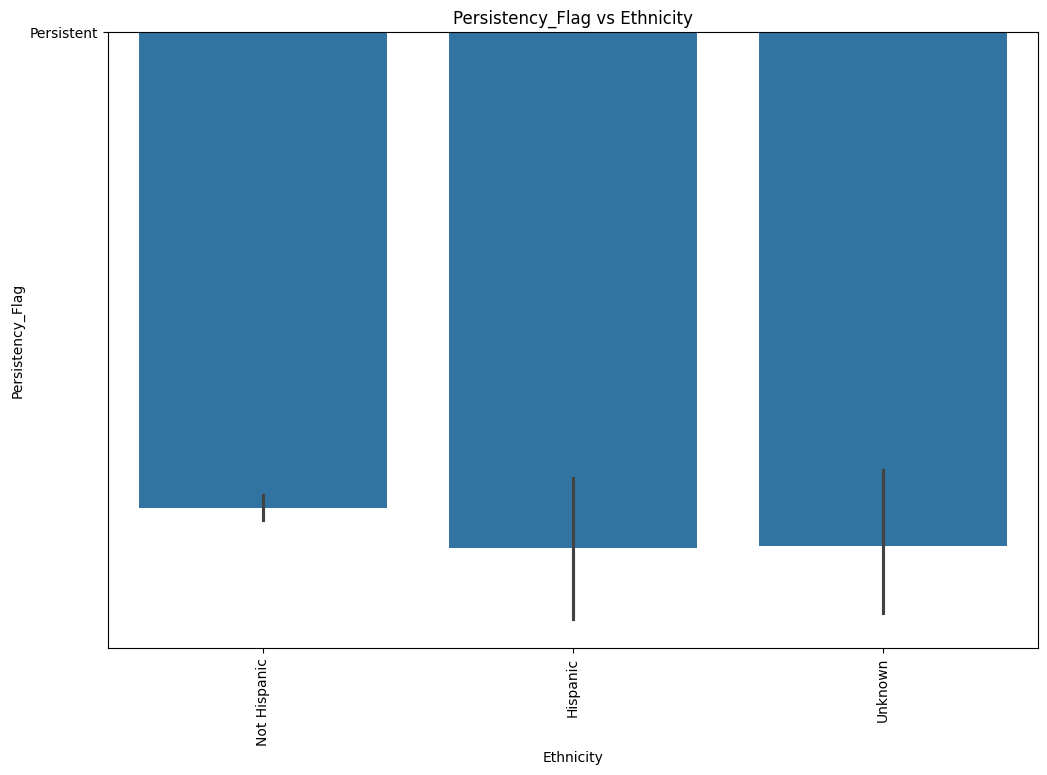

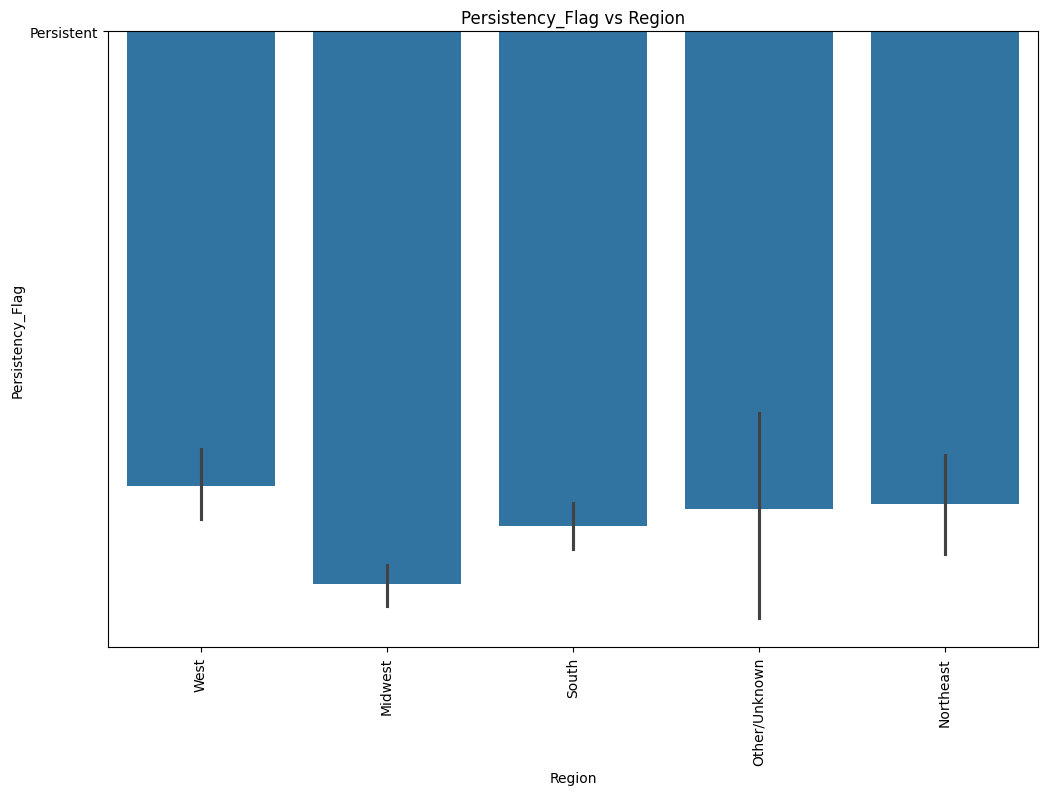

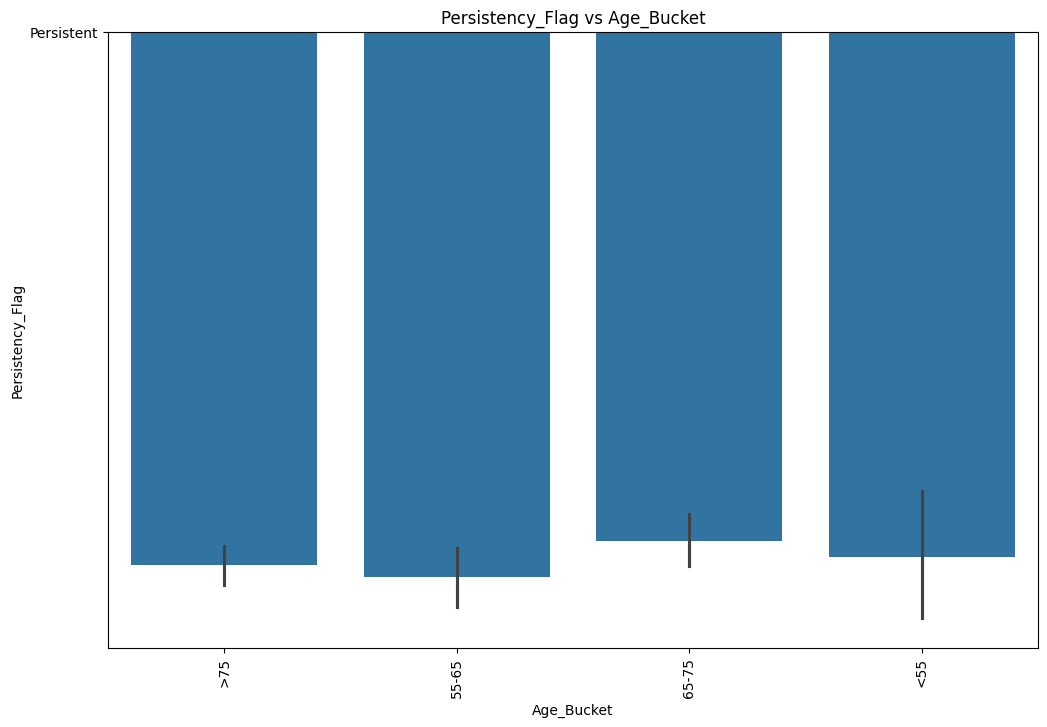

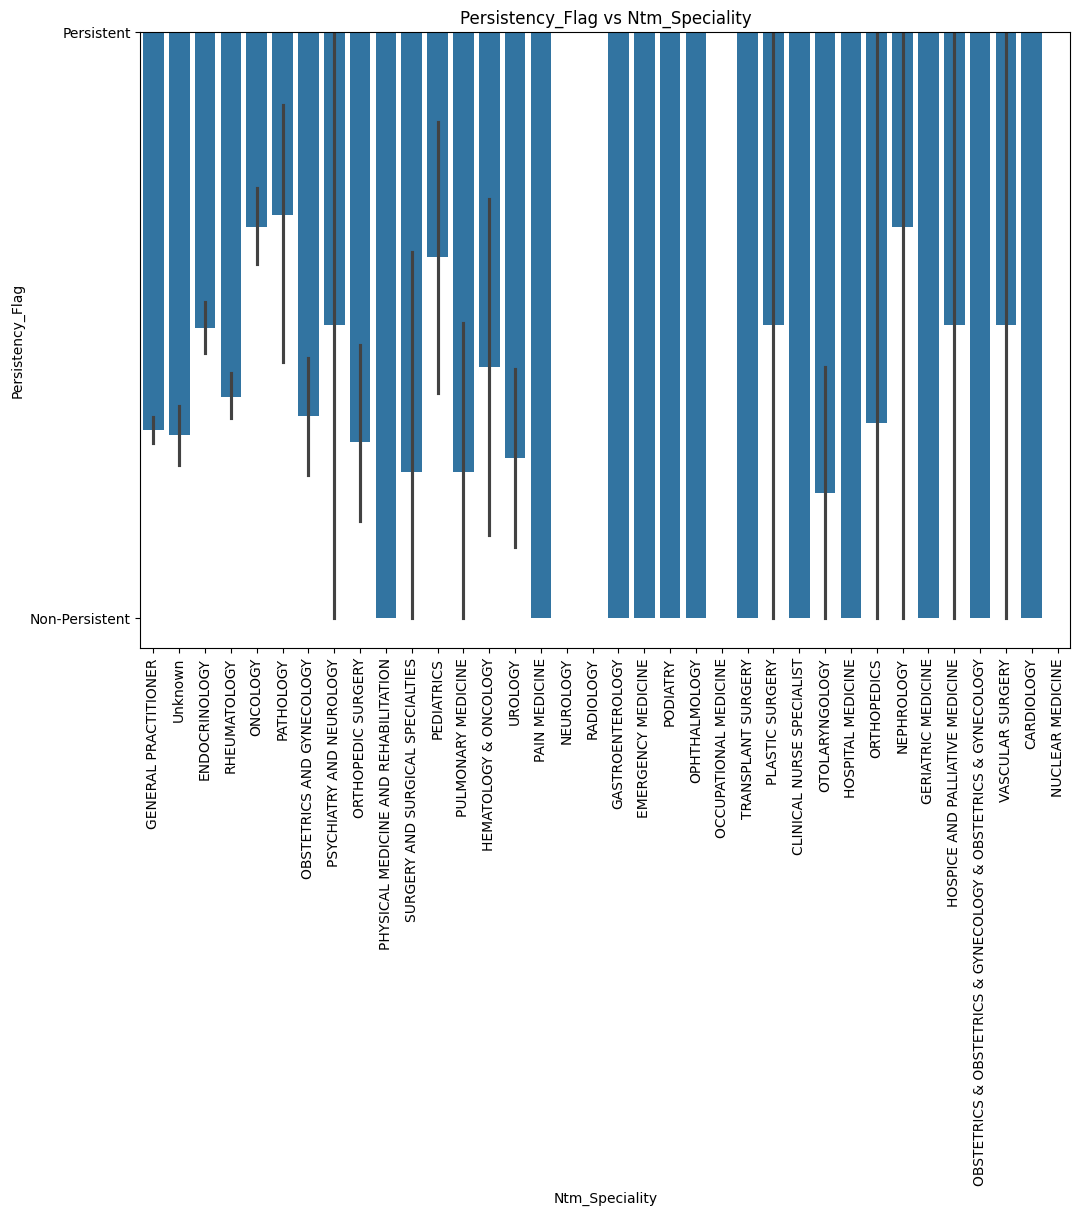

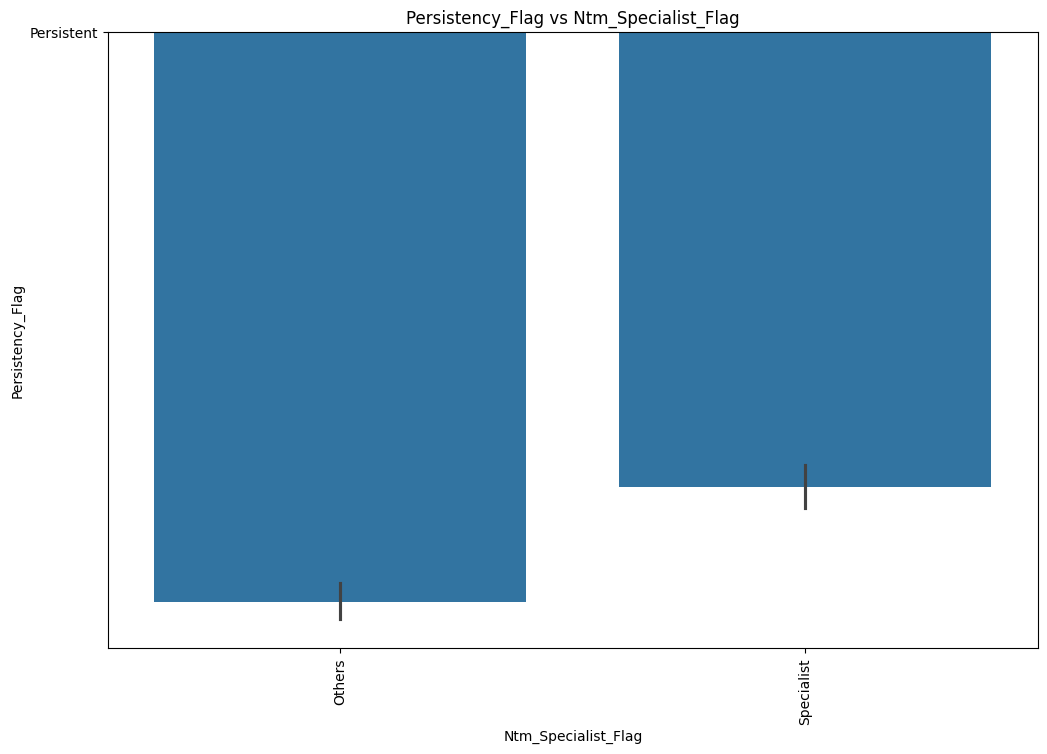

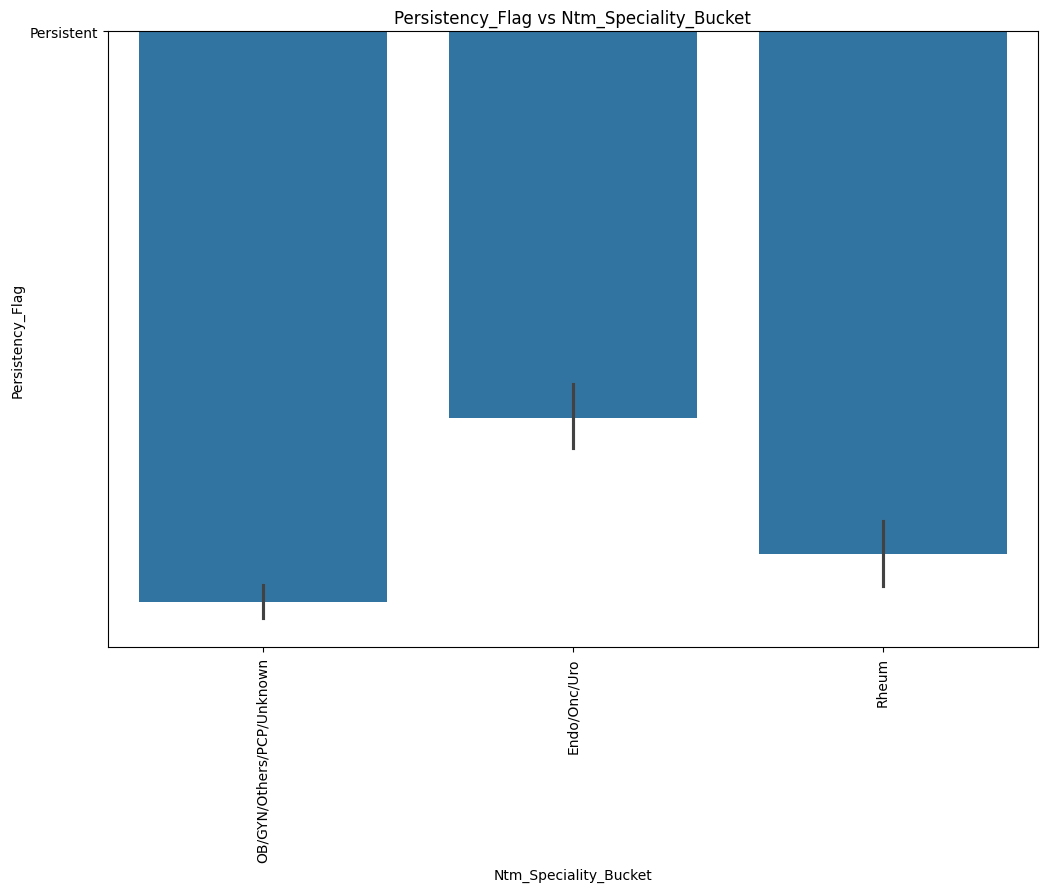

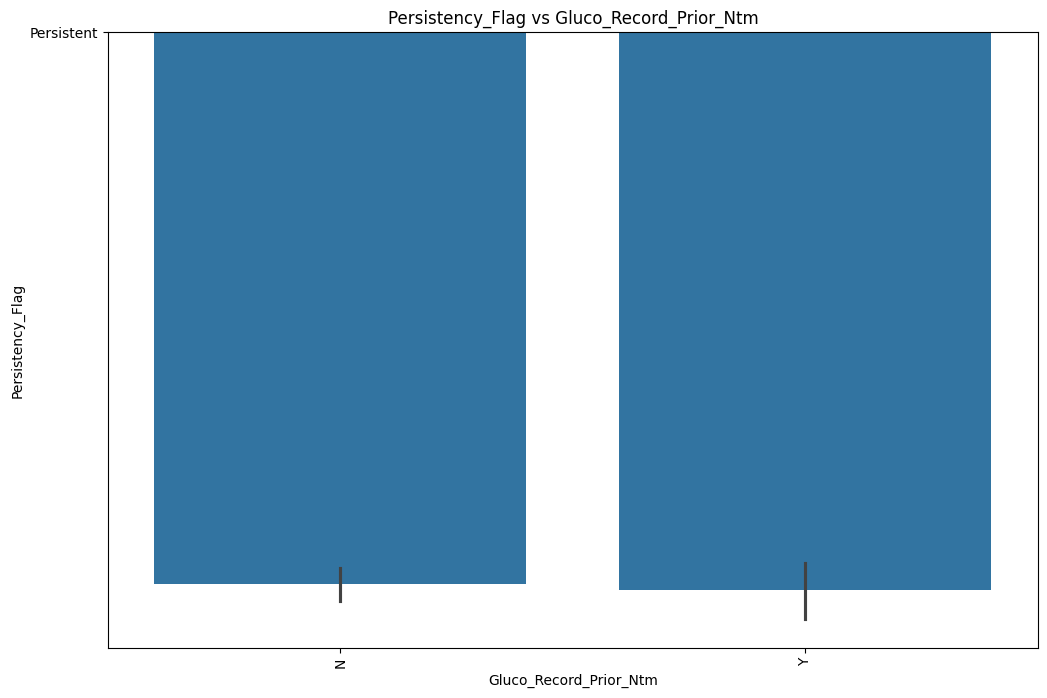

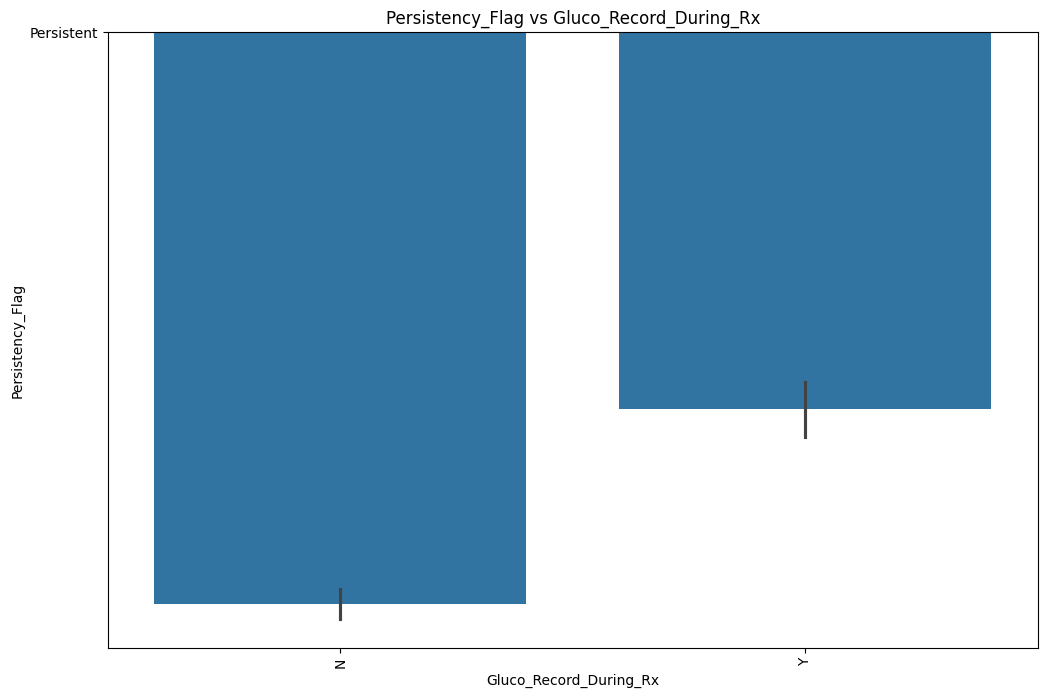

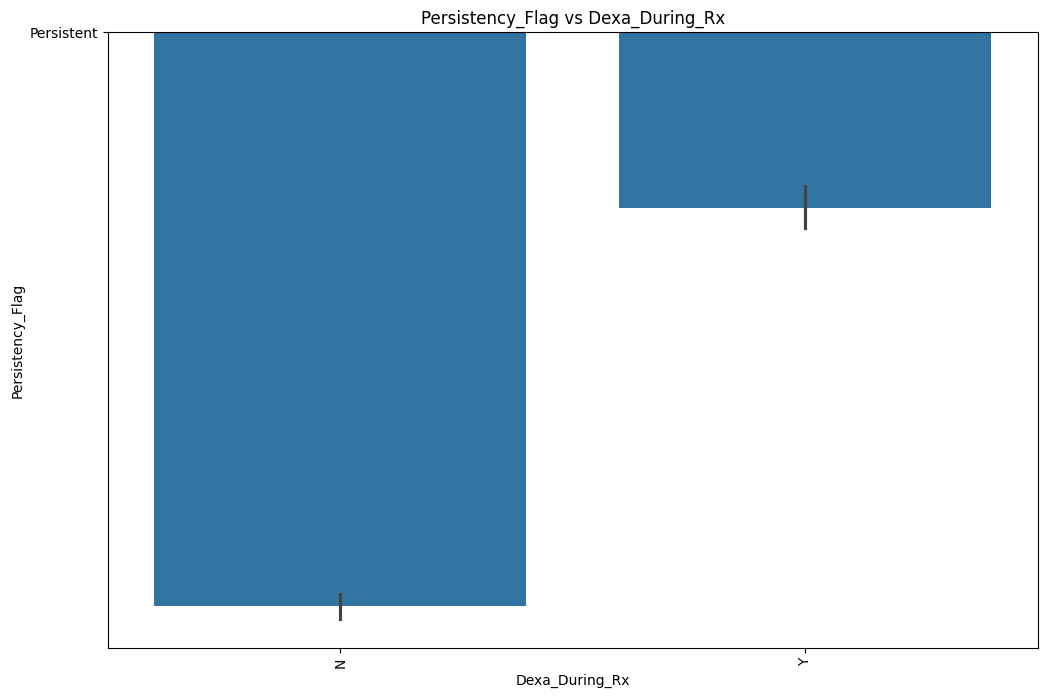

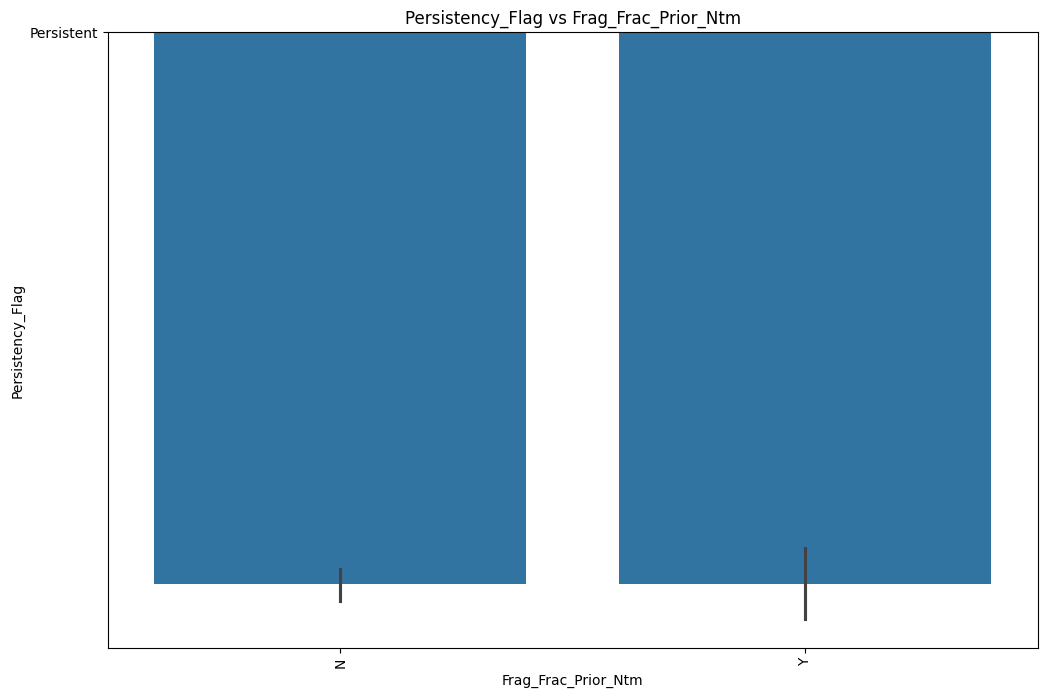

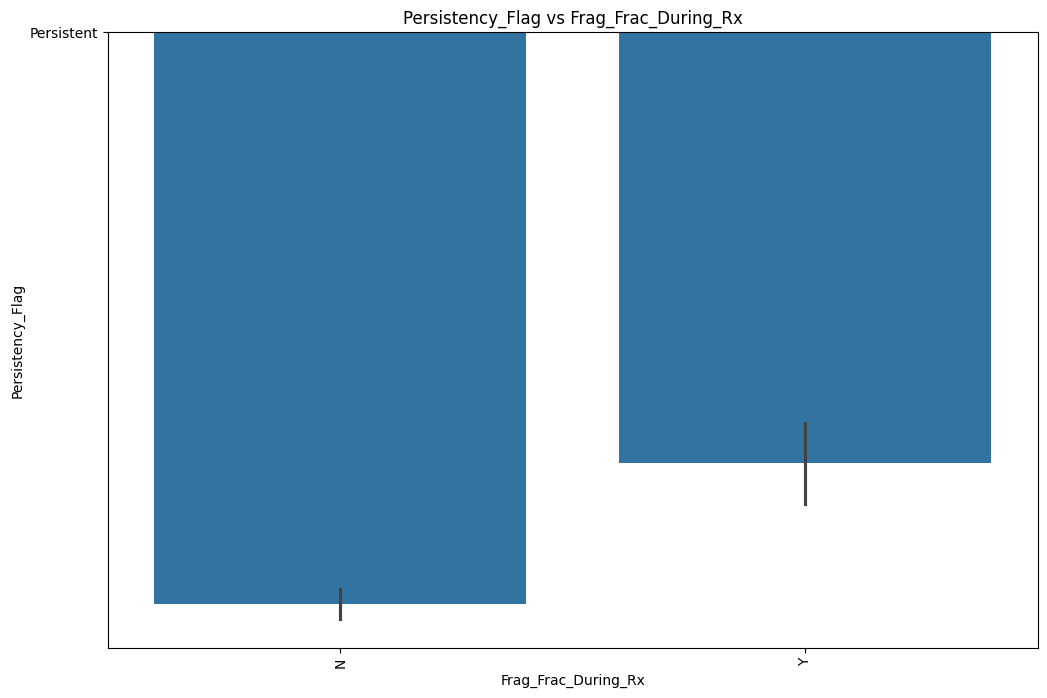

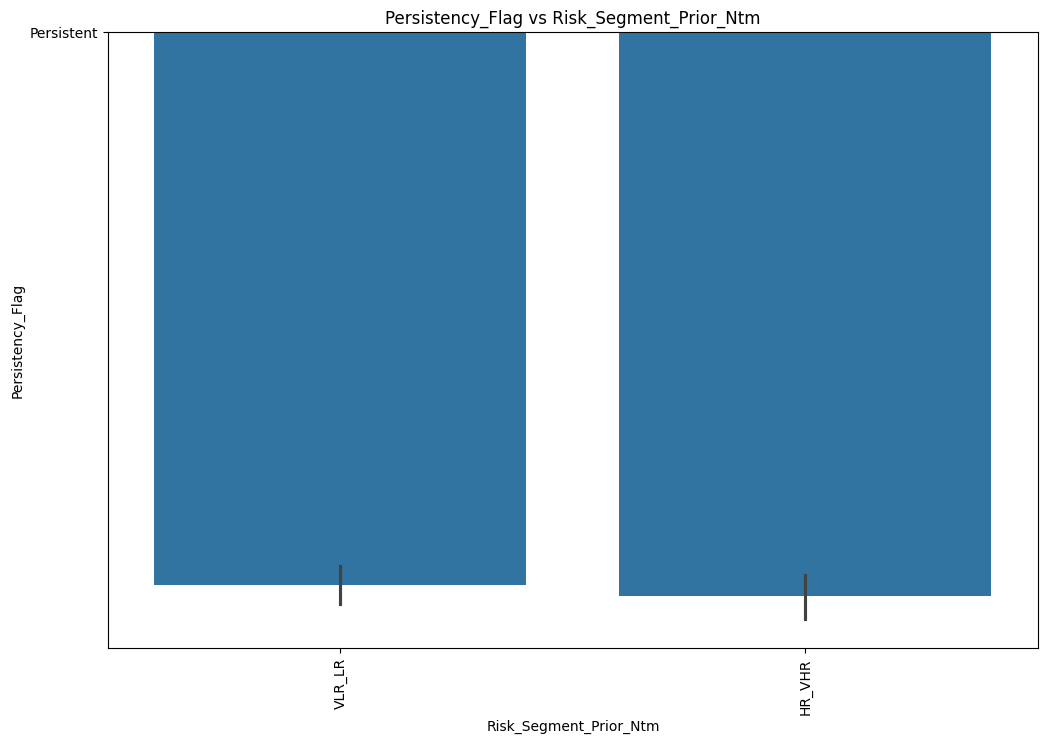

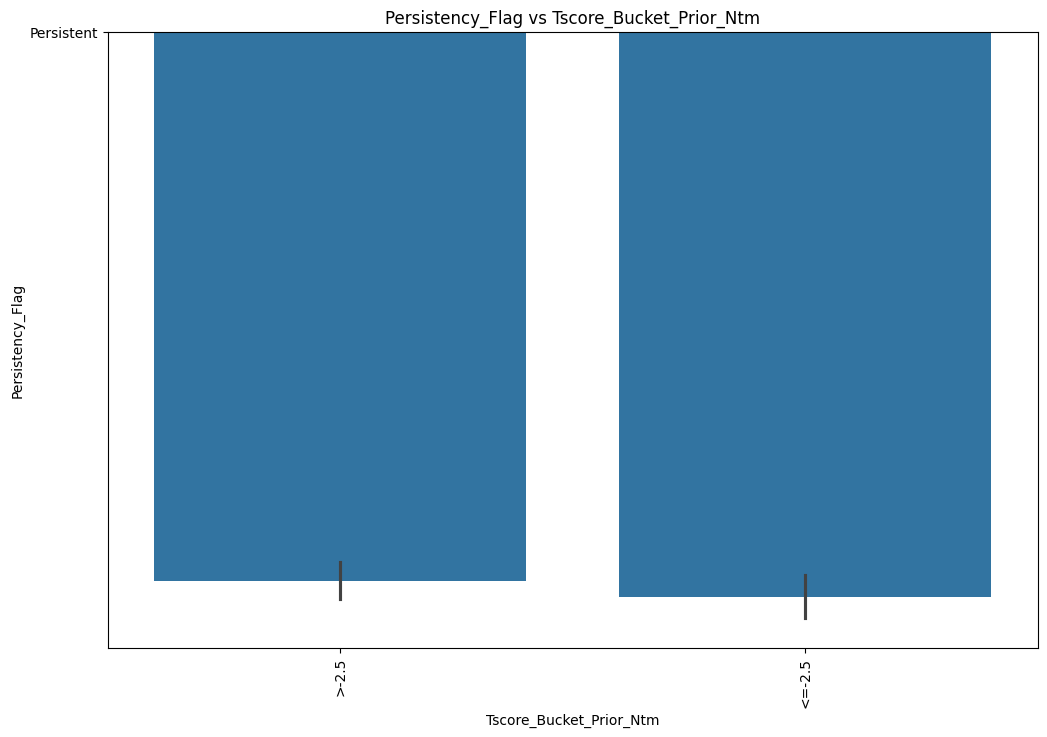

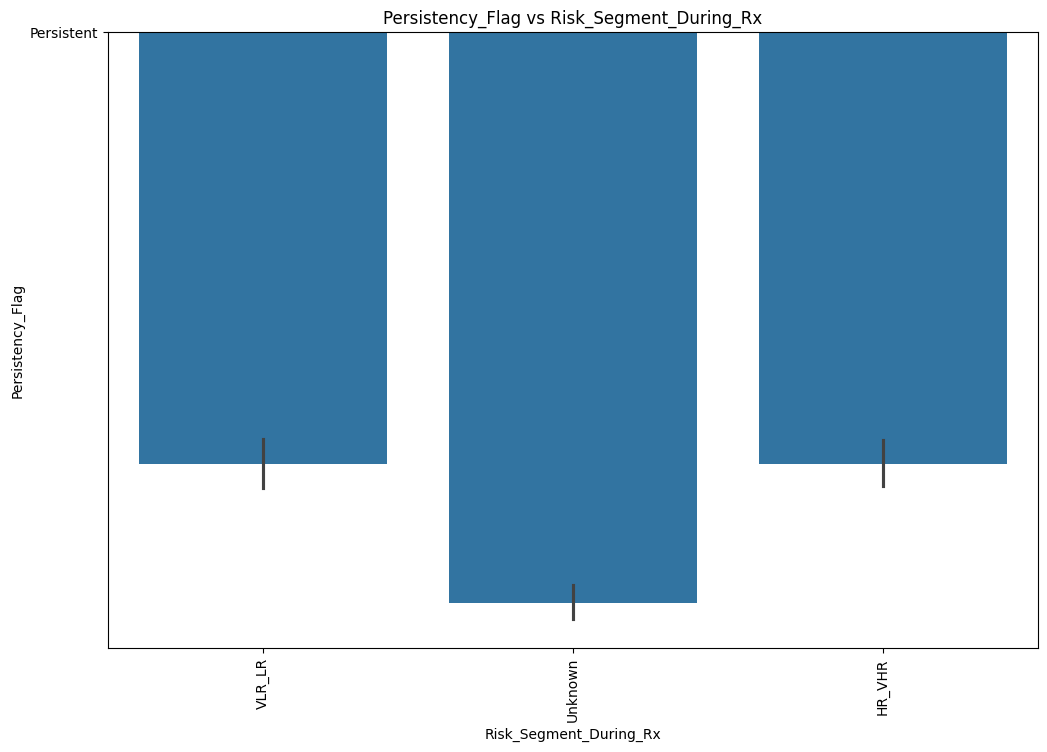

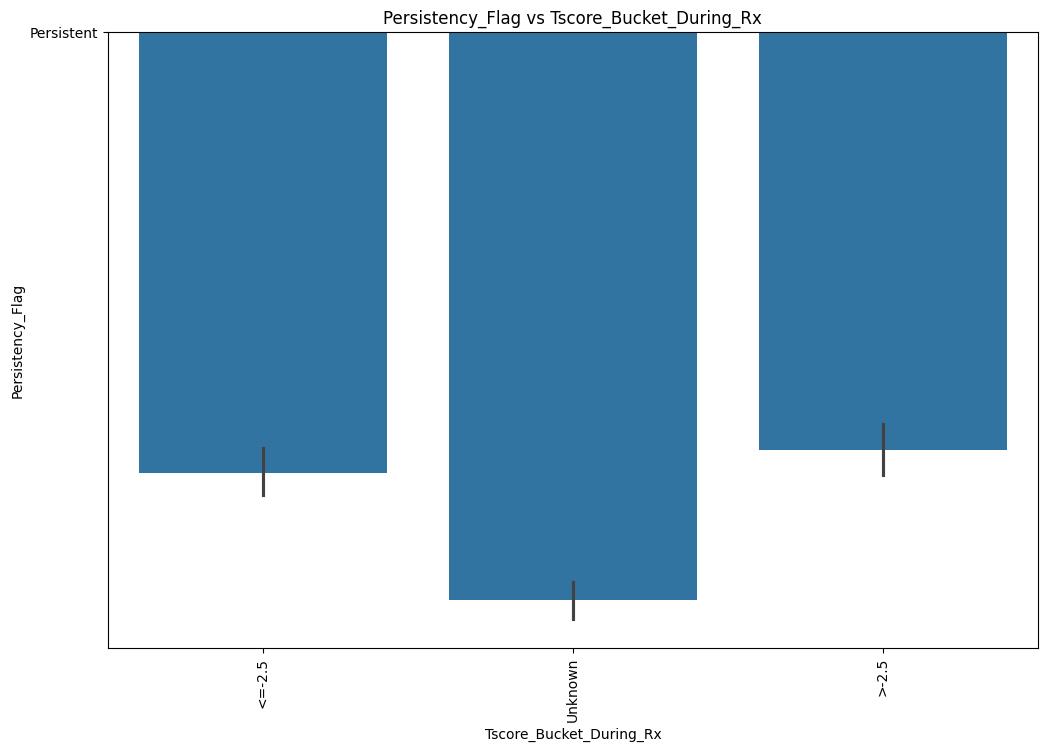

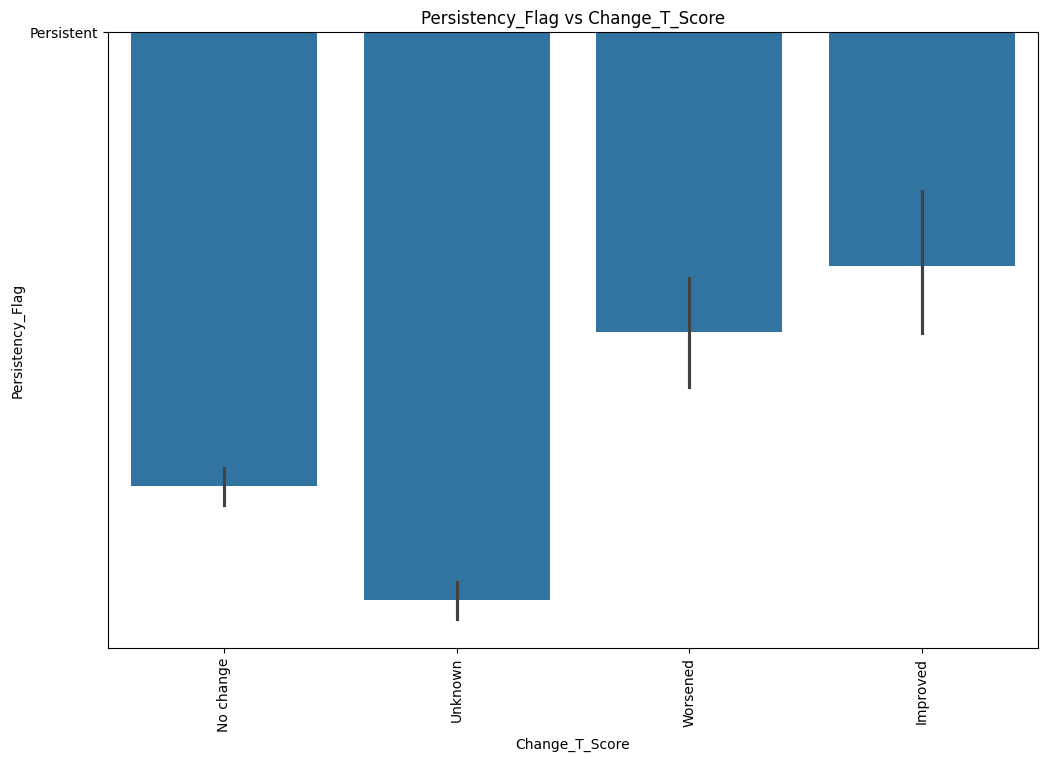

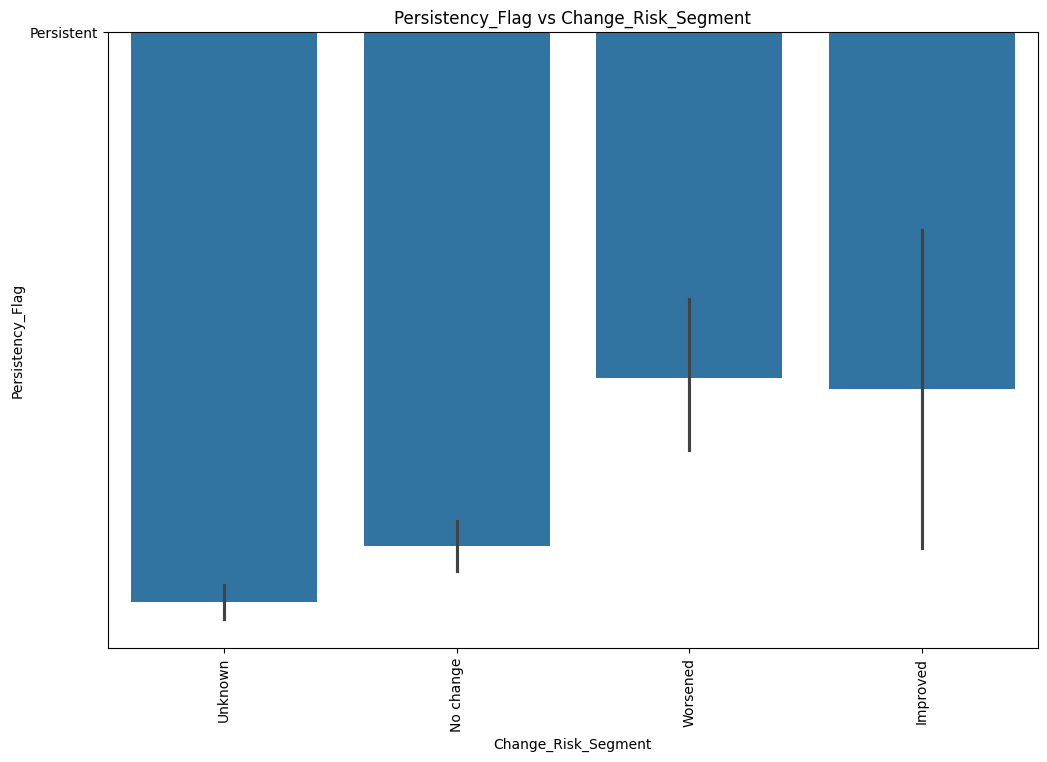

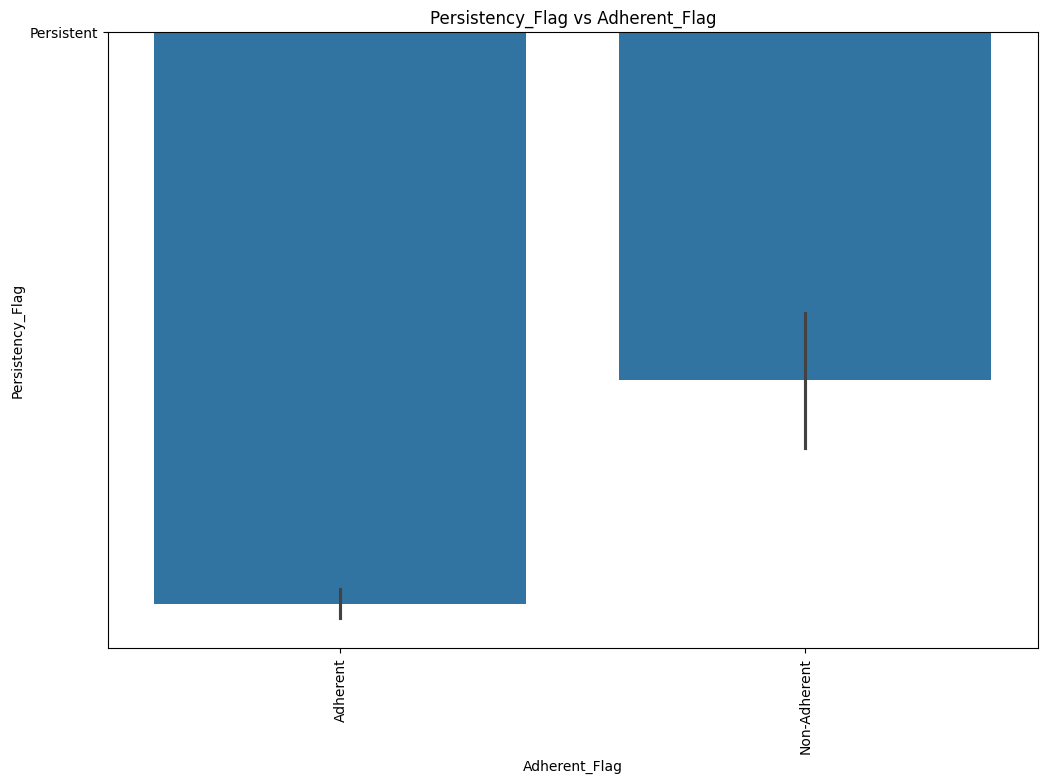

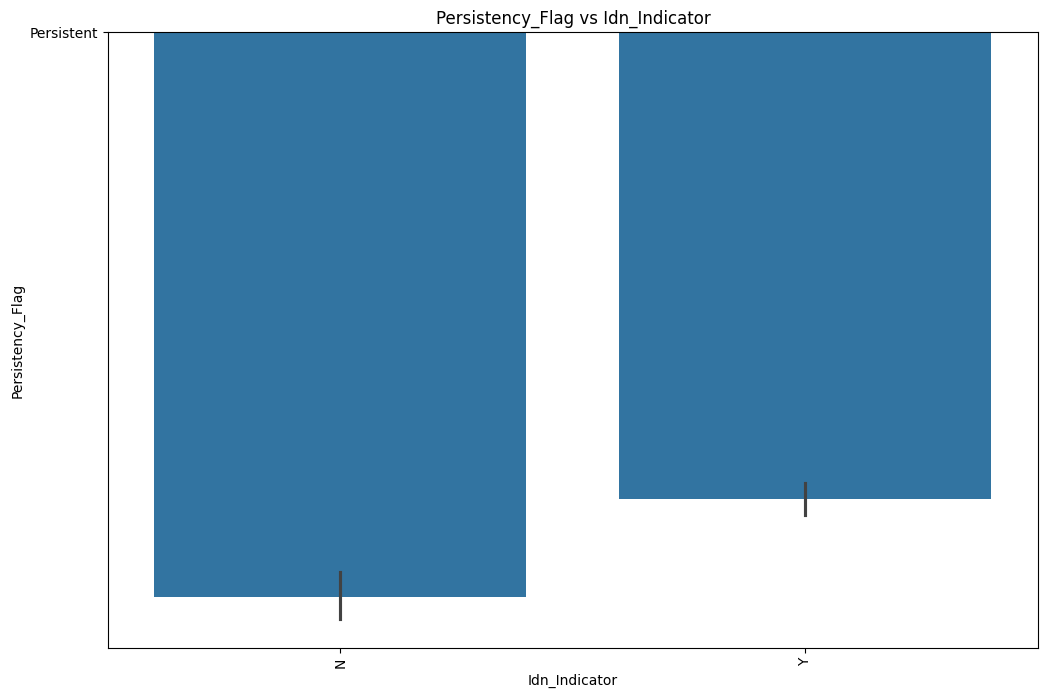

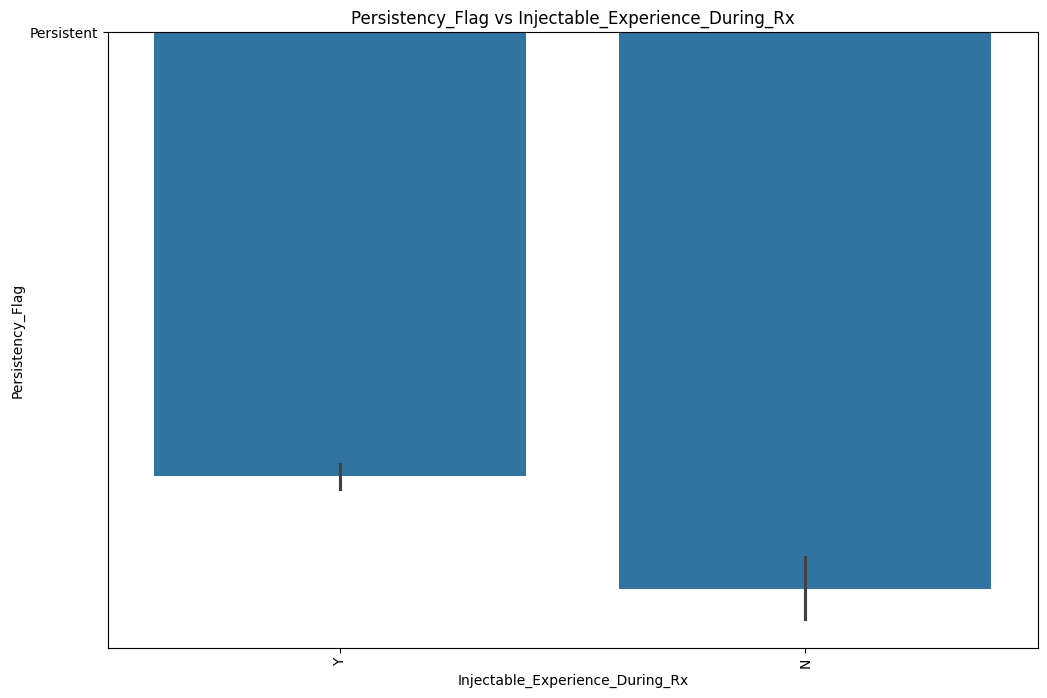

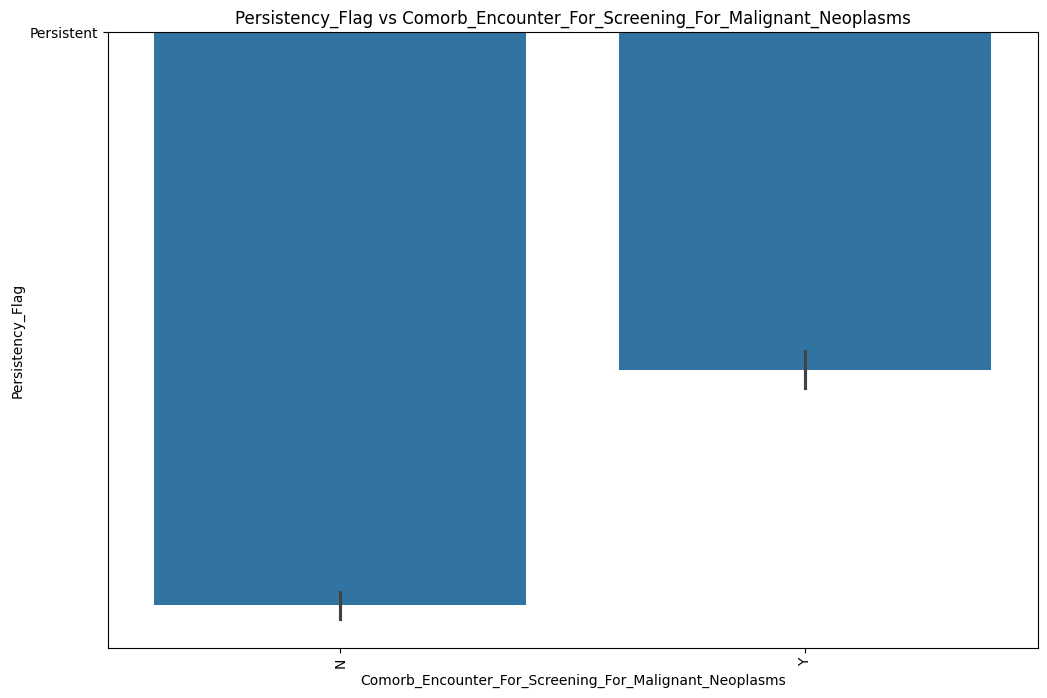

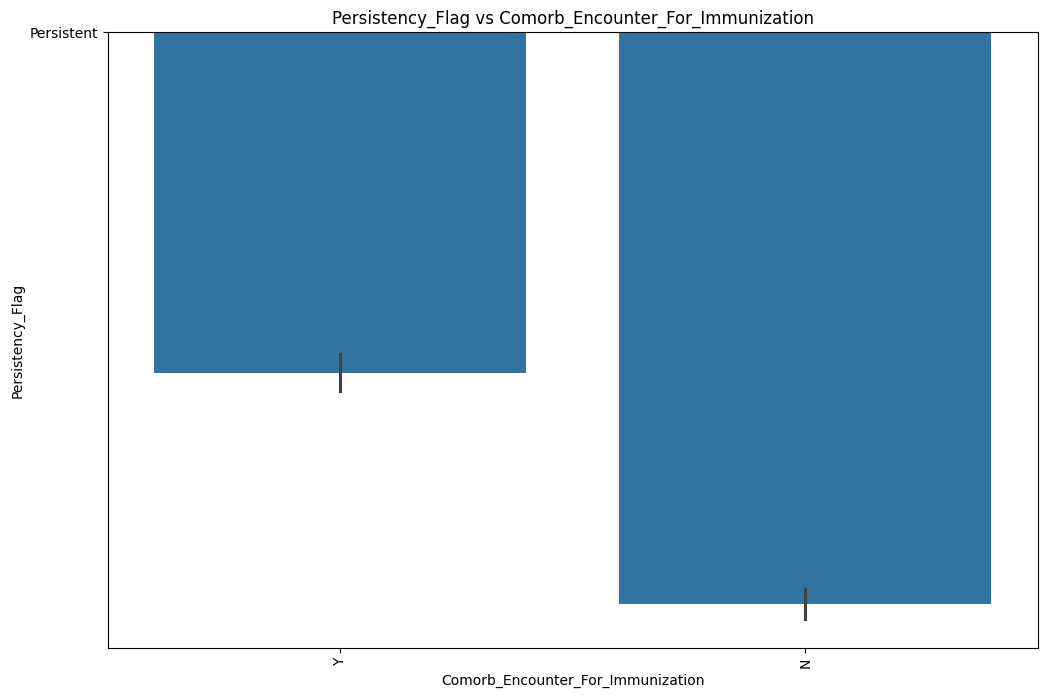

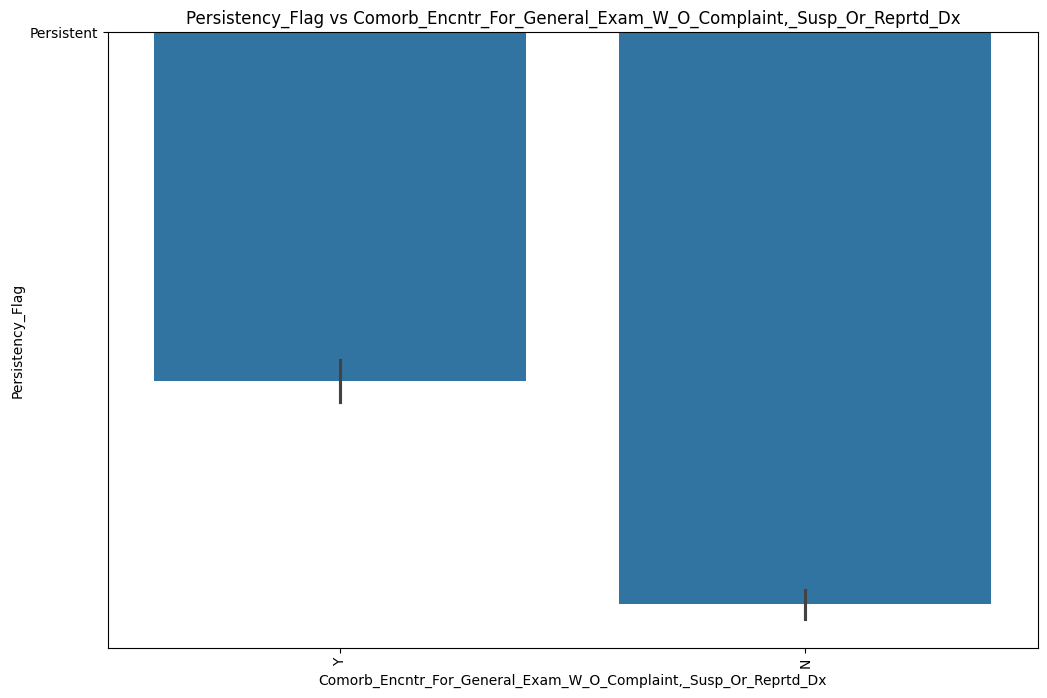

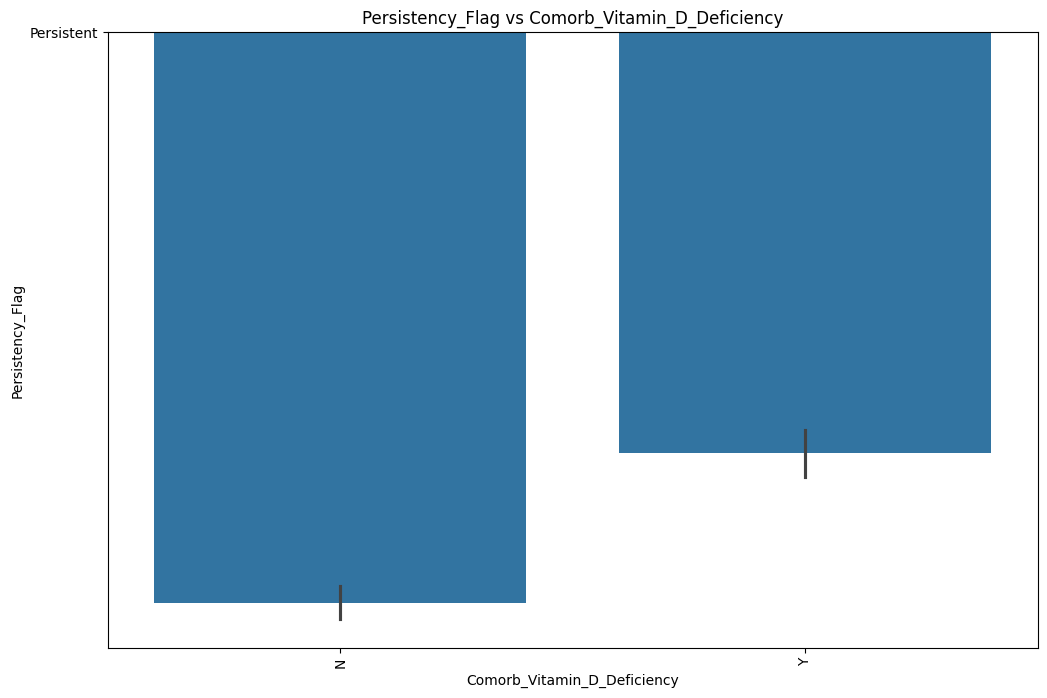

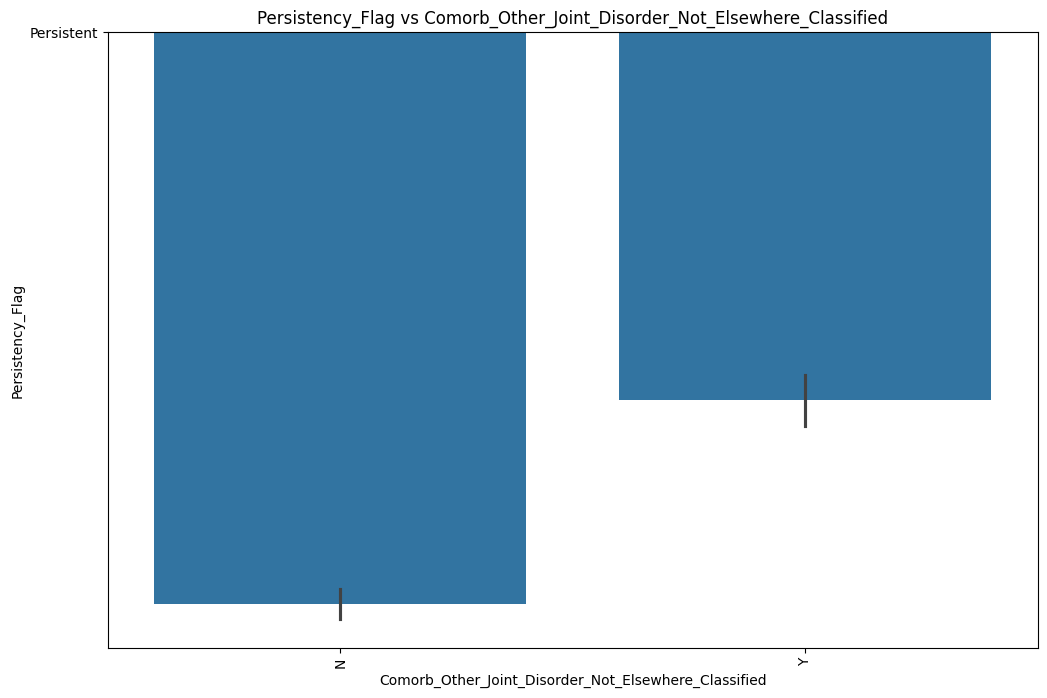

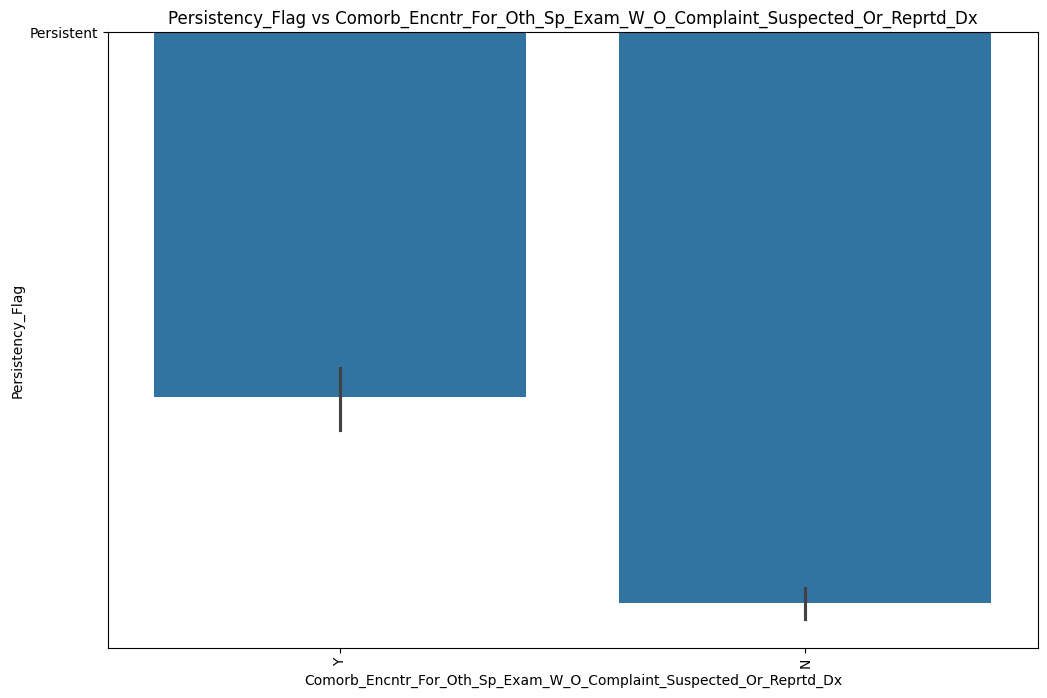

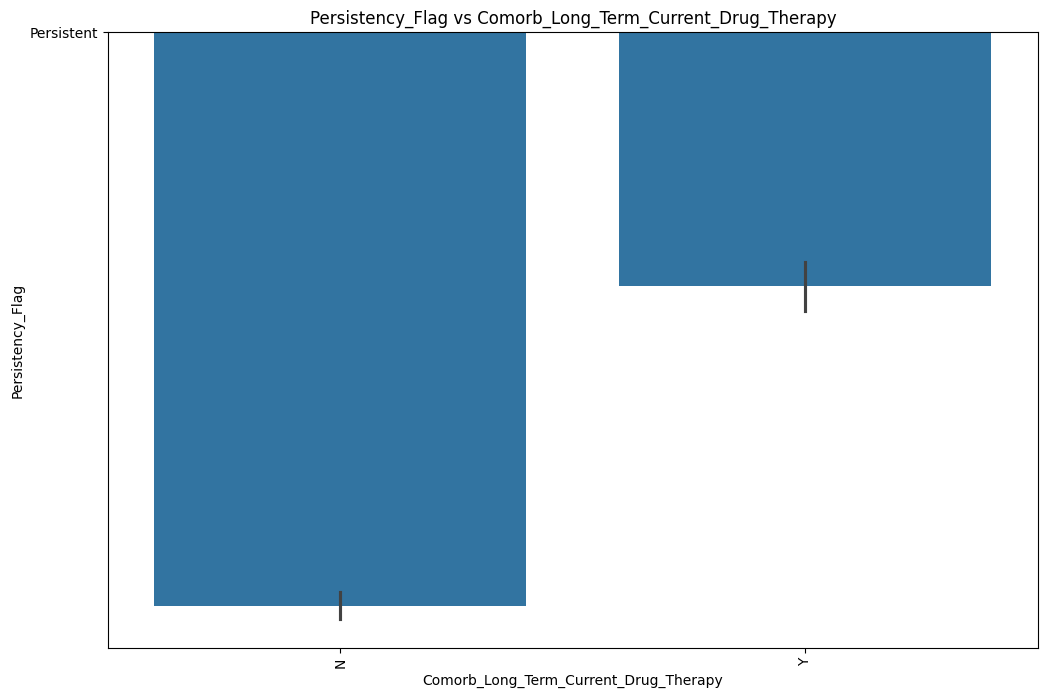

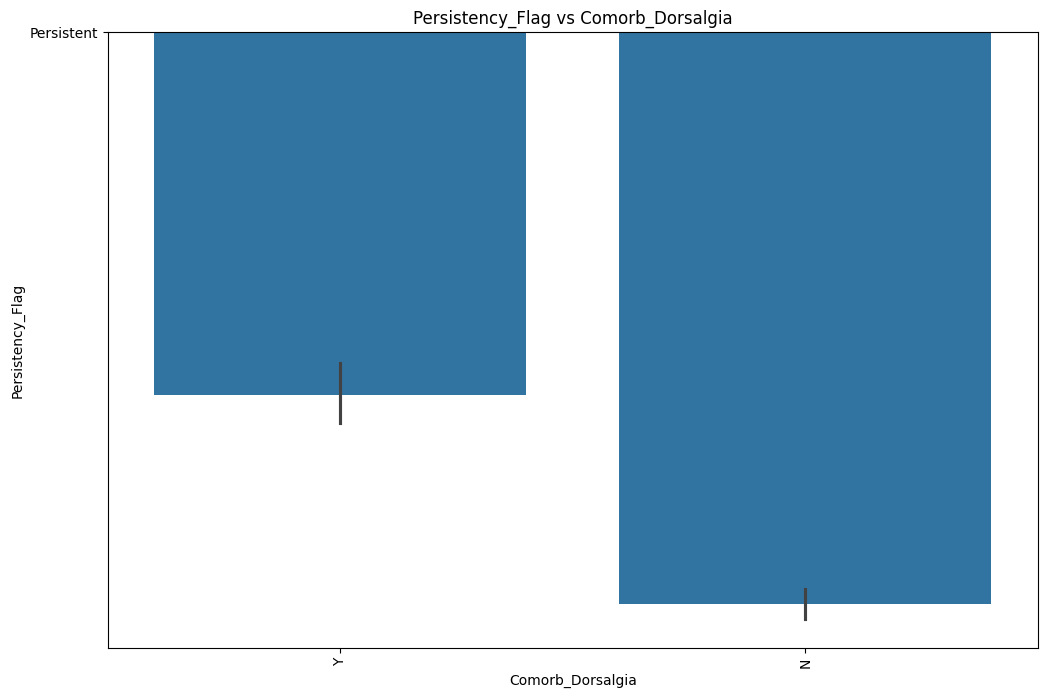

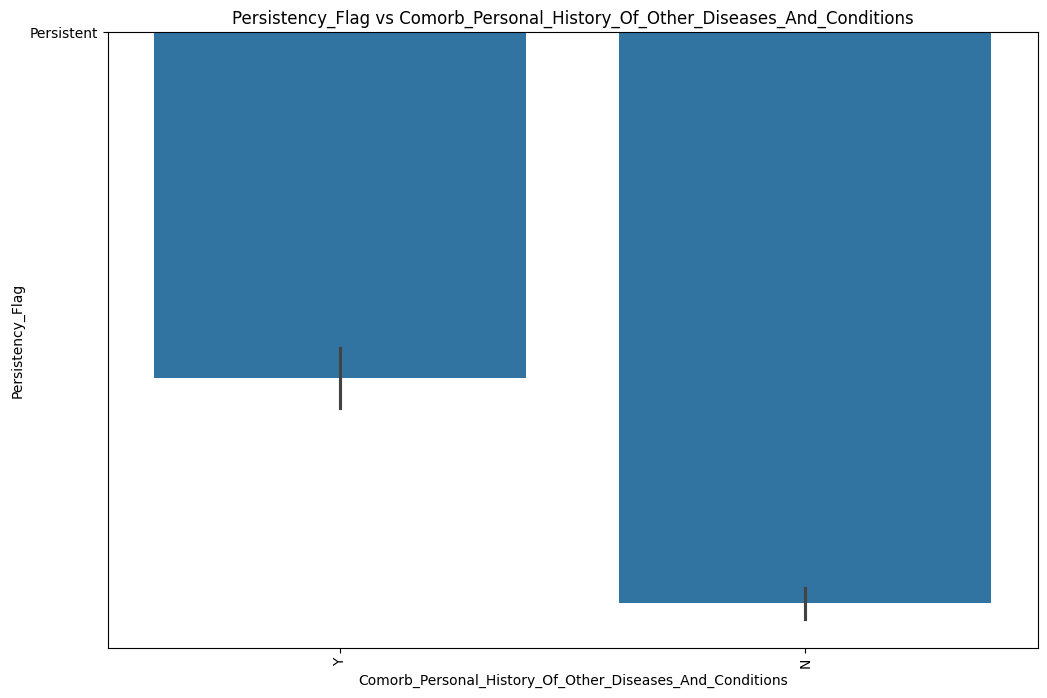

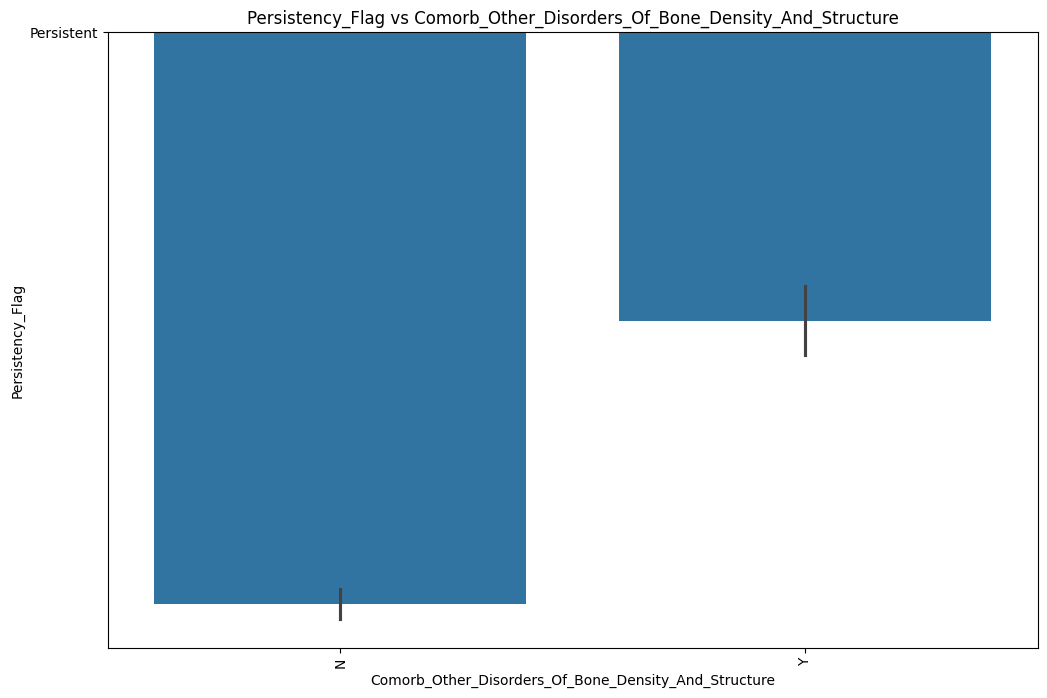

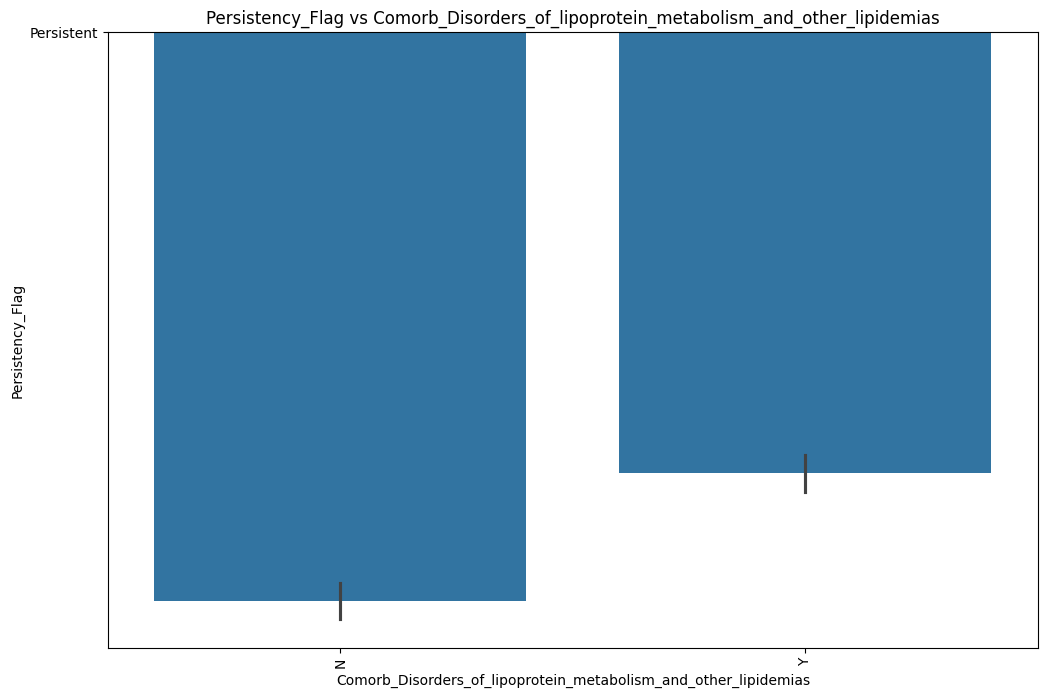

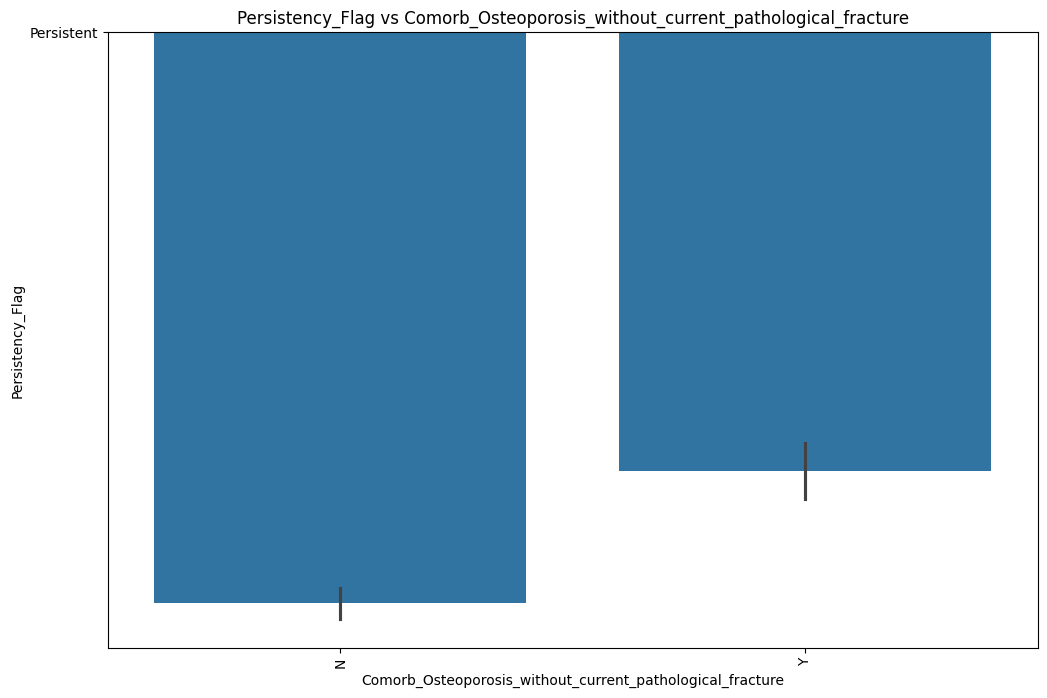

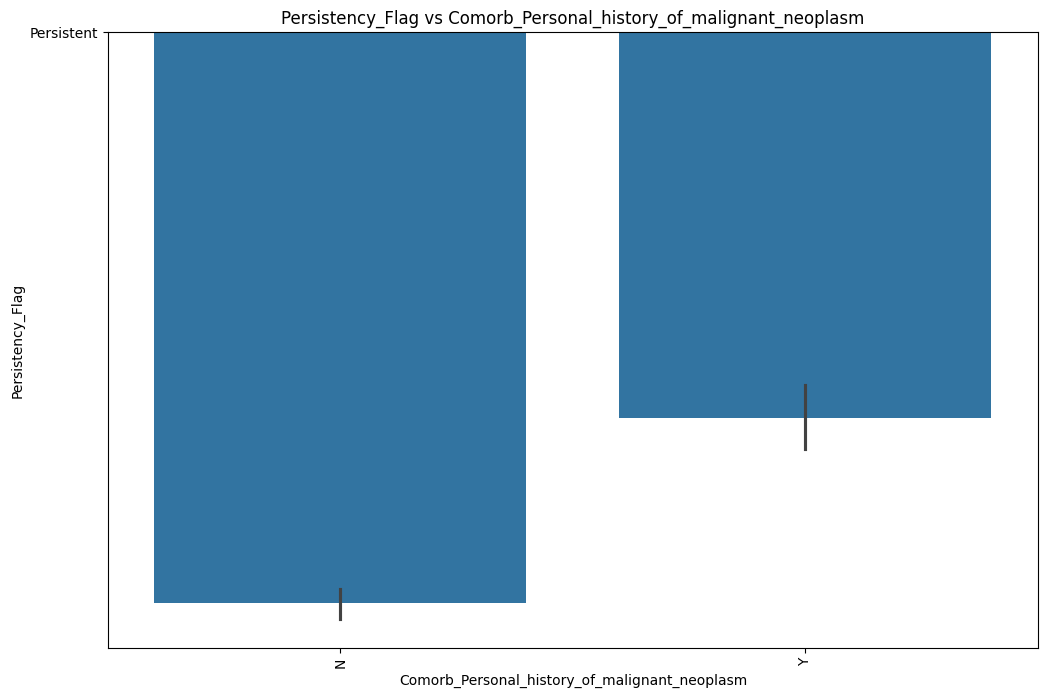

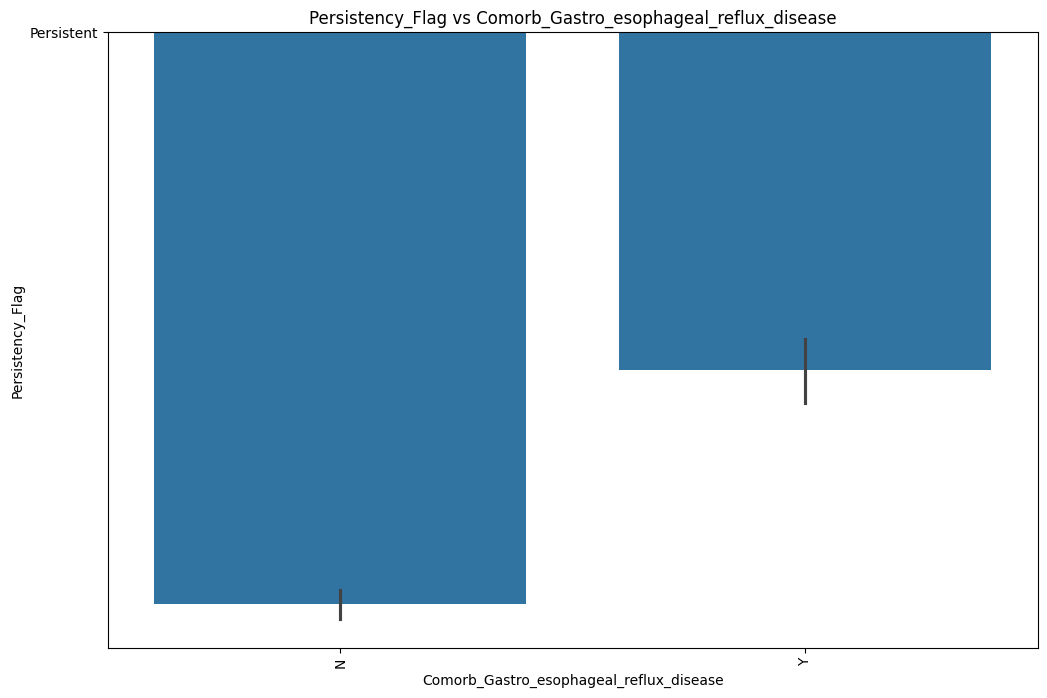

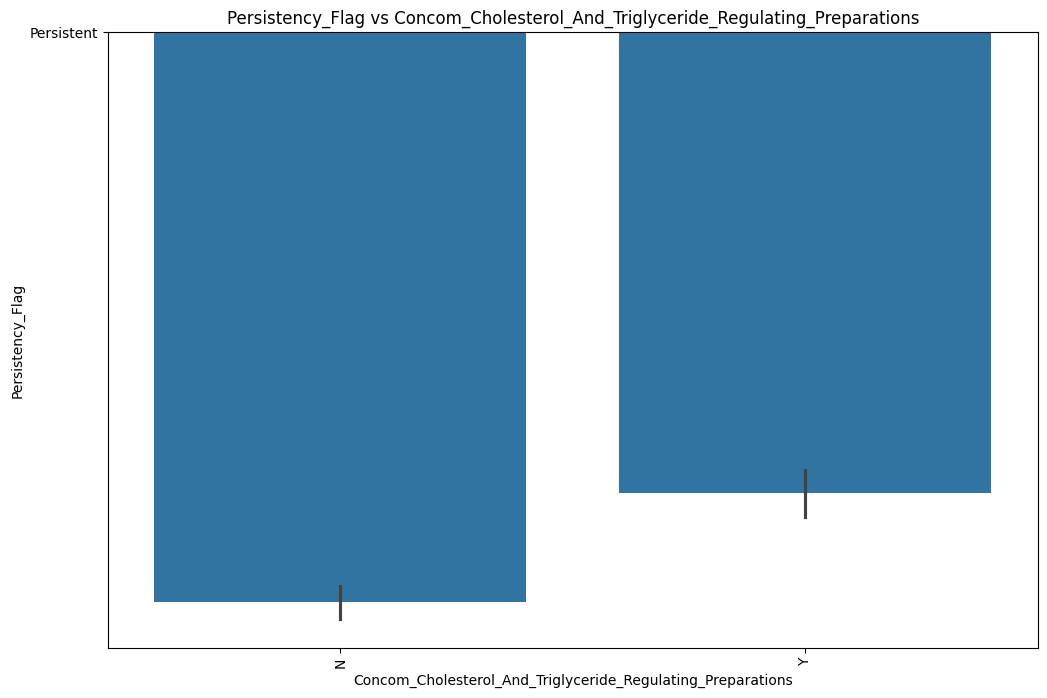

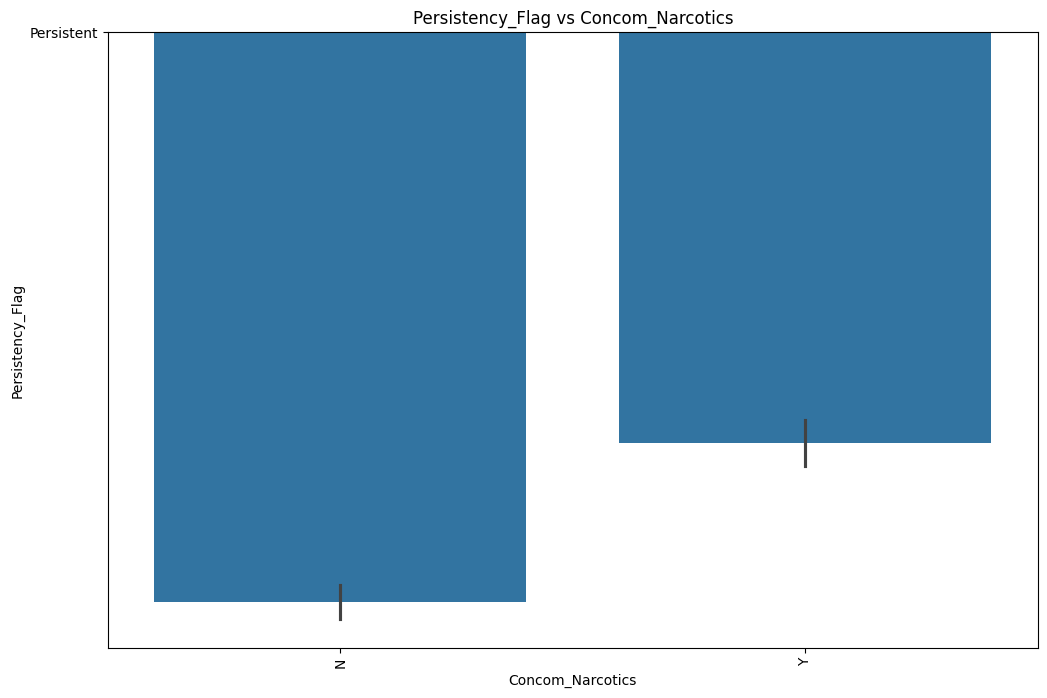

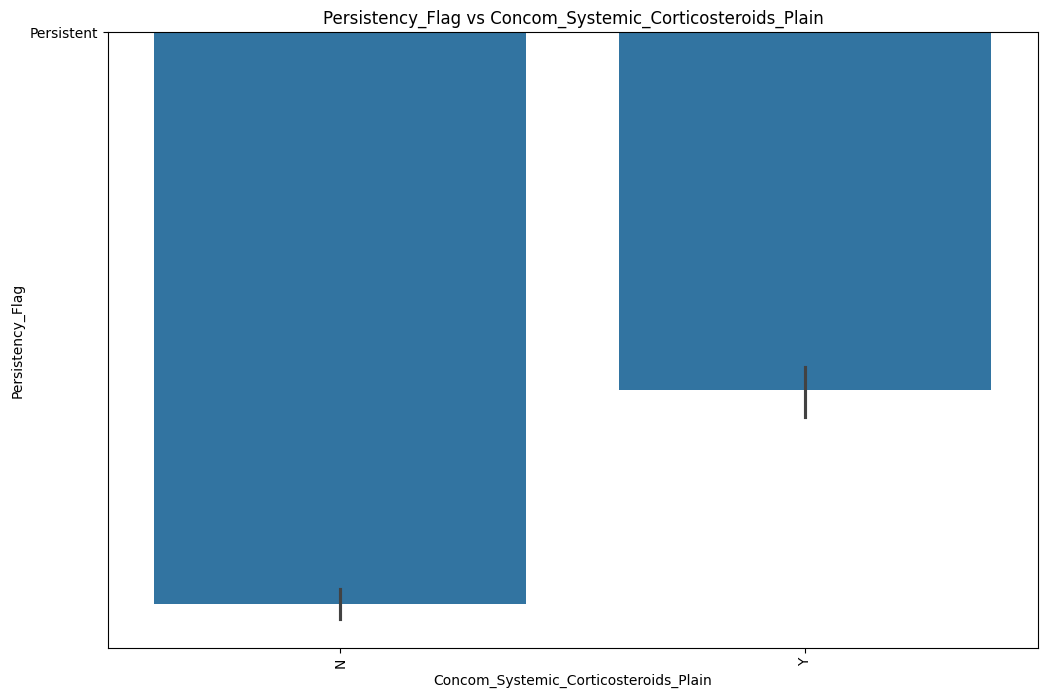

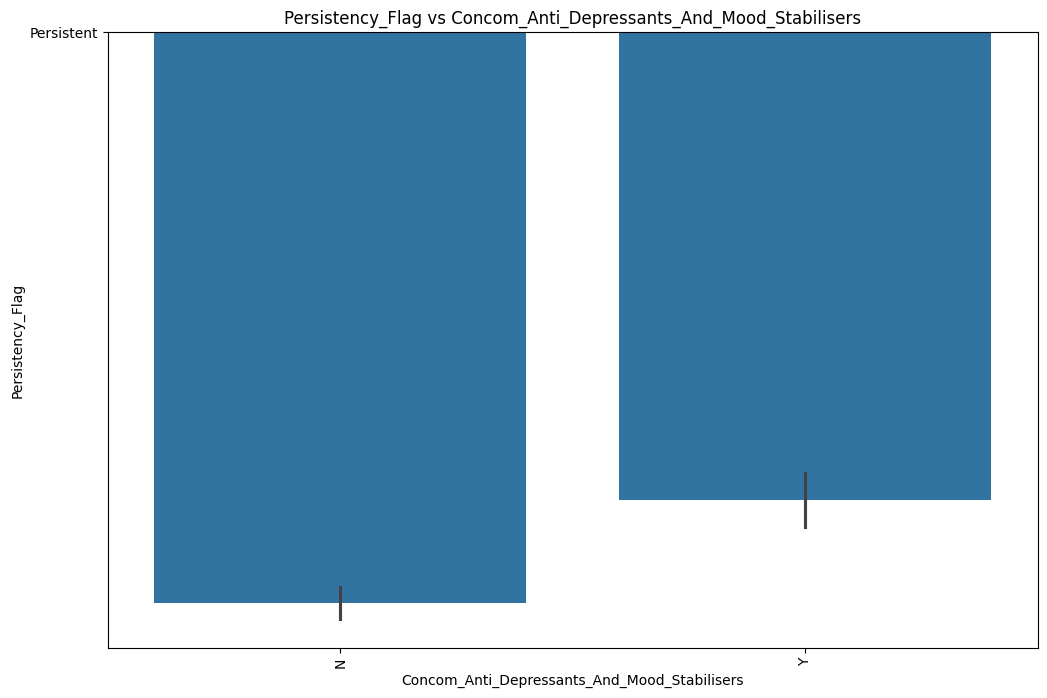

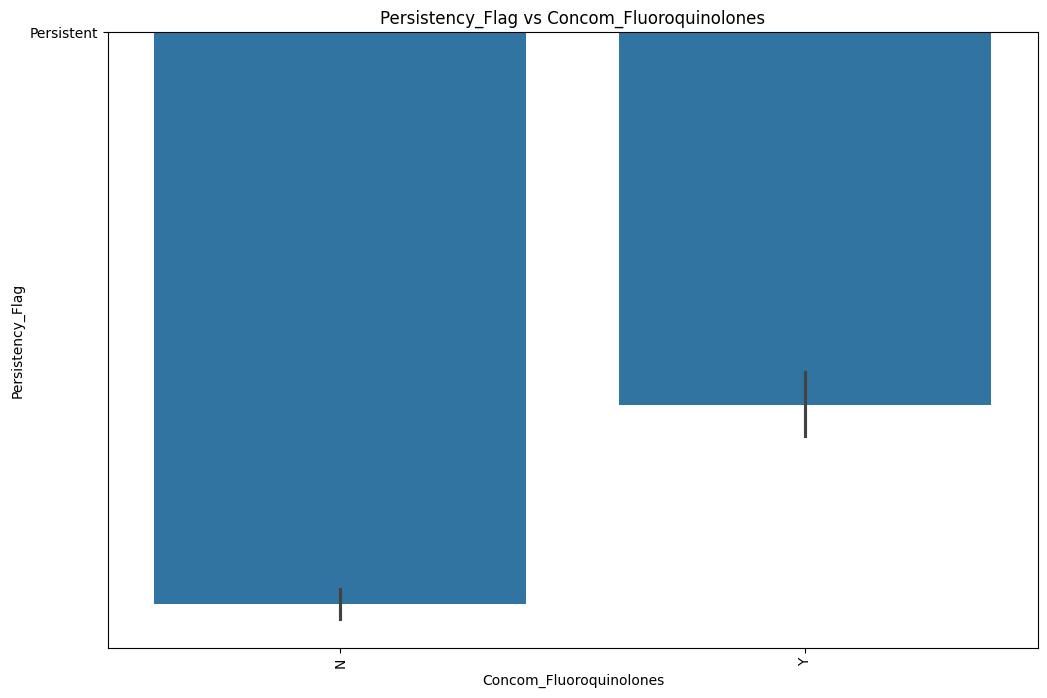

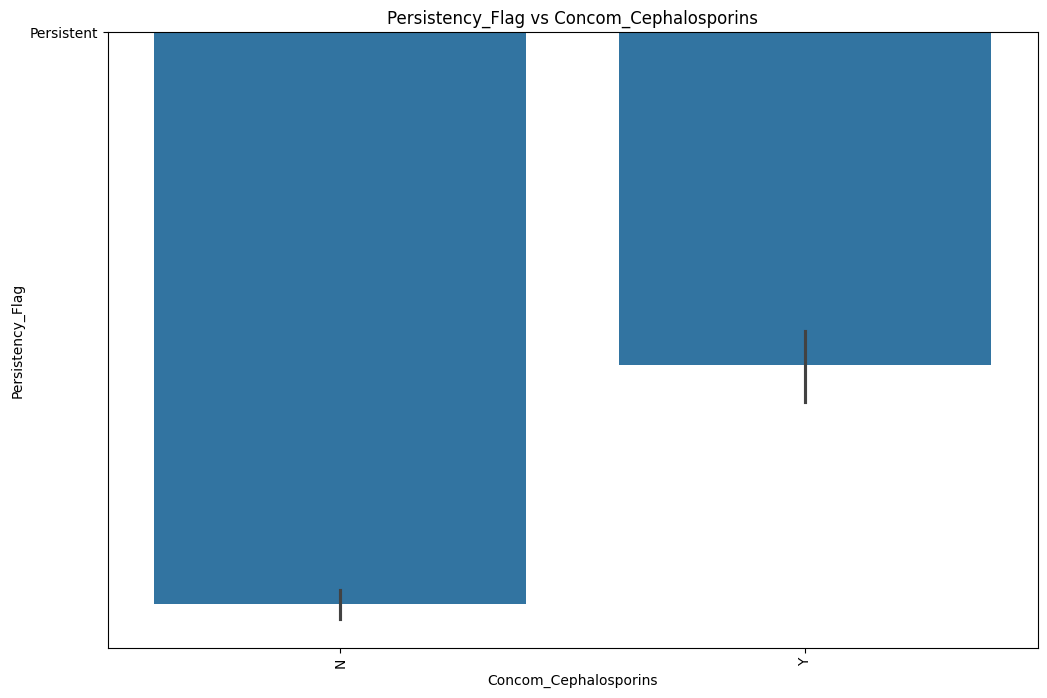

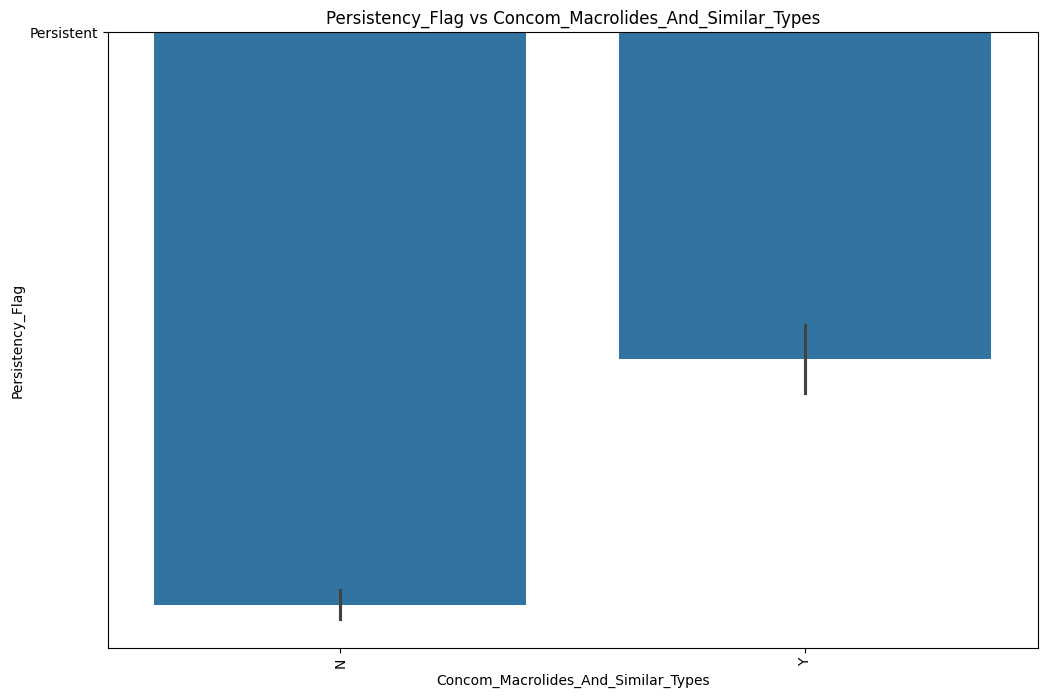

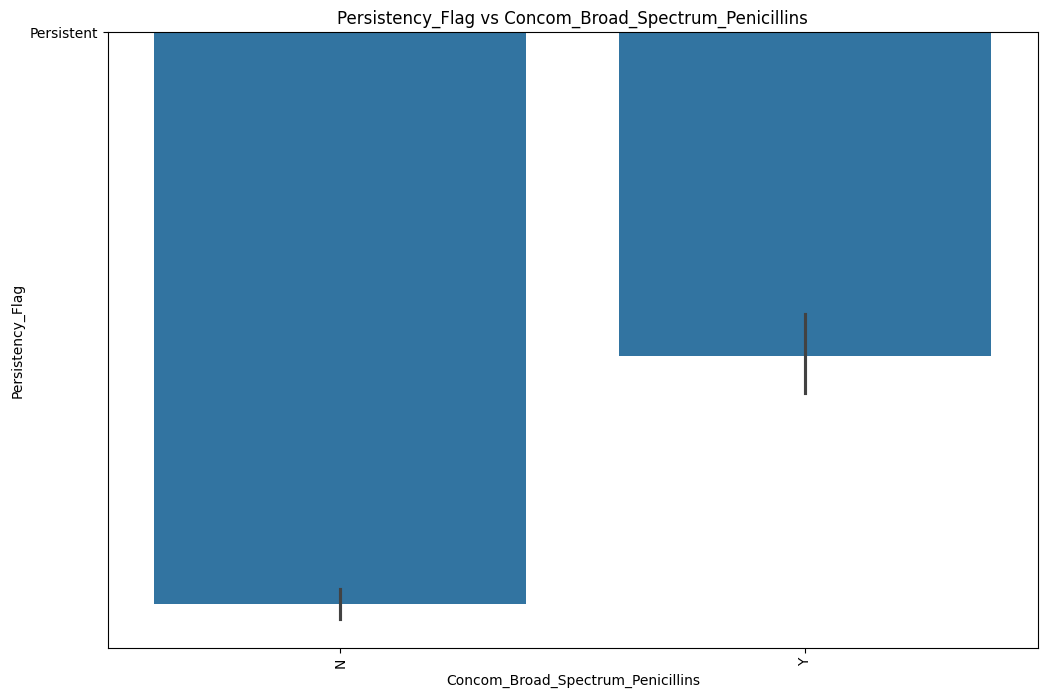

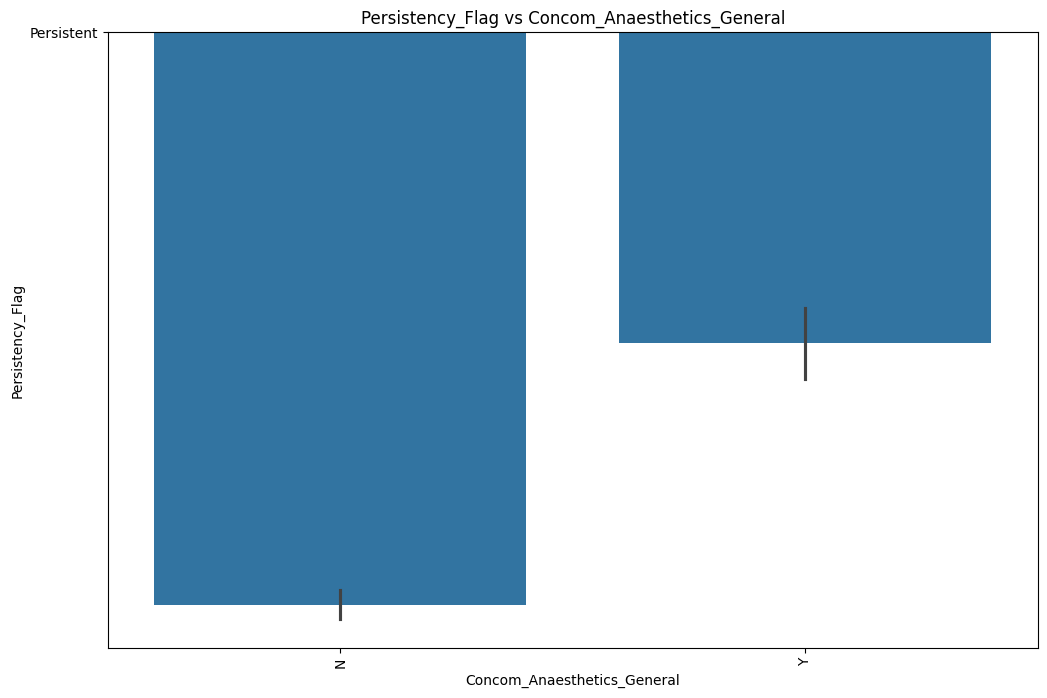

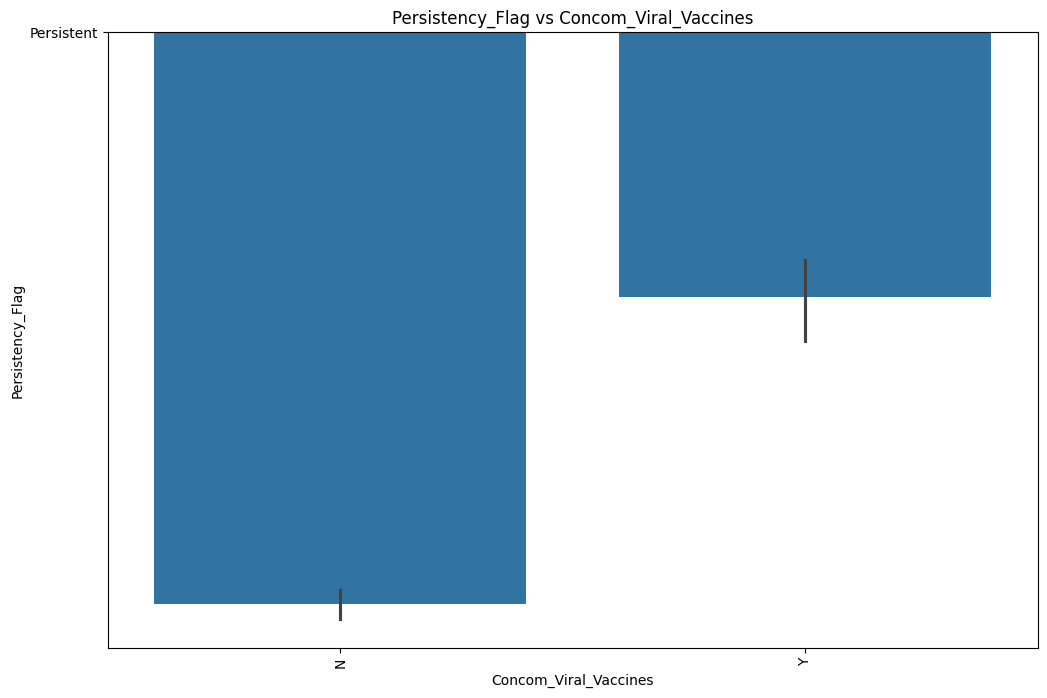

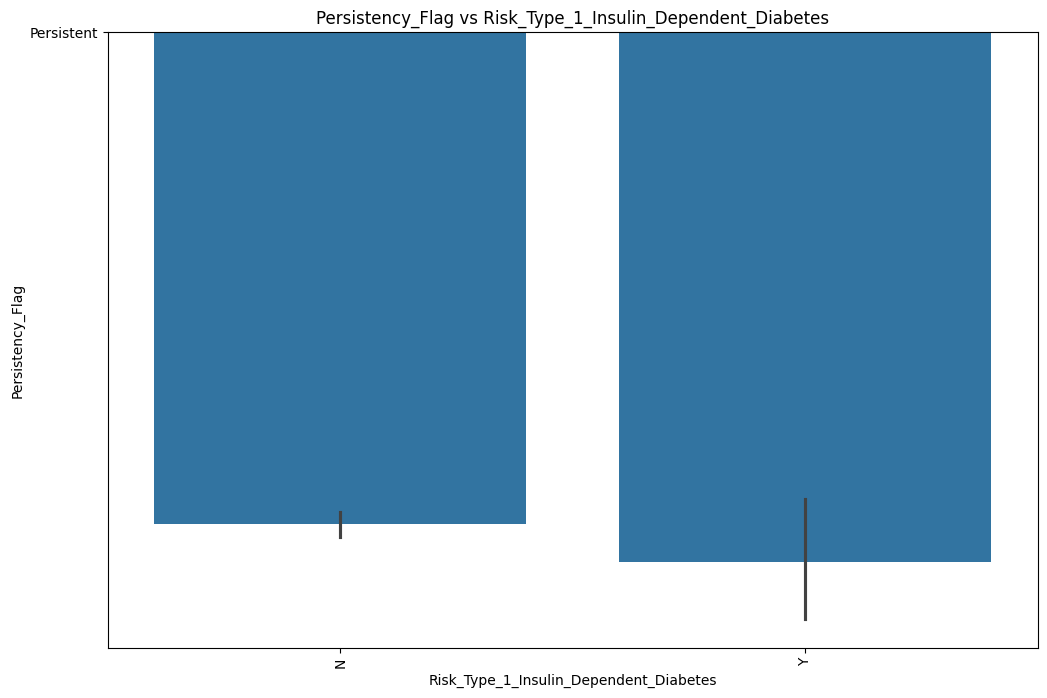

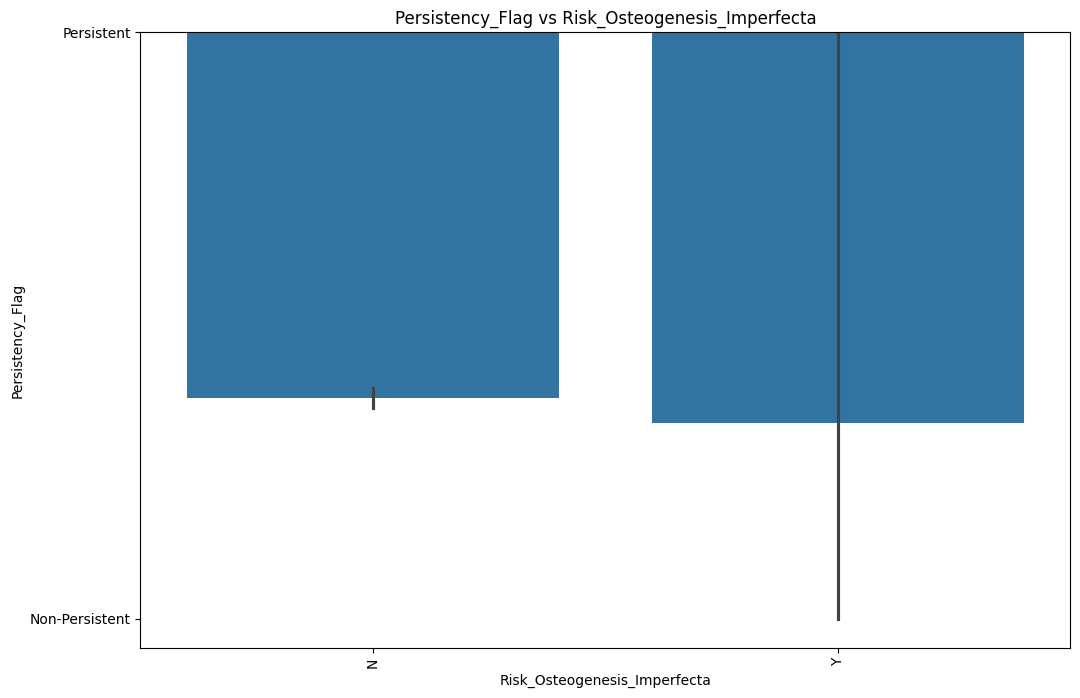

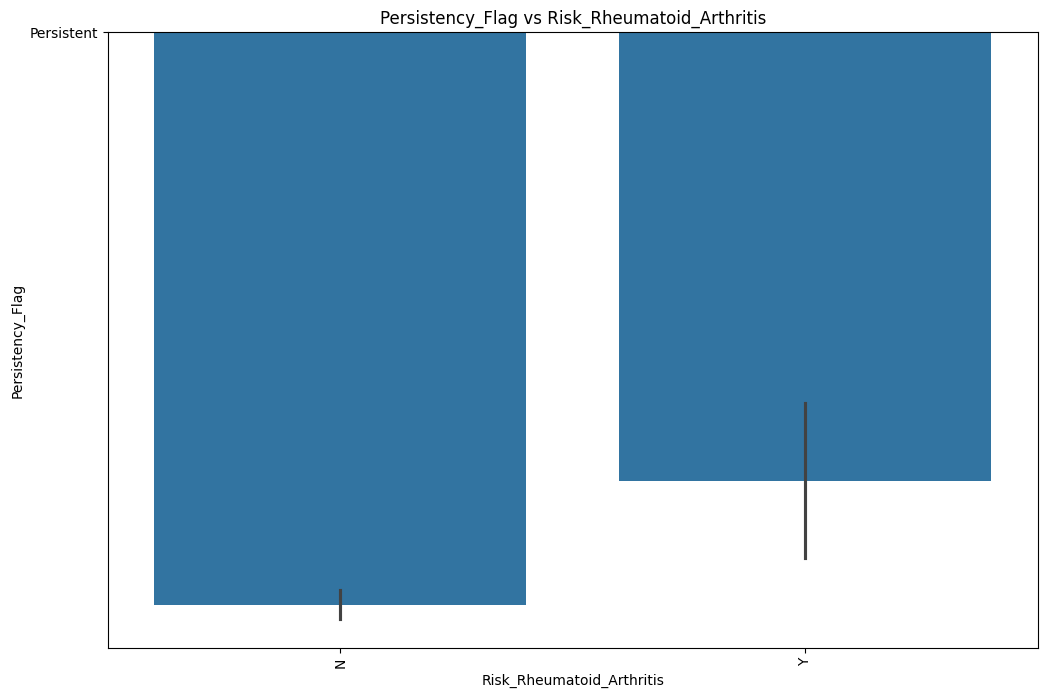

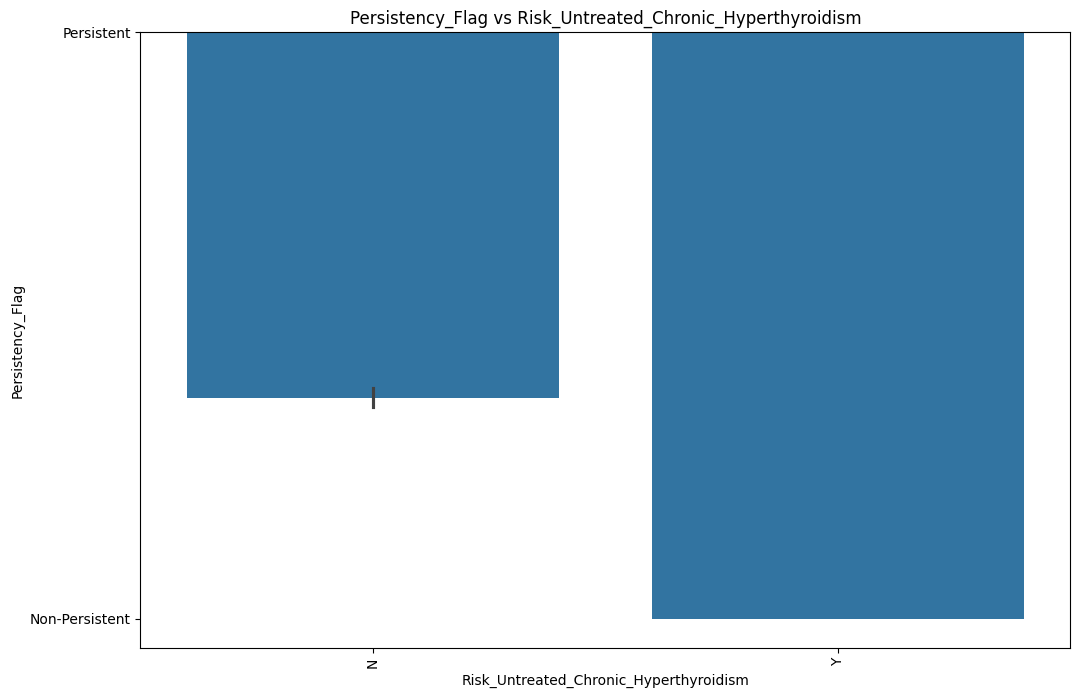

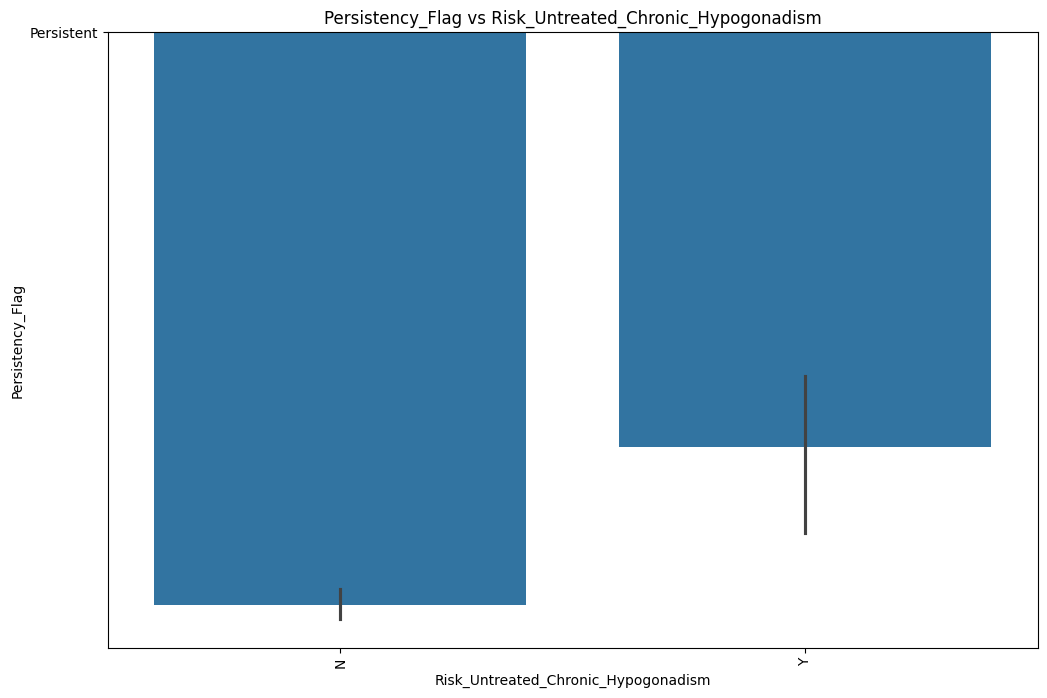

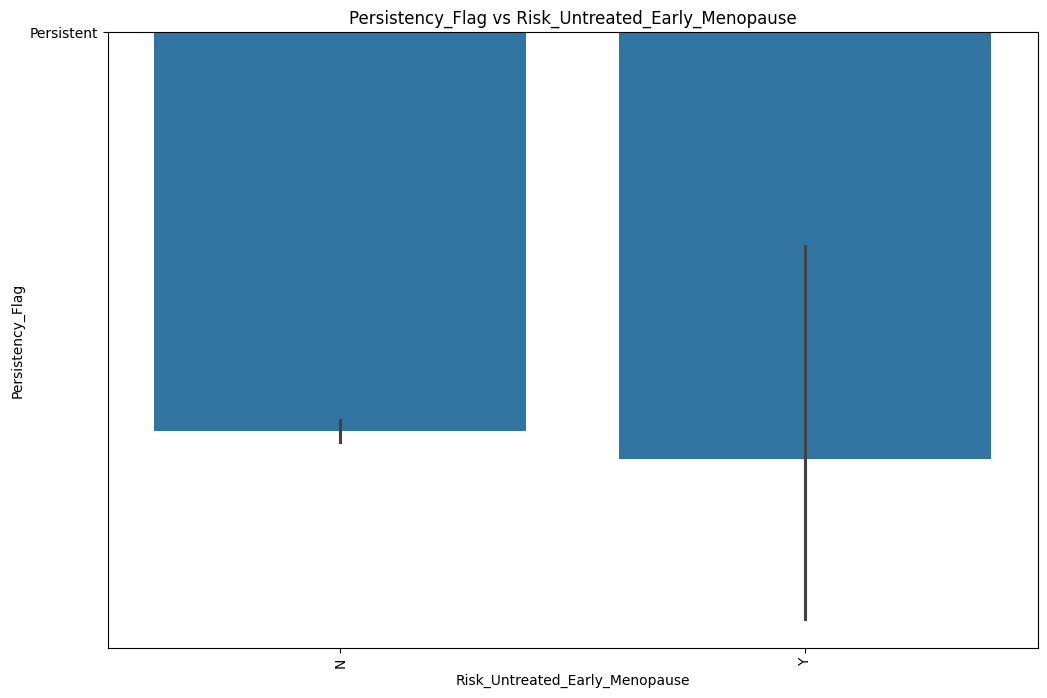

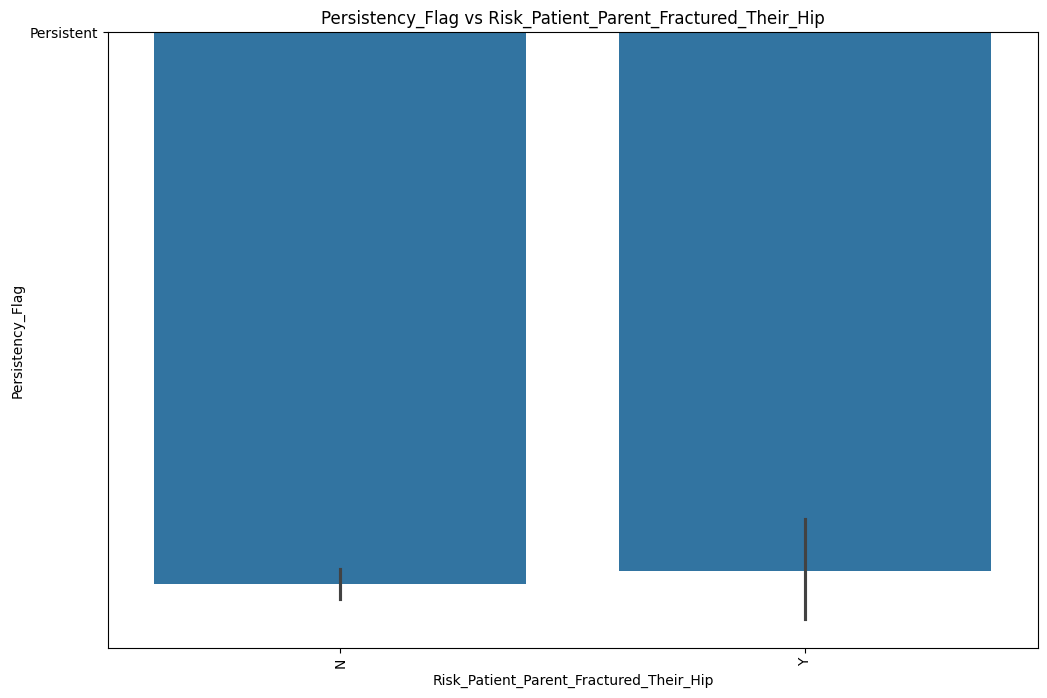

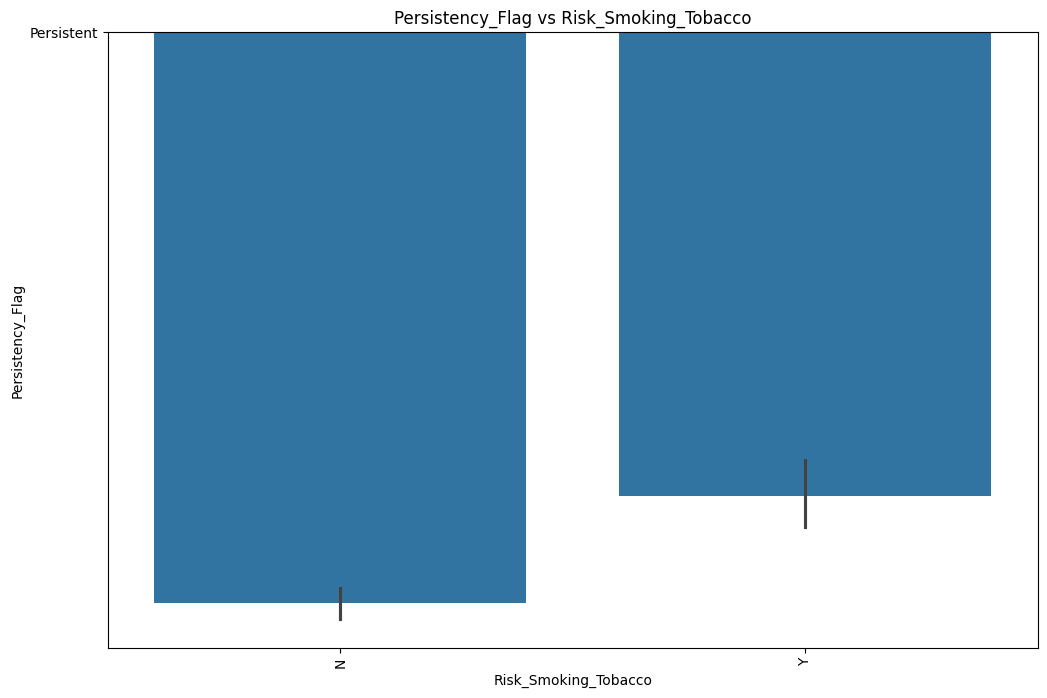

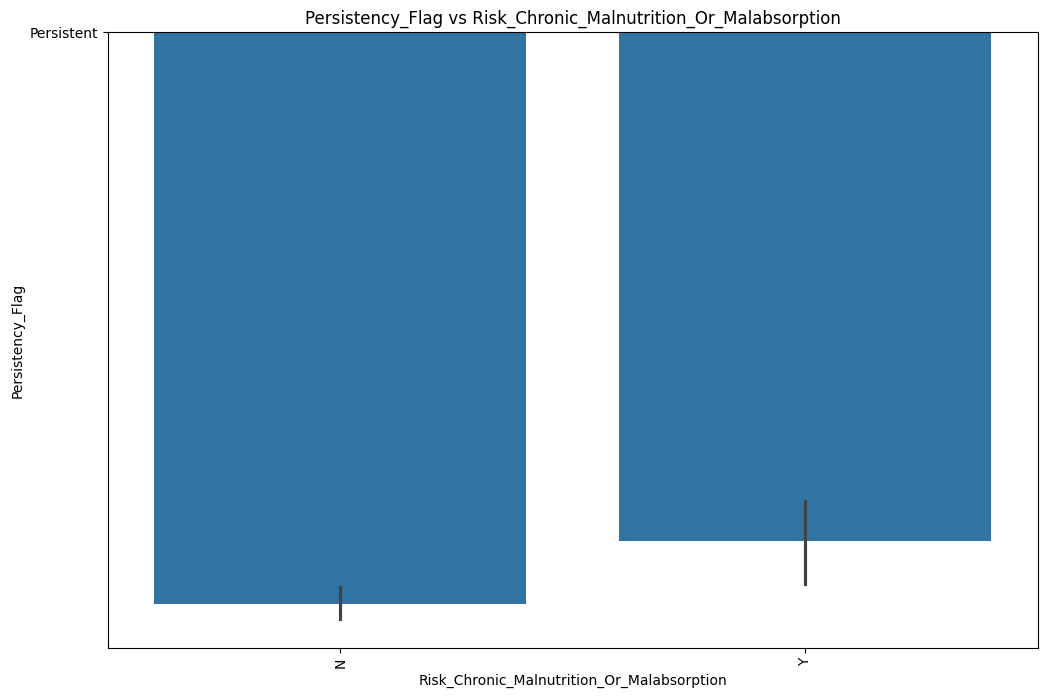

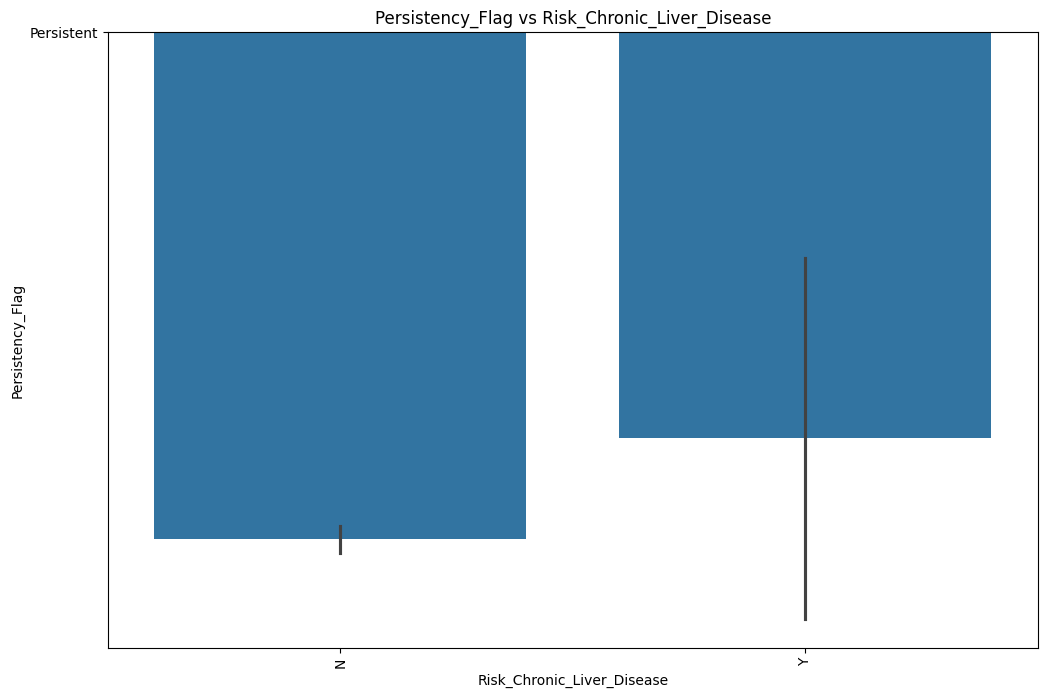

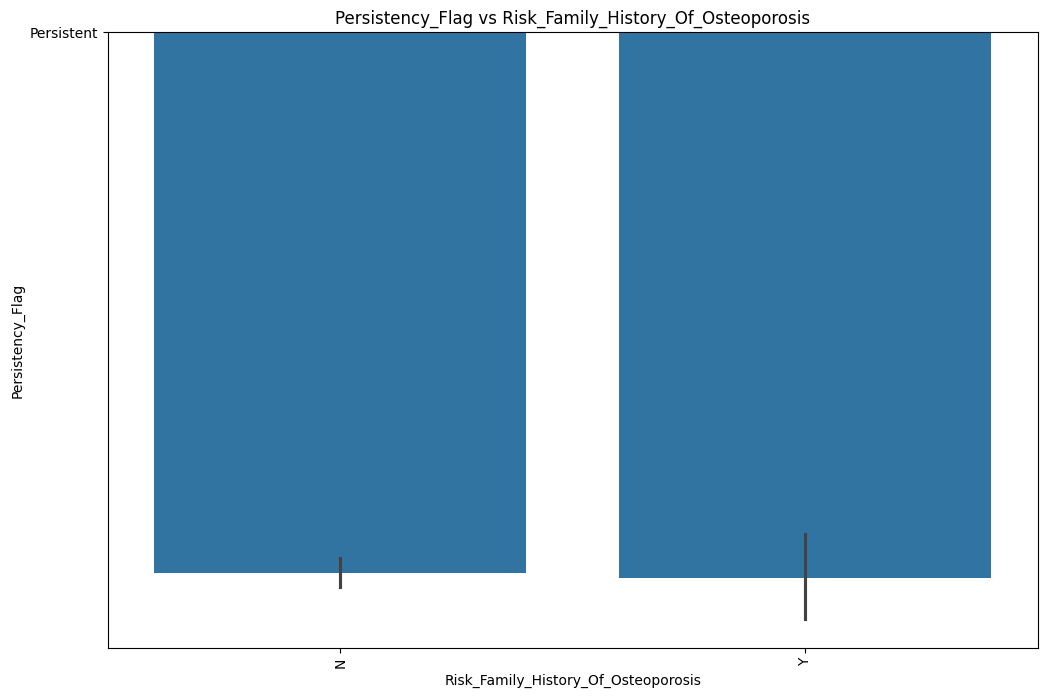

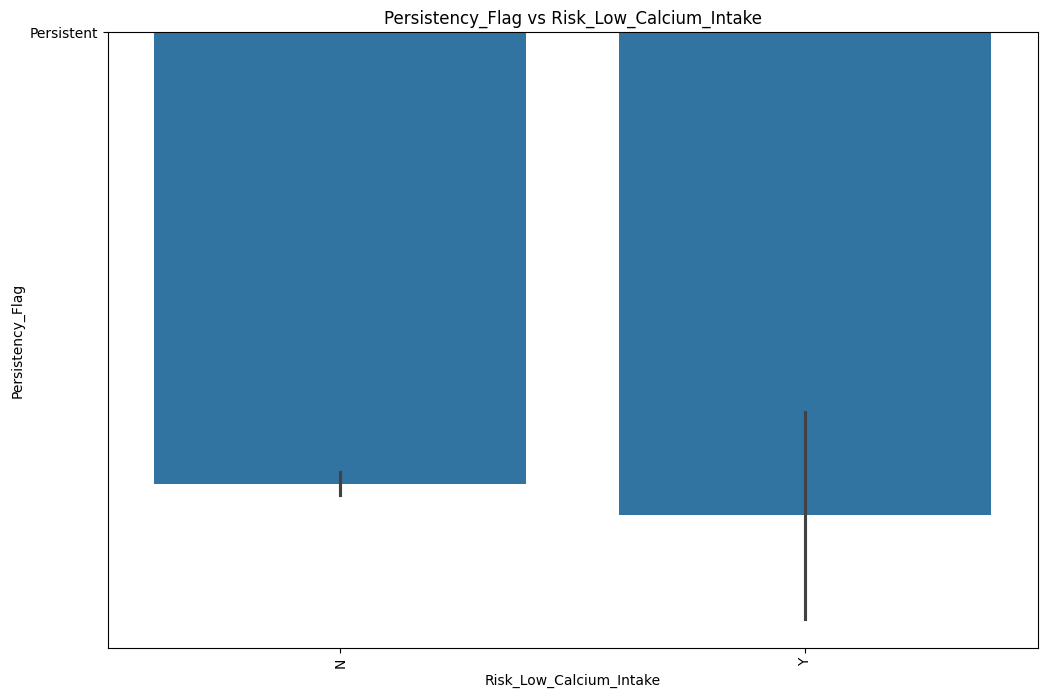

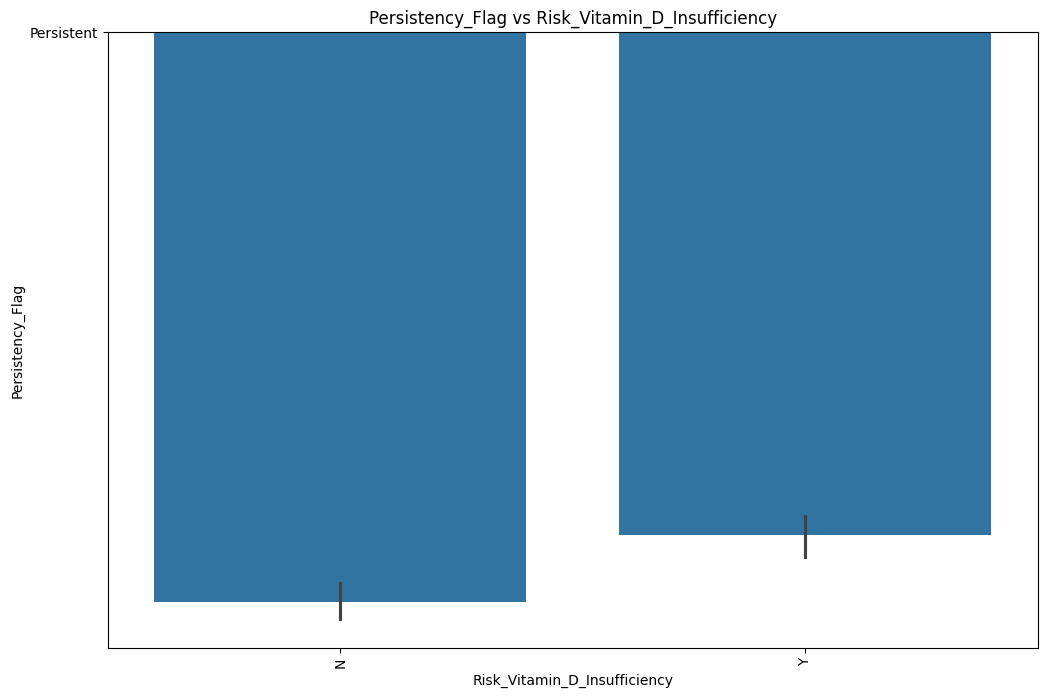

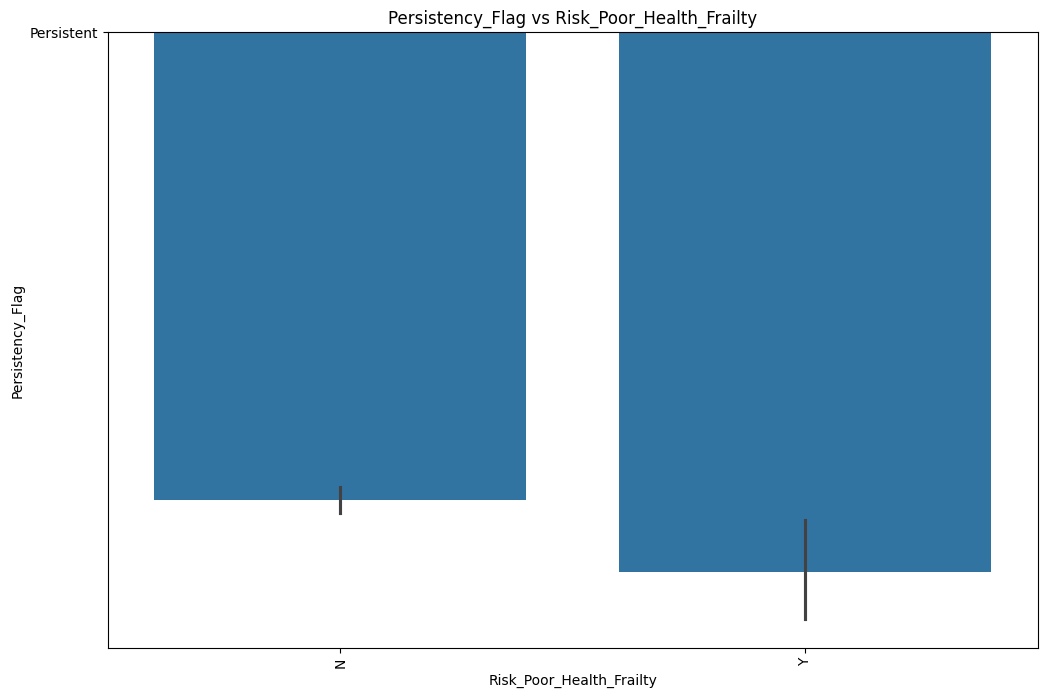

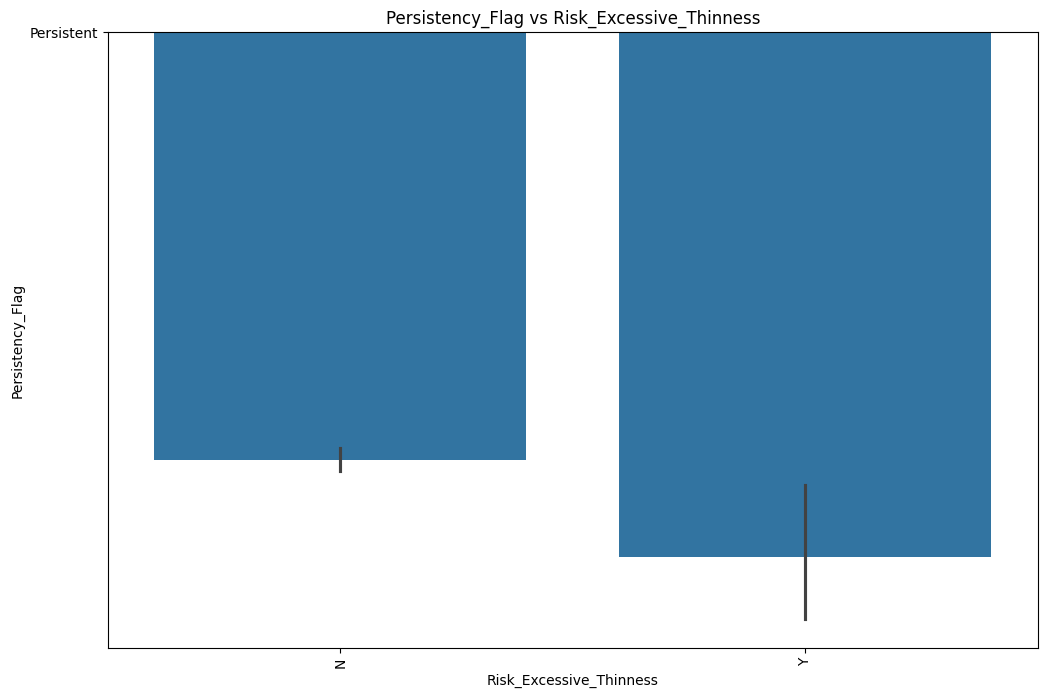

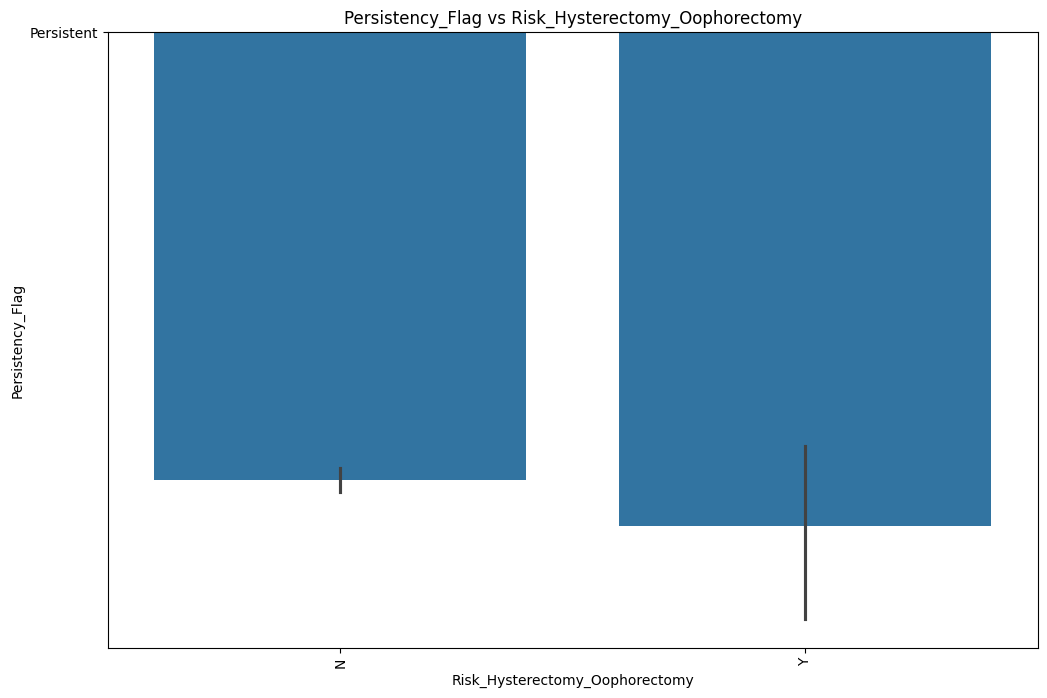

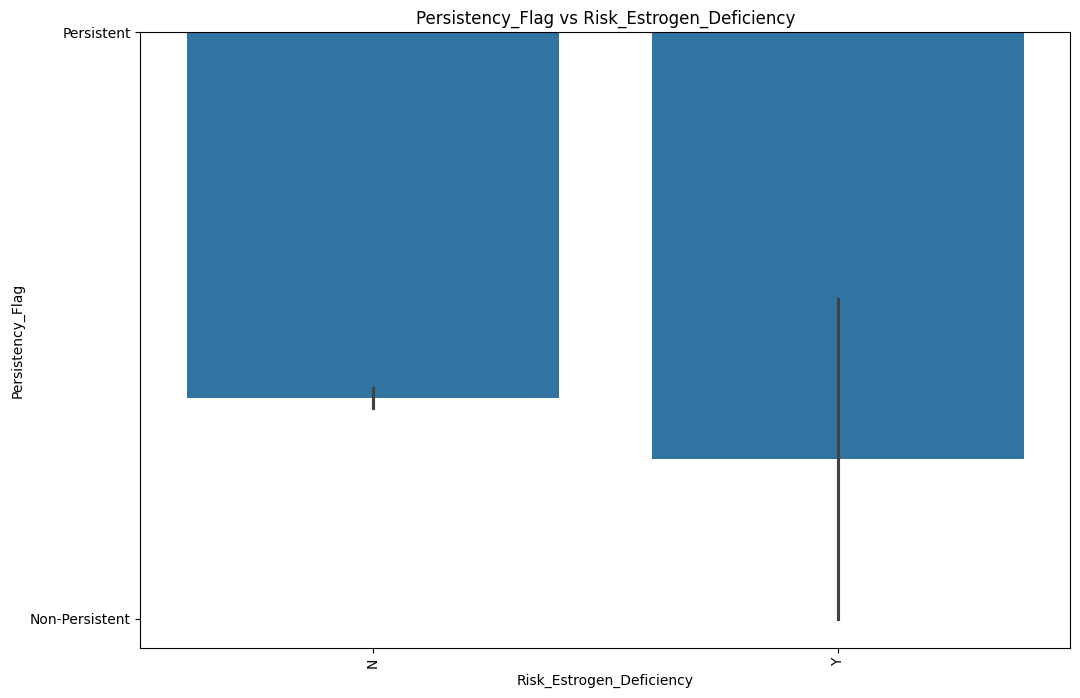

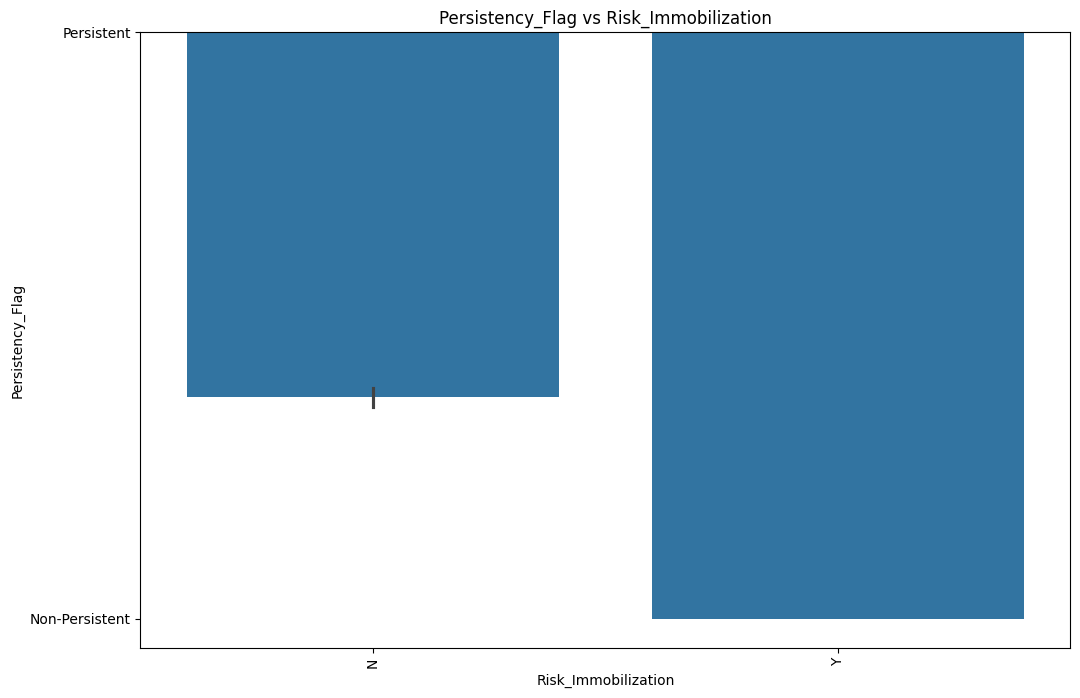

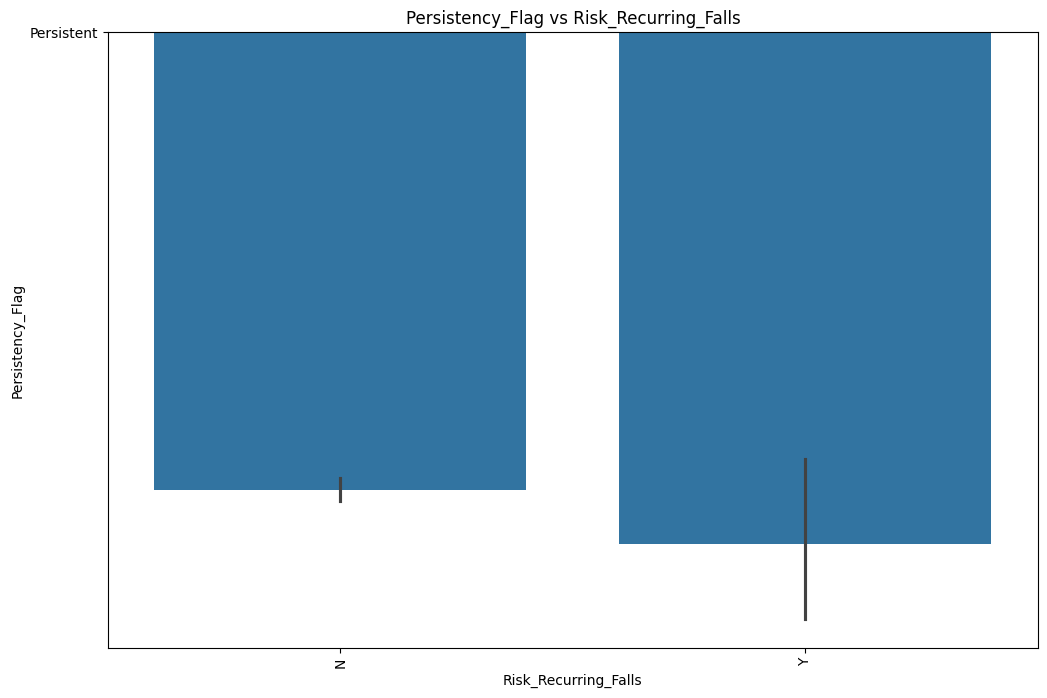

In [23]:
# analysing feature interaction

# analysing target variable with respect to other features

for col in data_set.select_dtypes(include=object).columns:
  if col != 'Persistency_Flag':
    plt.figure(figsize=(12,8))
    sns.barplot(x=col, y='Persistency_Flag', data=data_set)
    plt.xticks(rotation=90)
    plt.title(f'Persistency_Flag vs {col}')
    plt.show()